In [1]:
import pandas as pd
import numpy as np

import cognitive_GLVQ as cglvq
import OGLVQ as oglvq
import optimizer as opt

import matplotlib.pyplot as plt

import random
import copy


In [2]:
random.seed(5)

In [3]:
num_prototypes = 3
colors = ["#5171fF", "#fF7151", "#519951"]
img_folder = "images/figs/"
data_name = "iris"

In [4]:
def save_figs(model, experiment, model_name, lr):
    fig1 = model.lr_graph(f"{model_name} Learning Rate Graph")
    fig2 = model.acc_graph(f"{model_name} Accuracy Graph")
    fig3 = model.f1_graph(f"{model_name} F1 Score Graph")
    figs = [fig1, fig2, fig3]
    fig_type = ["lr", "acc", "f1"]
    for i, fig in enumerate(figs):
        fig.savefig(
            f"{img_folder}/{experiment}/{data_name}/{model_name}_{lr}_{fig_type[i]}.png",
            dpi=300,
        )


# Data prep

In [5]:
# Load the data
df = pd.read_csv("dataset/iris_dataset.csv")

# Shuffle the data
df = df.reset_index(drop=True)

In [6]:
feature = df[df.columns[:-1]]
label = df[df.columns[-1]]

feature = feature.to_numpy()
label = label.to_numpy()
label = label.reshape(-1, 1)

# Normalizing the data
feature = (feature - np.min(feature, axis=0)) / (
    np.max(feature, axis=0) - np.min(feature, axis=0)
)

In [7]:
unique, count = np.unique(label, return_counts=True)
sample_number = dict(zip(unique, count))
sample_number

{'Iris-setosa': 50, 'Iris-versicolor': 50, 'Iris-virginica': 50}

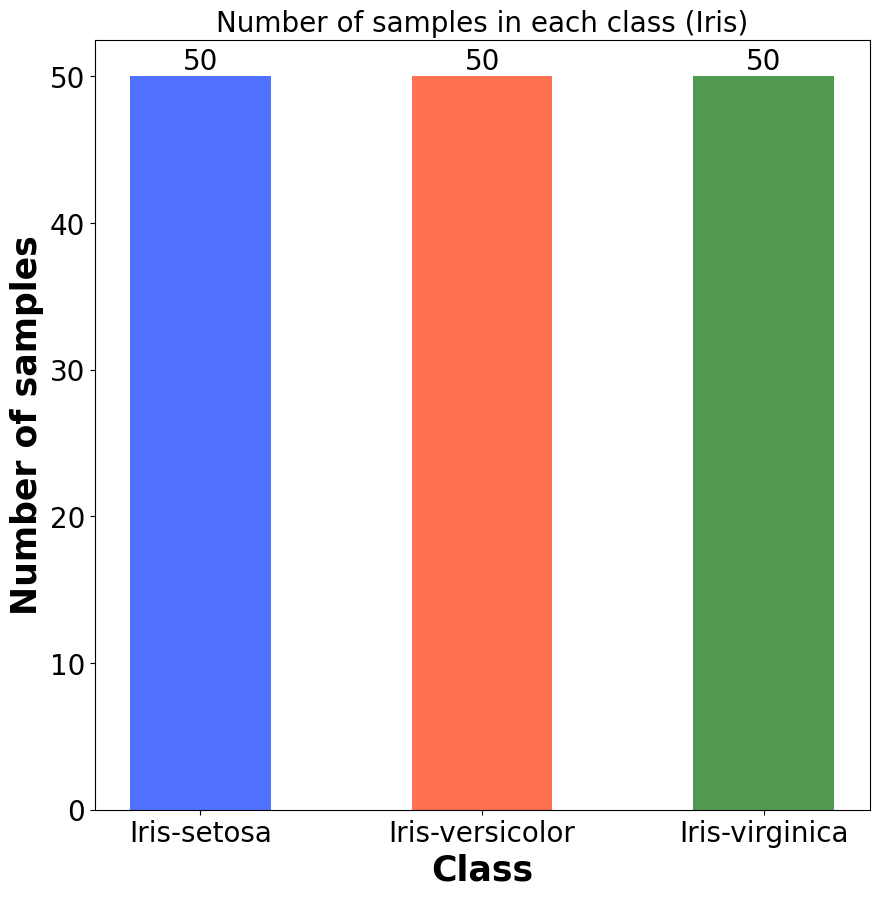

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
for i, (k, v) in enumerate(sample_number.items()):
    ax.bar(k, v, width=0.5, color=colors[i])
    plt.text(k, v + 0.1, str(v), ha="center", va="bottom", fontsize=20)
plt.title("Number of samples in each class (Iris)", fontsize=20)
plt.xlabel("Class", fontsize=25, weight="bold")
plt.ylabel("Number of samples", fontsize=25, weight="bold")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()
fig.savefig(img_folder + "sample/" + data_name, dpi=300)


## Select prototypes

In [9]:
prototypes_index = []
for class_name in sample_number:
    index_i = np.where(label == class_name)
    index_i = list(index_i[0])
    prototype_index_i = random.sample(index_i, num_prototypes)
    prototypes_index += prototype_index_i
prototypes_index.sort(reverse=True)
prototypes = [(feature[i], label[i]) for i in prototypes_index]
# Remove prototypes from dataset
feature = np.delete(feature, prototypes_index, axis=0)
label = np.delete(label, prototypes_index, axis=0)


### Accuracy

In [10]:
experiment = "experiment_1"

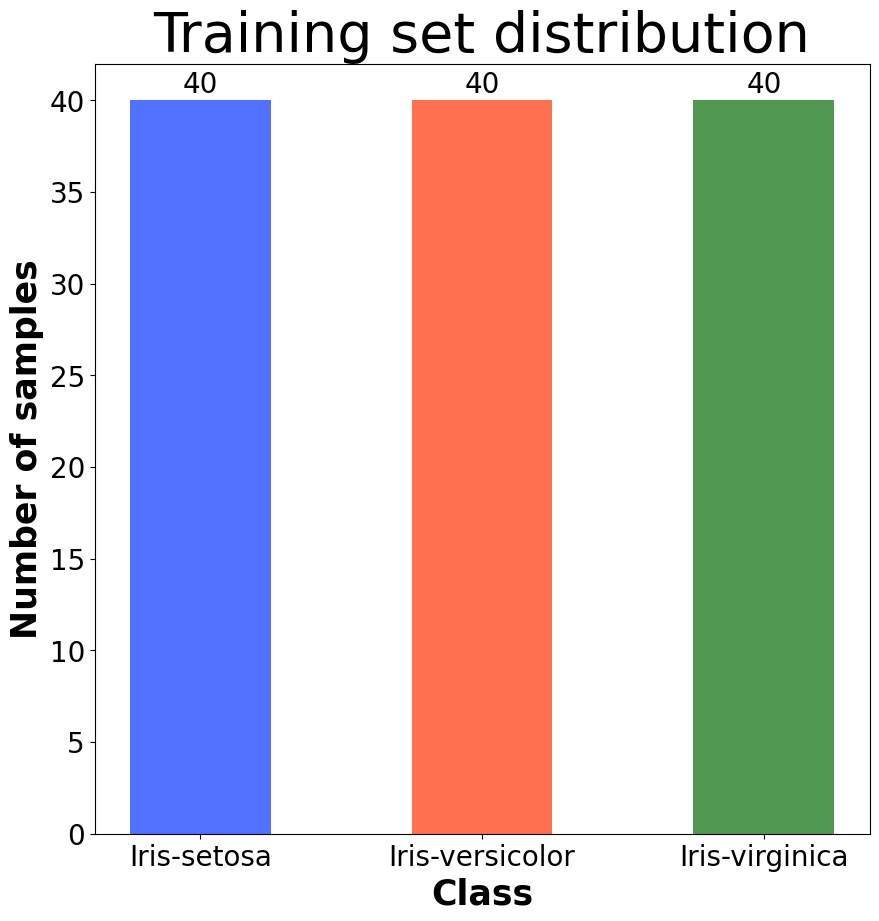

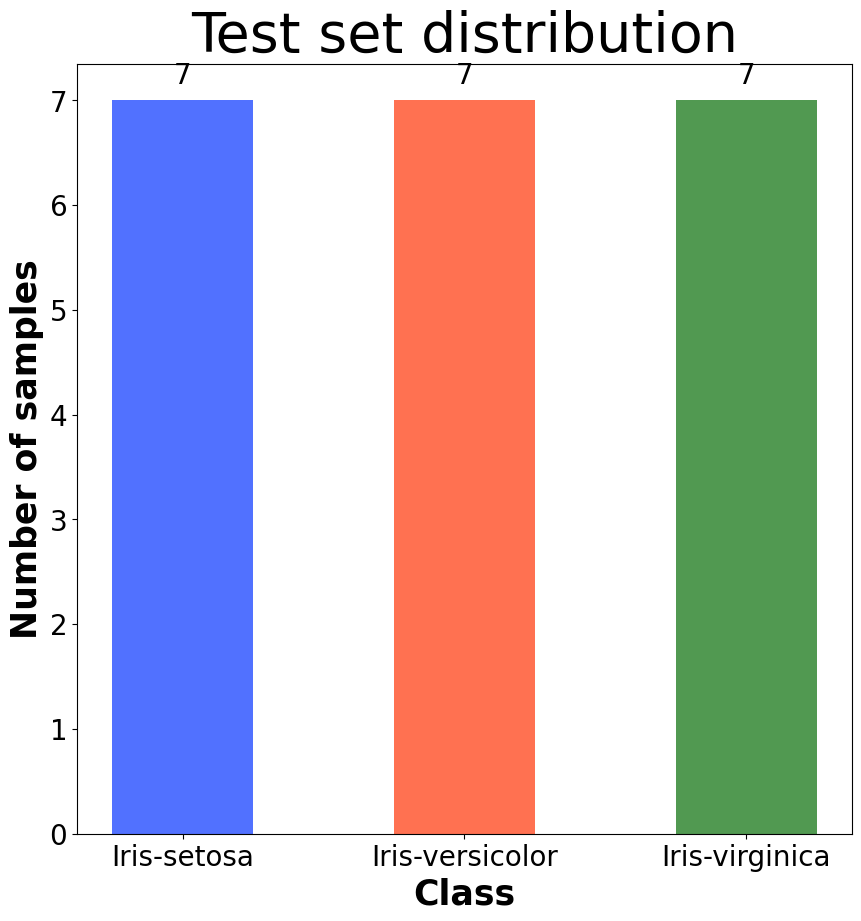

In [11]:
# Select equal amount of normal and abnormal data
data_per_class = min(count) - num_prototypes
test_percentage = 0.15
test_size = int(test_percentage * data_per_class)
train_size = data_per_class - test_size
feature_acc = copy.deepcopy(feature)
label_acc = copy.deepcopy(label)

# Select test set
test_index = []
for class_name in sample_number:
    index_i = np.where(label_acc == class_name)
    index_i = list(index_i[0])
    index_i_sample = random.sample(index_i, test_size)
    test_index += index_i_sample
test_index.sort(reverse=True)
test_set_acc = [(feature_acc[i], label_acc[i]) for i in test_index]
random.shuffle(test_set_acc)
unique, counts = np.unique(label_acc[test_index], return_counts=True)
test_dist = dict(zip(unique, counts))
feature_acc = np.delete(feature_acc, test_index, axis=0)
label_acc = np.delete(label_acc, test_index, axis=0)

# Select train set
train_index = []
for class_name in sample_number:
    index_i = np.where(label_acc == class_name)
    index_i = list(index_i[0])
    index_i_sample = random.sample(index_i, train_size)
    train_index += index_i_sample
train_index.sort(reverse=True)
unique, counts = np.unique(label_acc[train_index], return_counts=True)
train_dist = dict(zip(unique, counts))
train_set_acc = [(feature_acc[i], label_acc[i]) for i in train_index]
random.shuffle(train_set_acc)

fig, ax = plt.subplots(figsize=(10, 10))
for i, (k, v) in enumerate(train_dist.items()):
    ax.bar(k, v, width=0.5, color=colors[i])
    plt.text(k, v + 0.1, str(v), ha="center", va="bottom", fontsize=20)
plt.title("Training set distribution", fontsize=40)
plt.xlabel("Class", fontsize=25, weight="bold")
plt.ylabel("Number of samples", fontsize=25, weight="bold")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()
fig.savefig(img_folder + experiment + "/" +
            data_name + "/train_dist.png", dpi=300)


fig, ax = plt.subplots(figsize=(10, 10))
for i, (k, v) in enumerate(test_dist.items()):
    ax.bar(k, v, width=0.5, color=colors[i])
    plt.text(k, v + 0.1, str(v), ha="center", va="bottom", fontsize=20)
plt.title("Test set distribution", fontsize=40)
plt.xlabel("Class", fontsize=25, weight="bold")
plt.ylabel("Number of samples", fontsize=25, weight="bold")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()
fig.savefig(img_folder + experiment + "/" +
            data_name + "/test_dist.png", dpi=300)


##### Train the models

In [12]:
num_epochs = 100

##### GLVQ

##### 1-step lr =0.1

In [13]:
learning_rate = 0.1
oglvq_acc = oglvq.OGLVQ(prototypes, learning_rate)
hist = oglvq_acc.train(
    num_epochs, train_set_acc, test_set_acc, sample_number=train_dist
)

Epoch: 1, Loss: 39.6152, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 11, Loss: 38.5933, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 21, Loss: 38.5720, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 31, Loss: 38.5647, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 41, Loss: 38.5611, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 51, Loss: 38.5589, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 61, Loss: 38.5575, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 71, Loss: 38.5564, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 81, Loss: 38.5557, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 91, Loss: 38.5551, Accuracy: 100.00 %, F_1_score: 100.00 %


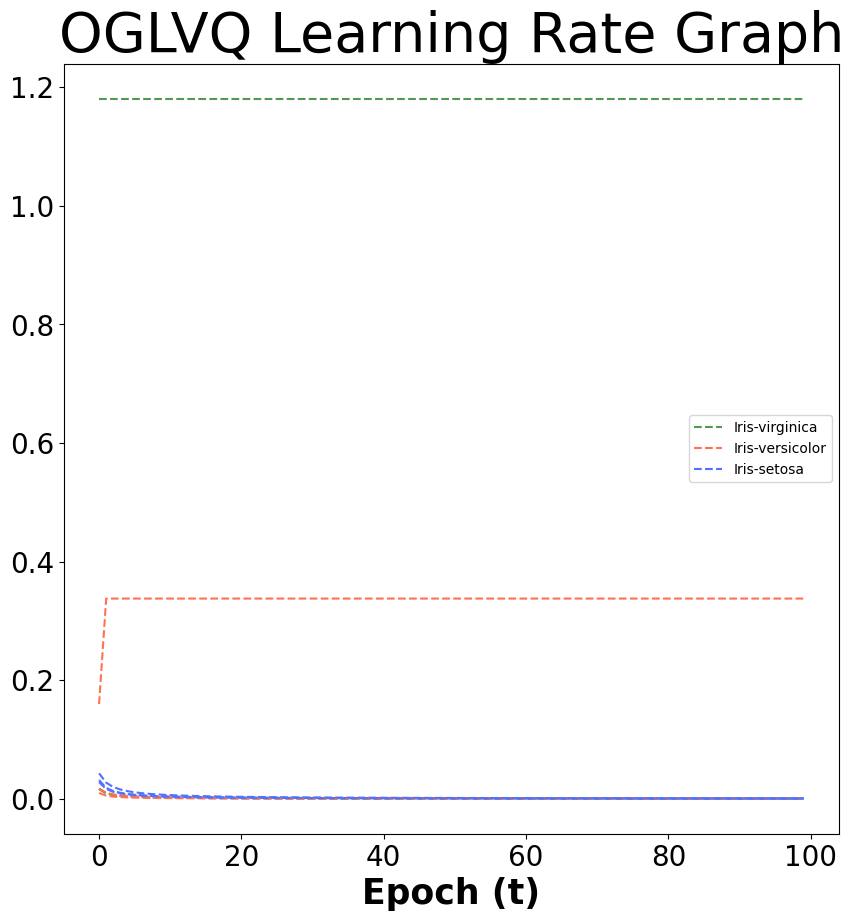

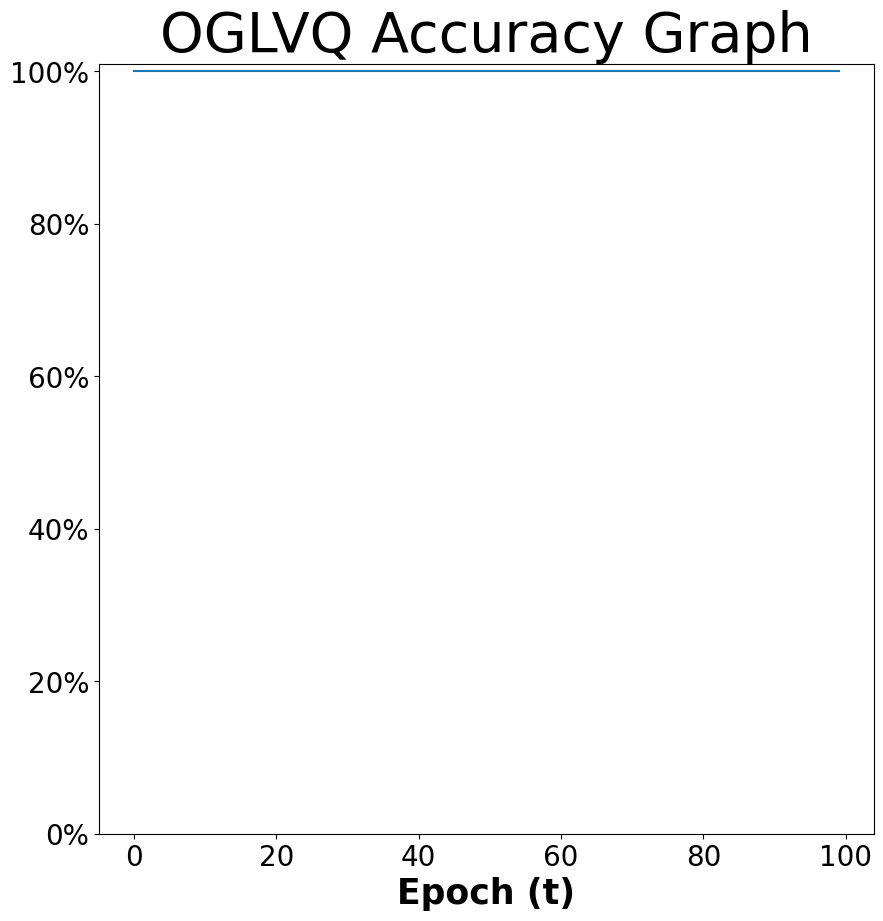

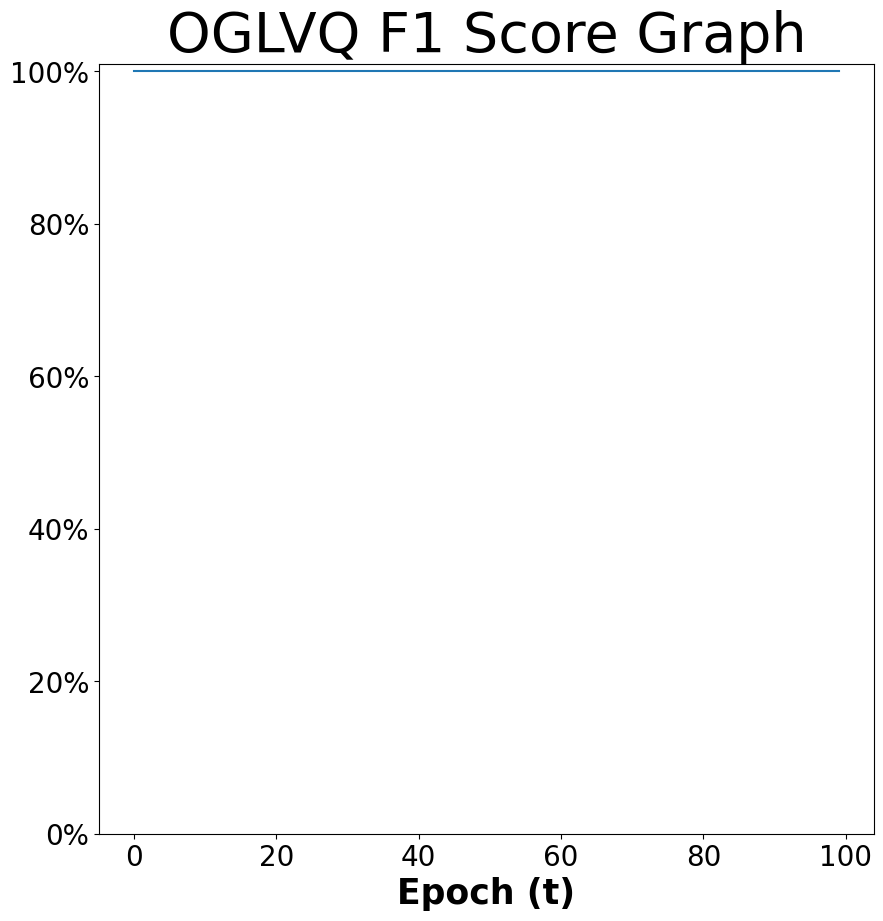

In [14]:
save_figs(oglvq_acc, experiment, "OGLVQ", learning_rate)

##### 2-step lr = 0.03

In [15]:
learning_rate = 0.03
oglvq_acc = oglvq.OGLVQ(
    prototypes,
    learning_rate,
)
hist = oglvq_acc.train(
    num_epochs, train_set_acc, test_set_acc, sample_number=train_dist
)

Epoch: 1, Loss: 39.8666, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 11, Loss: 38.3588, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 21, Loss: 38.2965, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 31, Loss: 38.2764, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 41, Loss: 38.2671, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 51, Loss: 38.2614, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 61, Loss: 38.2469, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 71, Loss: 38.2187, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 81, Loss: 38.1960, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 91, Loss: 38.1666, Accuracy: 100.00 %, F_1_score: 100.00 %


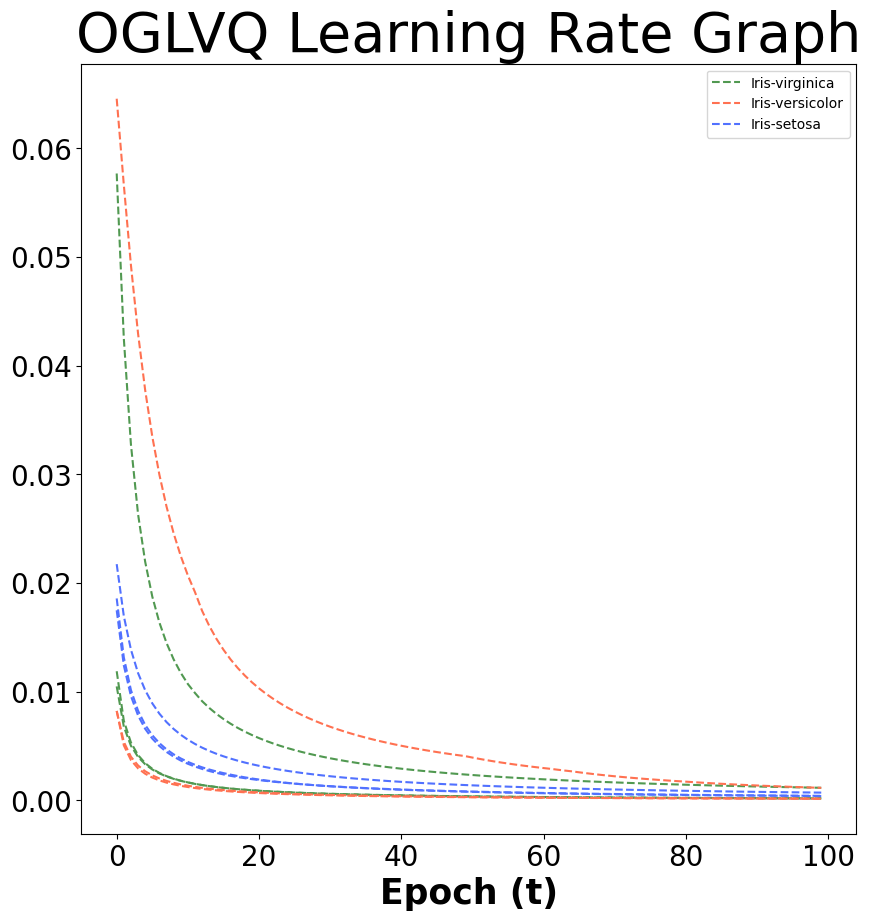

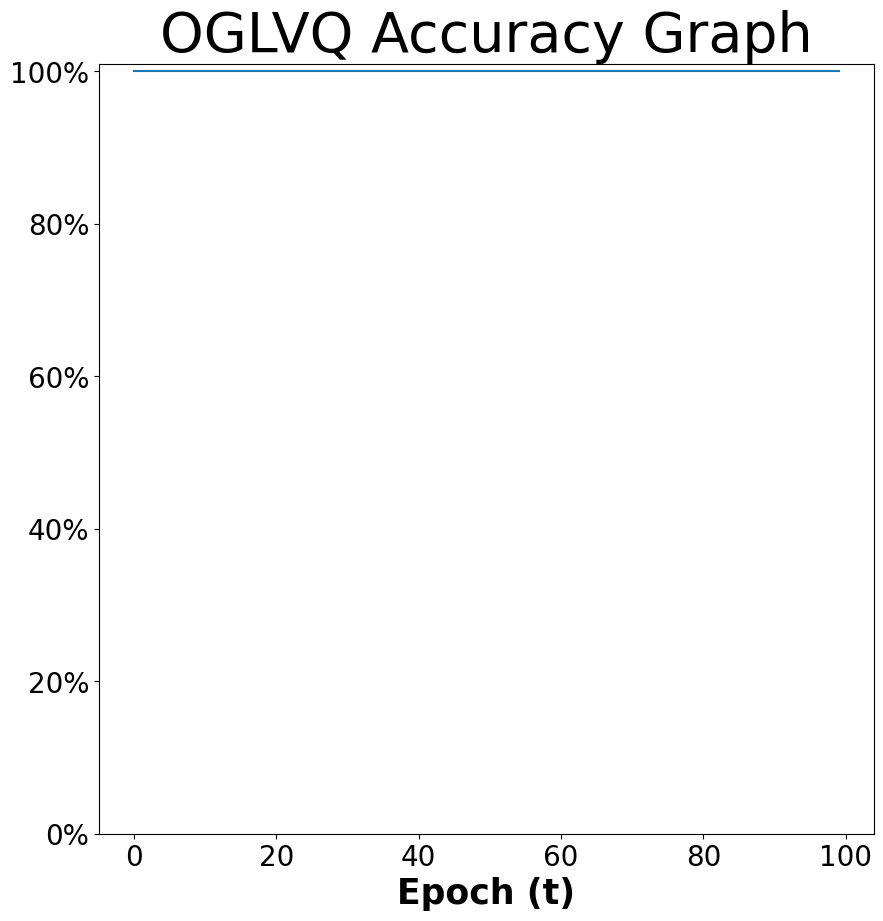

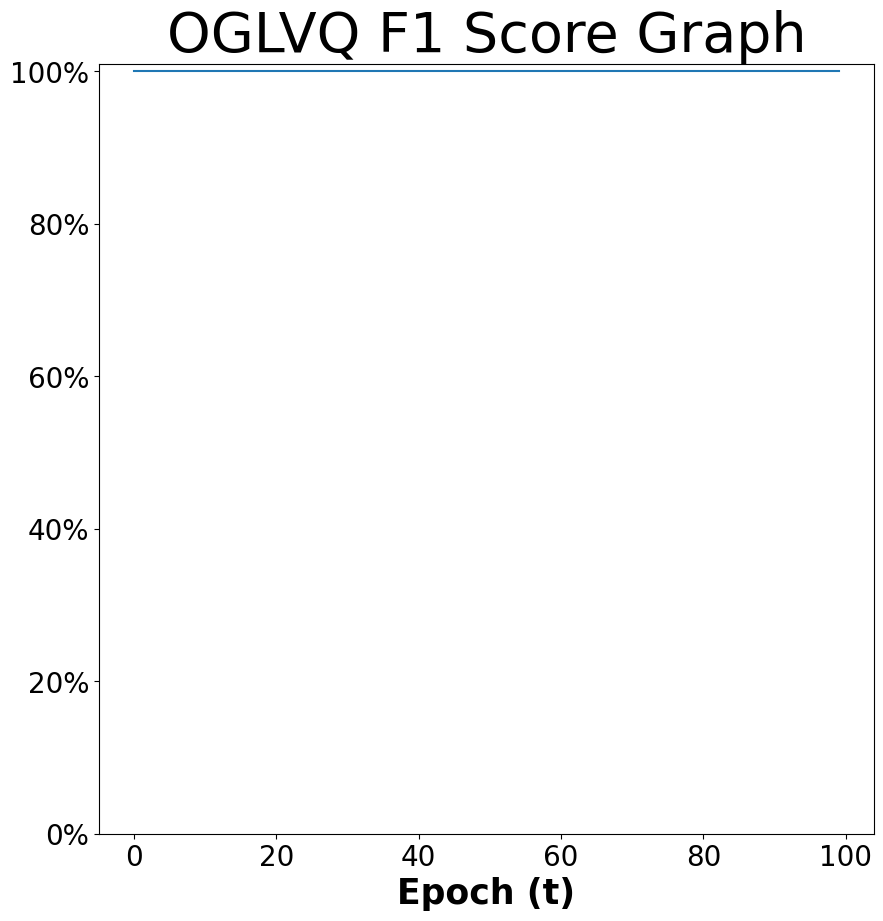

In [16]:
save_figs(oglvq_acc, experiment, "OGLVQ", learning_rate)

##### 3-step lr = 0.01

In [17]:
learning_rate = 0.01
oglvq_acc = oglvq.OGLVQ(prototypes, learning_rate)
hist = oglvq_acc.train(
    num_epochs, train_set_acc, test_set_acc, sample_number=train_dist
)

Epoch: 1, Loss: 40.4607, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 11, Loss: 38.4117, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 21, Loss: 38.3466, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 31, Loss: 38.3282, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 41, Loss: 38.3183, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 51, Loss: 38.3116, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 61, Loss: 38.3074, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 71, Loss: 38.3046, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 81, Loss: 38.3018, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 91, Loss: 38.3009, Accuracy: 100.00 %, F_1_score: 100.00 %


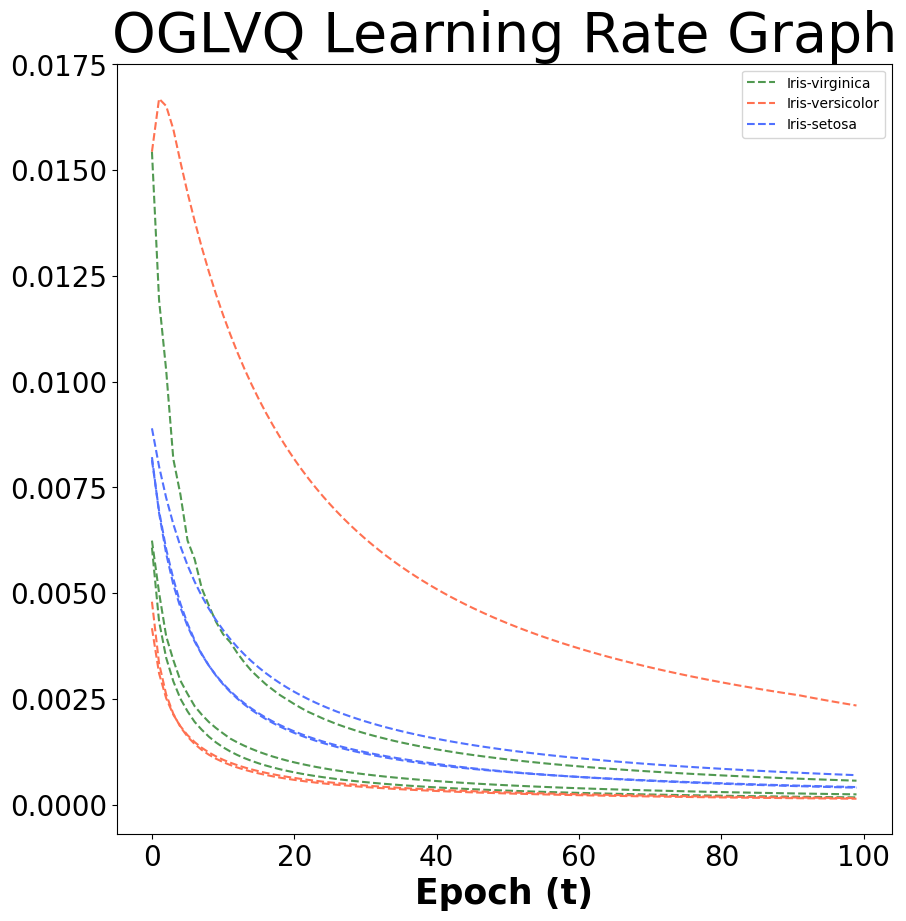

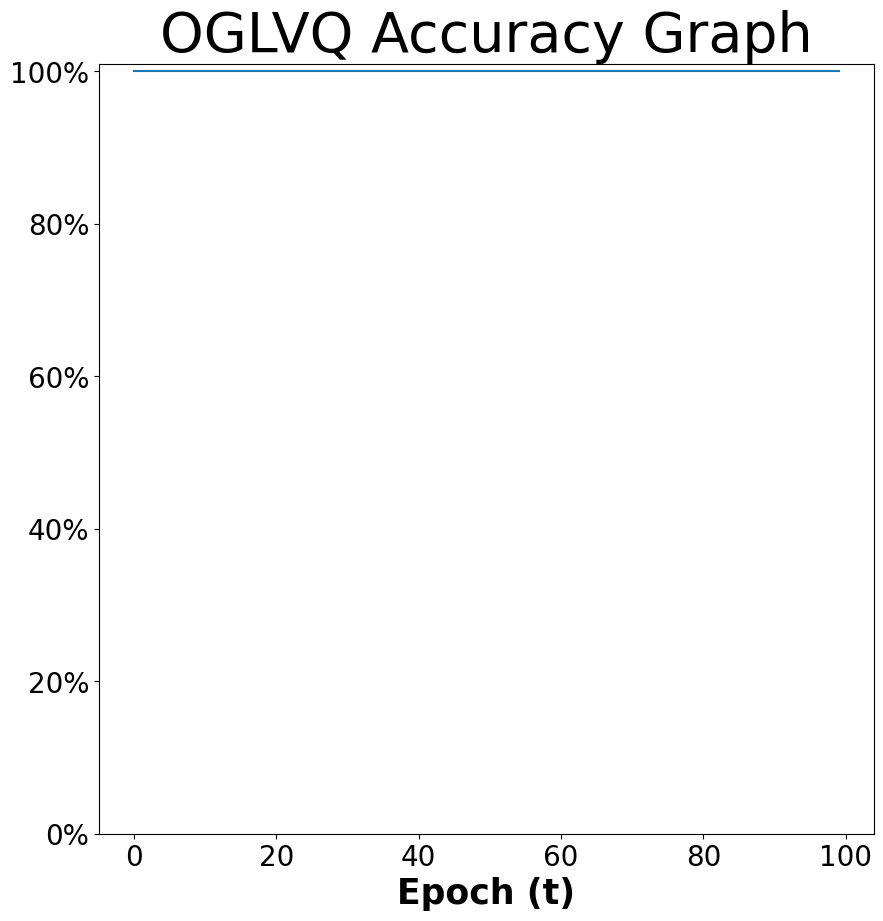

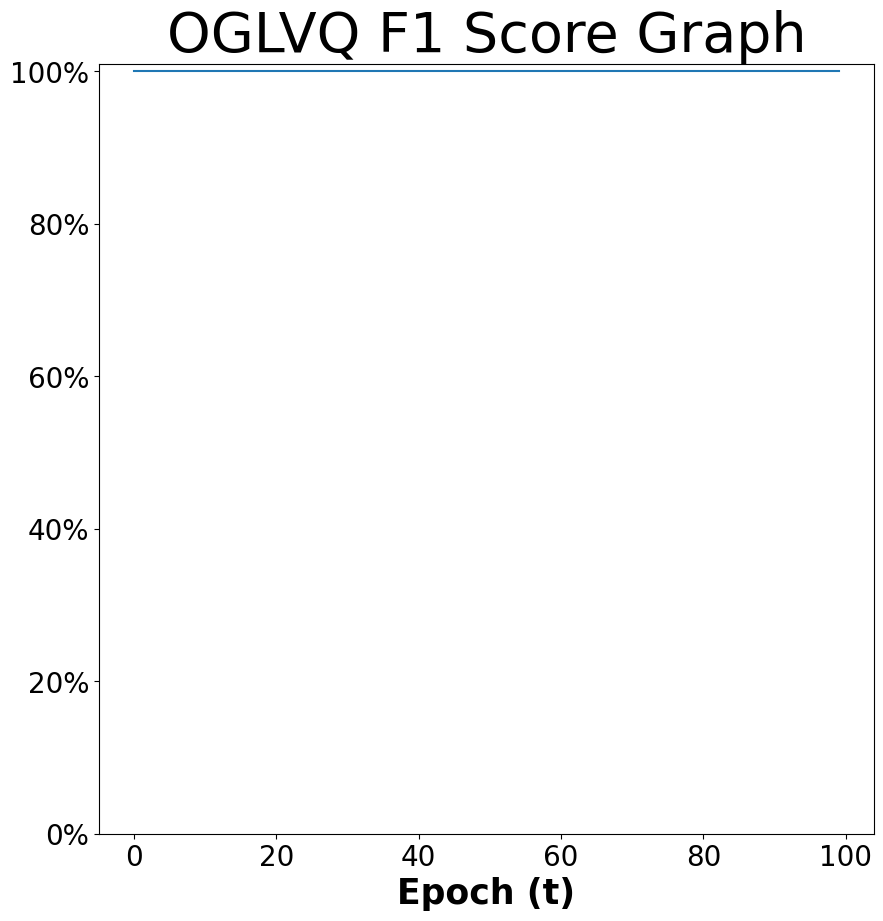

In [18]:
save_figs(oglvq_acc, experiment, "OGLVQ", learning_rate)

##### CP

##### 1-step lr = 0.1

In [19]:
learning_rate = 0.1
cp_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = cp_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.conditional_probability,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.3452, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 11, Loss: 0.3457, Accuracy: 80.95 %, F_1_score: 71.85 %
Epoch: 21, Loss: 0.3879, Accuracy: 76.19 %, F_1_score: 63.94 %
Epoch: 31, Loss: 0.3863, Accuracy: 76.19 %, F_1_score: 63.94 %
Epoch: 41, Loss: 0.3841, Accuracy: 76.19 %, F_1_score: 63.94 %
Epoch: 51, Loss: 0.3525, Accuracy: 80.95 %, F_1_score: 71.85 %
Epoch: 61, Loss: 0.3503, Accuracy: 80.95 %, F_1_score: 71.85 %
Epoch: 71, Loss: 0.3497, Accuracy: 80.95 %, F_1_score: 71.85 %
Epoch: 81, Loss: 0.3496, Accuracy: 80.95 %, F_1_score: 71.85 %
Epoch: 91, Loss: 0.3496, Accuracy: 80.95 %, F_1_score: 71.85 %


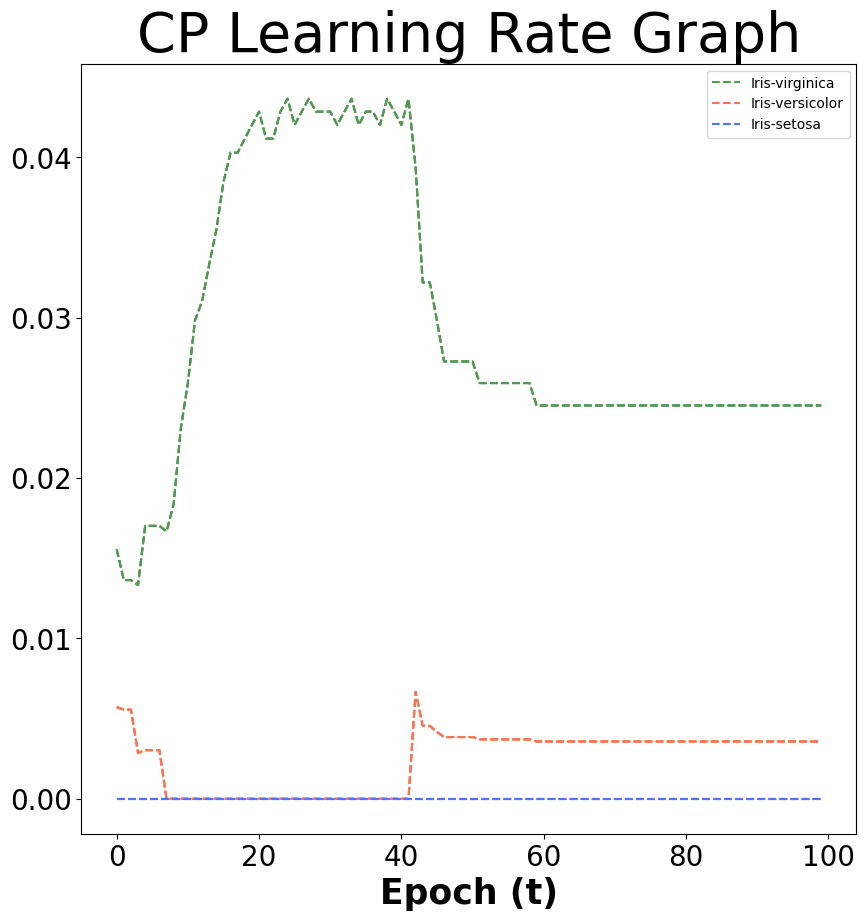

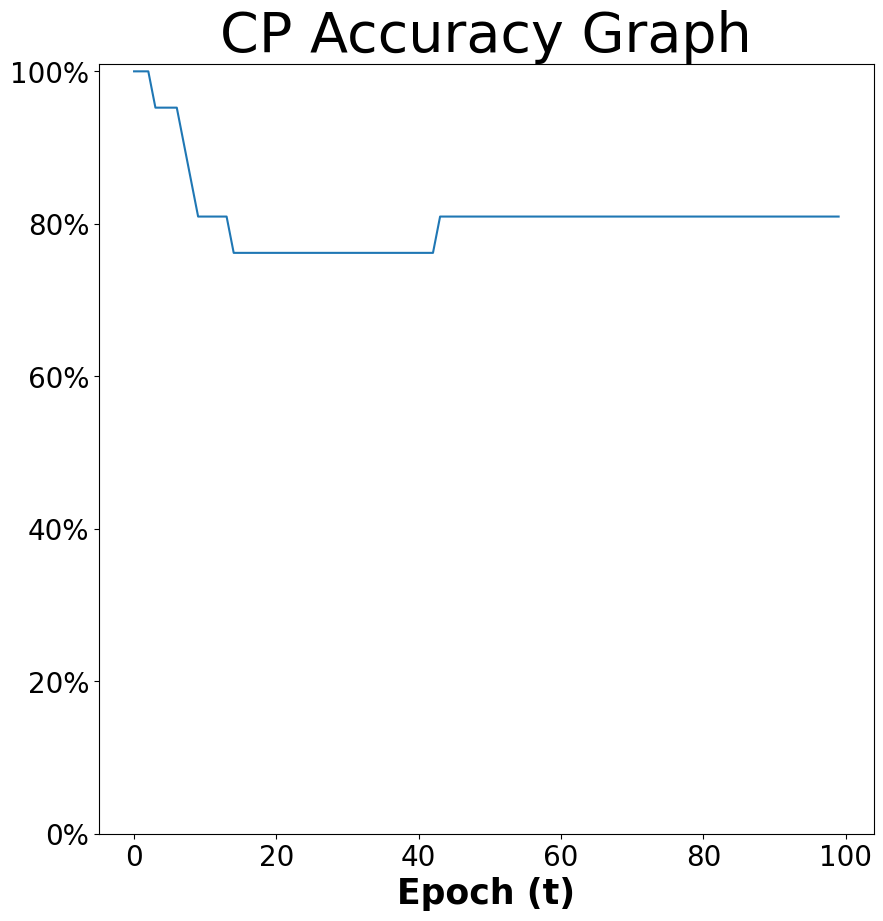

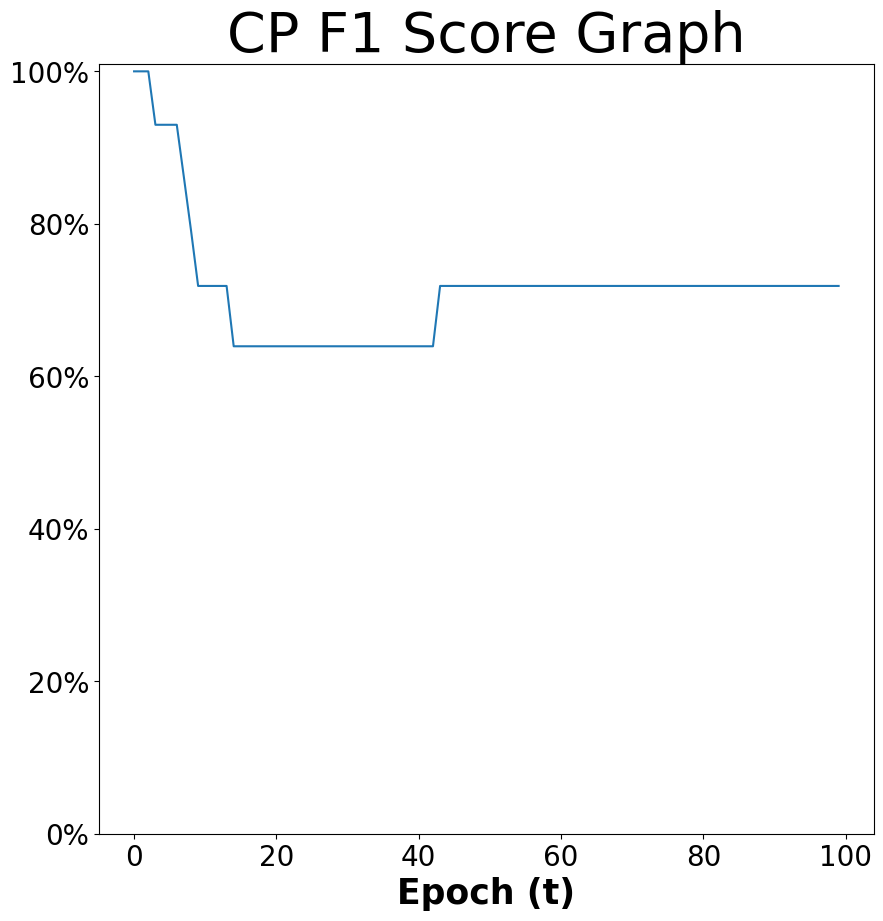

In [20]:
save_figs(cp_glvq_acc, experiment, "CP", learning_rate)

##### 2-step lr = 0.03

In [21]:
learning_rate = 0.03
cp_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = cp_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.conditional_probability,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.3490, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 11, Loss: 0.3285, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 21, Loss: 0.3287, Accuracy: 95.24 %, F_1_score: 92.99 %
Epoch: 31, Loss: 0.3358, Accuracy: 85.71 %, F_1_score: 79.14 %
Epoch: 41, Loss: 0.3515, Accuracy: 80.95 %, F_1_score: 71.85 %
Epoch: 51, Loss: 0.3662, Accuracy: 80.95 %, F_1_score: 71.85 %
Epoch: 61, Loss: 0.3781, Accuracy: 76.19 %, F_1_score: 63.94 %
Epoch: 71, Loss: 0.3869, Accuracy: 76.19 %, F_1_score: 63.94 %
Epoch: 81, Loss: 0.3879, Accuracy: 76.19 %, F_1_score: 63.94 %
Epoch: 91, Loss: 0.3881, Accuracy: 76.19 %, F_1_score: 63.94 %


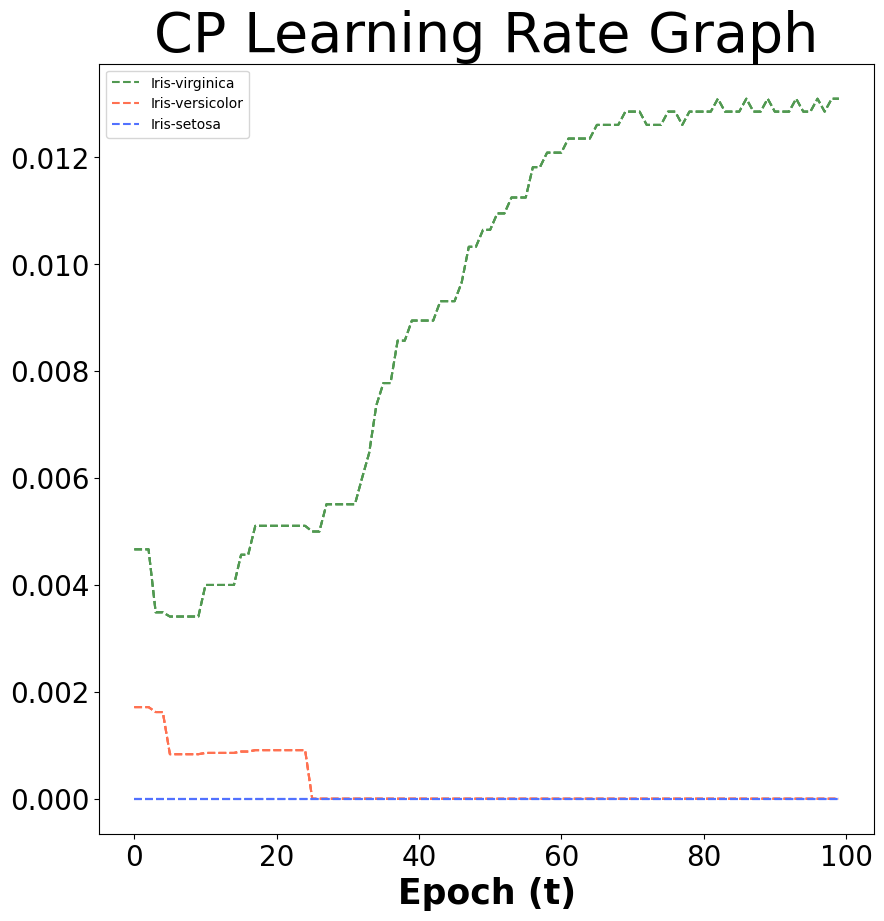

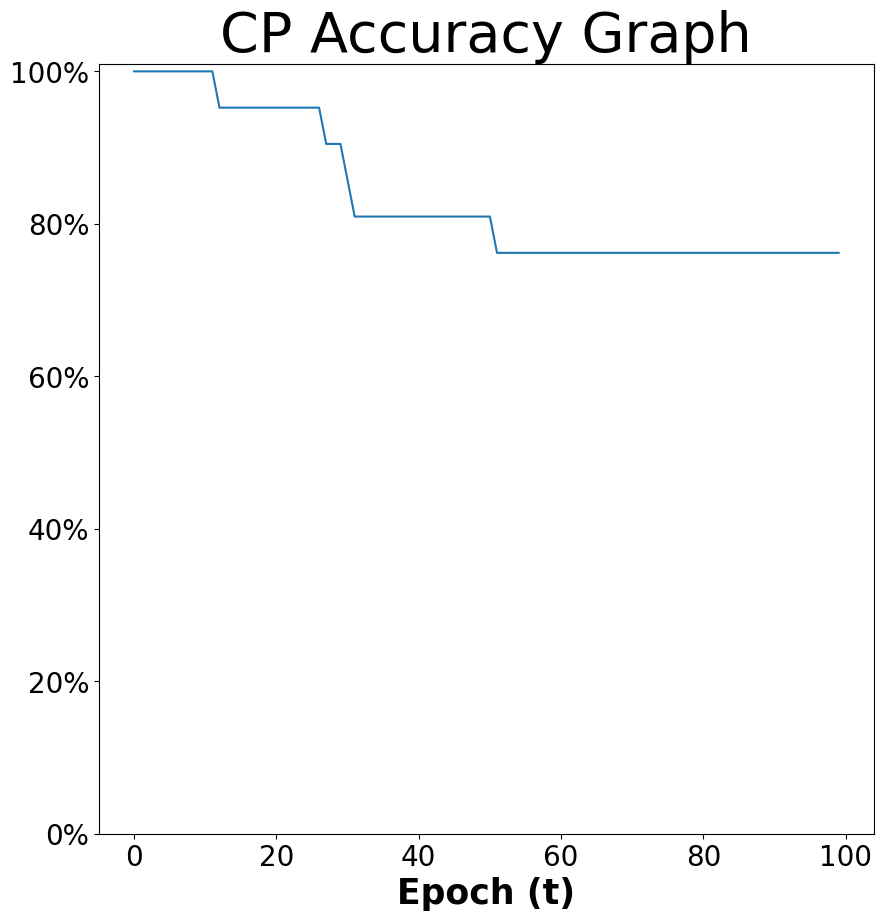

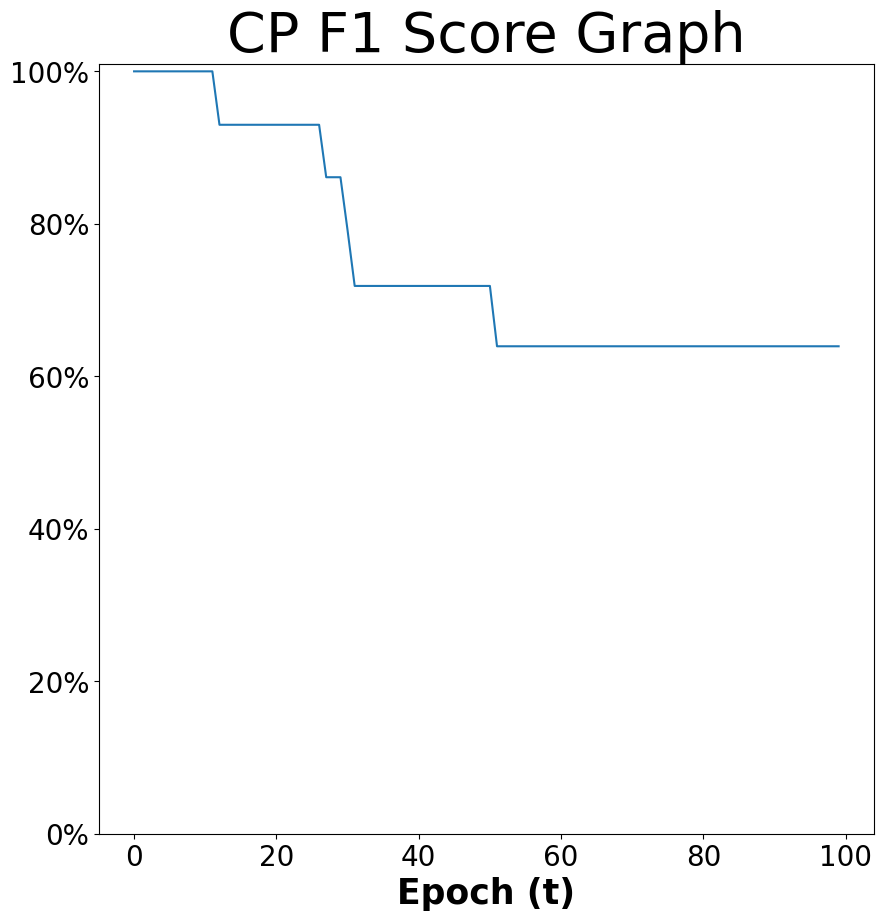

In [22]:
save_figs(cp_glvq_acc, experiment, "CP", learning_rate)

##### 3-step lr = 0.01

In [23]:
learning_rate = 0.01
cp_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = cp_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.conditional_probability,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.3505, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 11, Loss: 0.3340, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 21, Loss: 0.3300, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 31, Loss: 0.3284, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 41, Loss: 0.3278, Accuracy: 95.24 %, F_1_score: 92.99 %
Epoch: 51, Loss: 0.3279, Accuracy: 95.24 %, F_1_score: 92.99 %
Epoch: 61, Loss: 0.3283, Accuracy: 95.24 %, F_1_score: 92.99 %
Epoch: 71, Loss: 0.3286, Accuracy: 95.24 %, F_1_score: 92.99 %
Epoch: 81, Loss: 0.3304, Accuracy: 95.24 %, F_1_score: 92.99 %
Epoch: 91, Loss: 0.3345, Accuracy: 90.48 %, F_1_score: 86.11 %


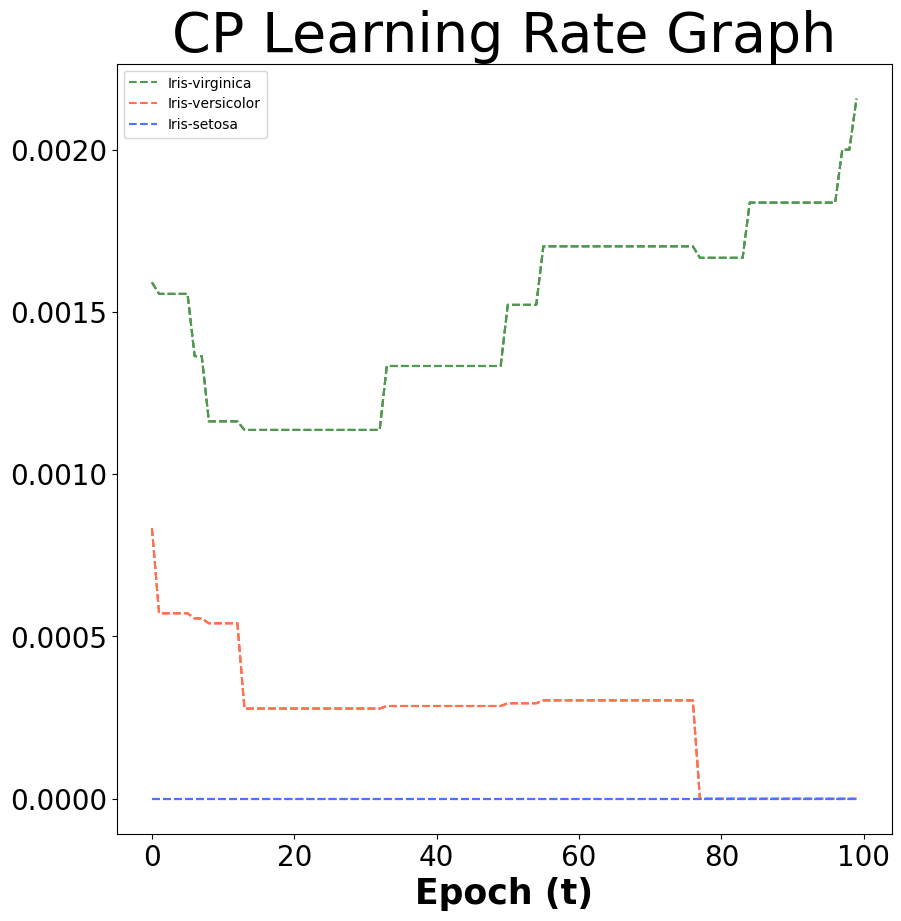

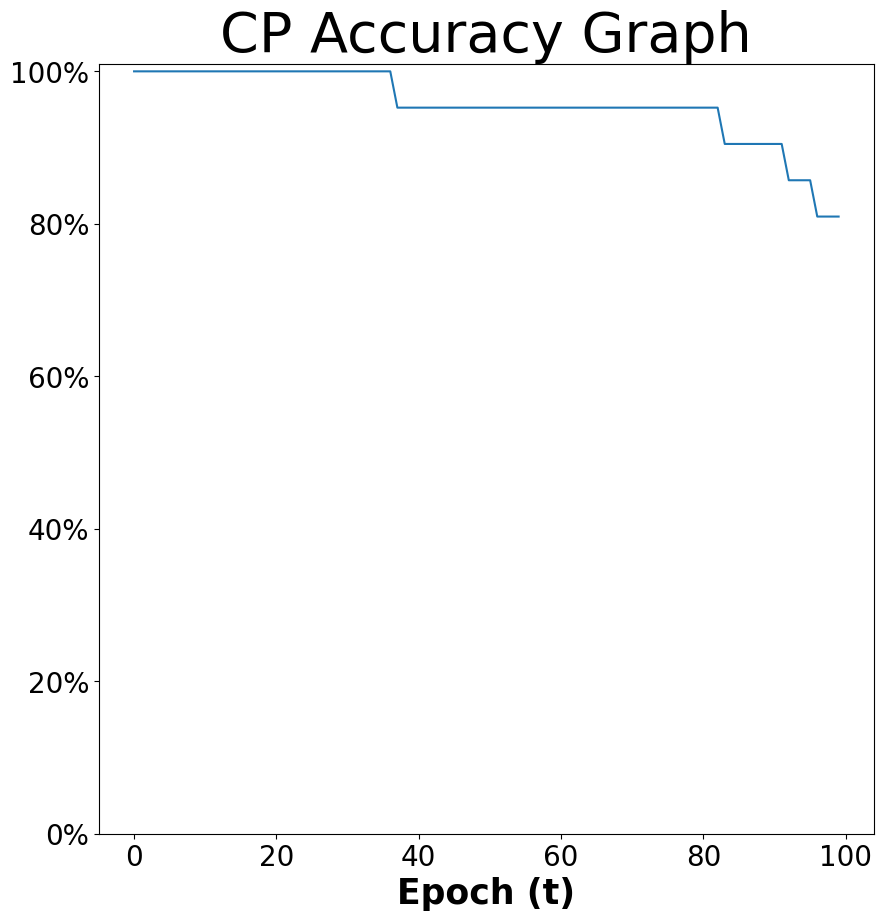

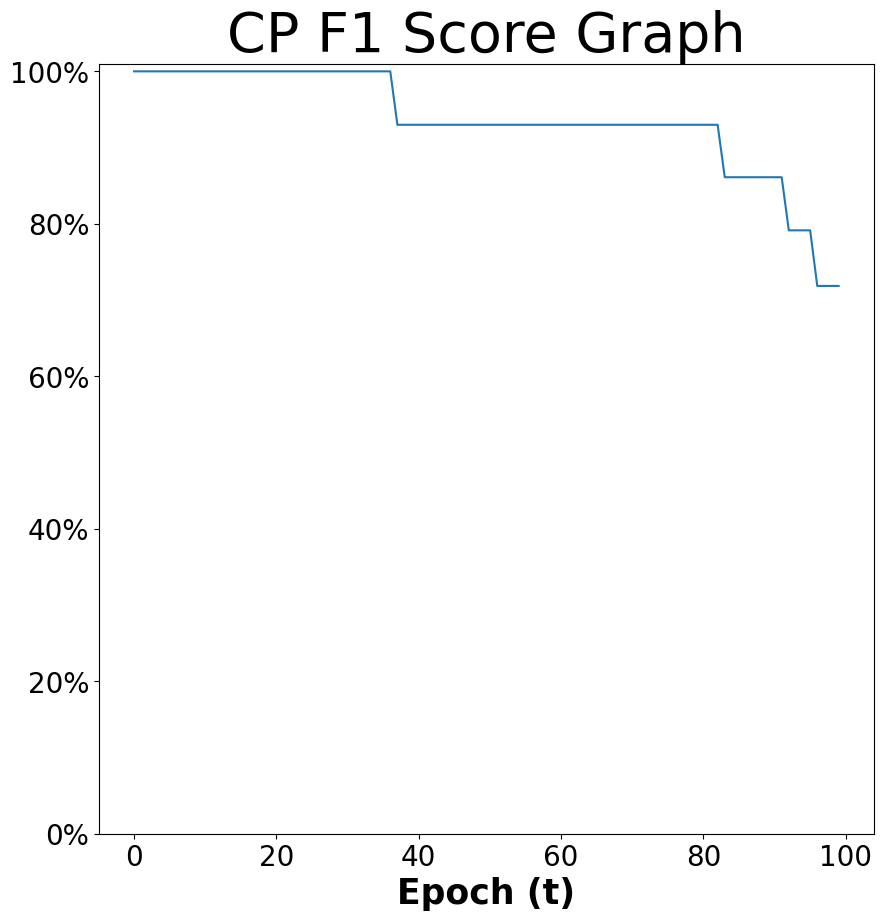

In [24]:
save_figs(cp_glvq_acc, experiment, "CP", learning_rate)

##### DFH

##### 1-step lr = 0.1

In [25]:
learning_rate = 0.1
dfh_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = dfh_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.dual_factor_heuristic,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.3339, Accuracy: 95.24 %, F_1_score: 92.99 %
Epoch: 11, Loss: 0.3262, Accuracy: 95.24 %, F_1_score: 92.99 %
Epoch: 21, Loss: 0.3261, Accuracy: 95.24 %, F_1_score: 92.99 %
Epoch: 31, Loss: 0.3262, Accuracy: 95.24 %, F_1_score: 92.99 %
Epoch: 41, Loss: 0.3261, Accuracy: 95.24 %, F_1_score: 92.99 %
Epoch: 51, Loss: 0.3261, Accuracy: 95.24 %, F_1_score: 92.99 %
Epoch: 61, Loss: 0.3263, Accuracy: 95.24 %, F_1_score: 92.99 %
Epoch: 71, Loss: 0.3262, Accuracy: 95.24 %, F_1_score: 92.99 %
Epoch: 81, Loss: 0.3260, Accuracy: 95.24 %, F_1_score: 92.99 %
Epoch: 91, Loss: 0.3260, Accuracy: 95.24 %, F_1_score: 92.99 %


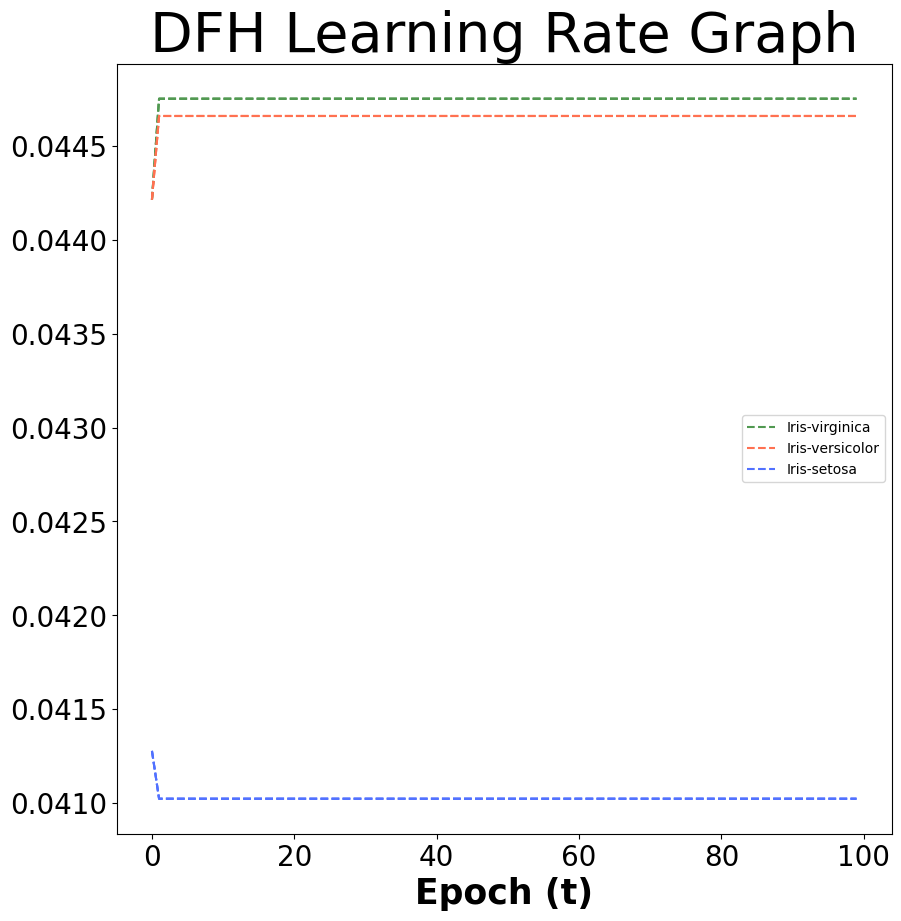

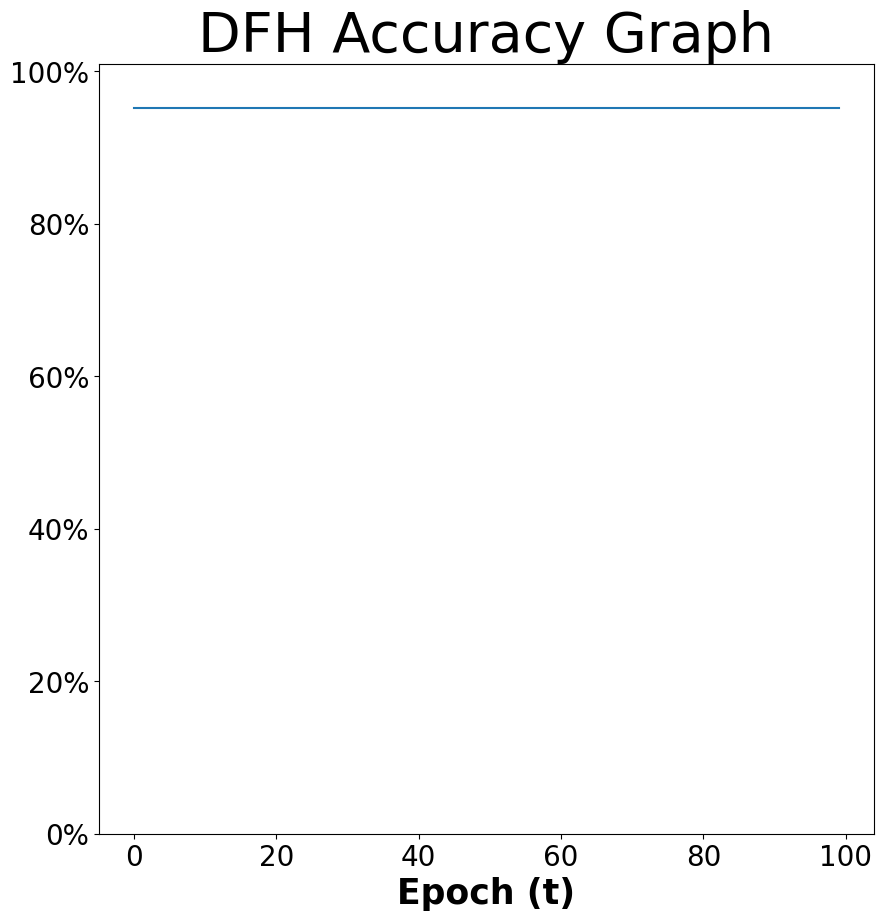

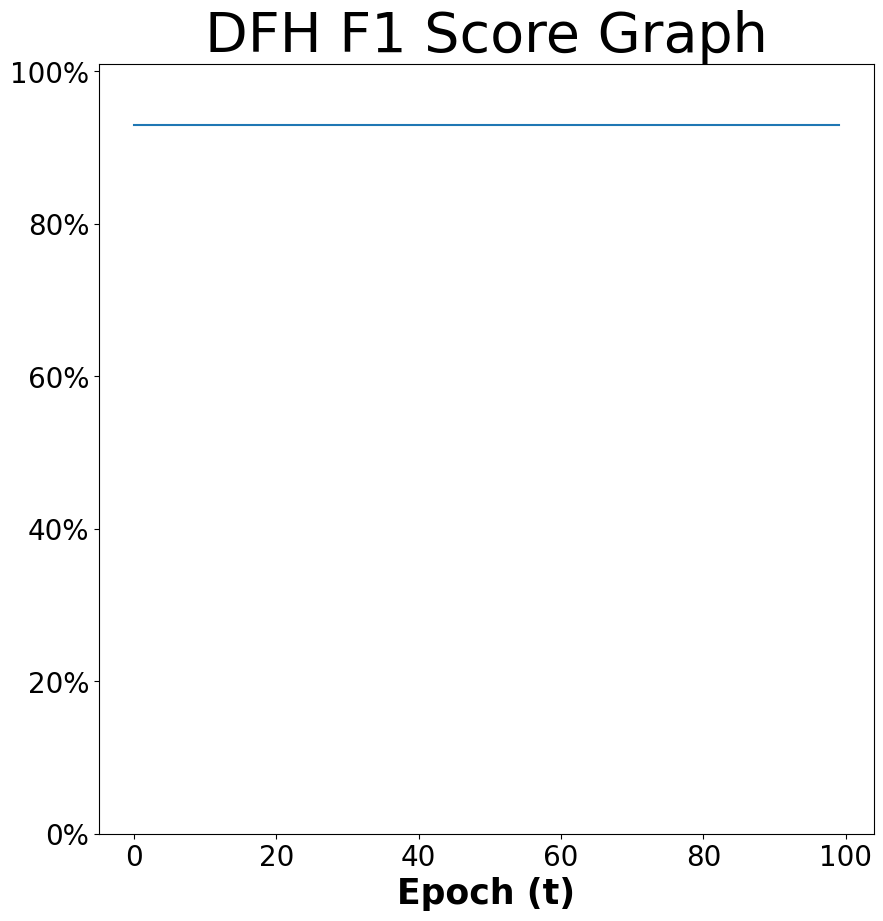

In [26]:
save_figs(dfh_glvq_acc, experiment, "DFH", learning_rate)

##### 2-step lr = 0.03

In [27]:
learning_rate = 0.03
dfh_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = dfh_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.dual_factor_heuristic,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.3382, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 11, Loss: 0.3219, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 21, Loss: 0.3217, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 31, Loss: 0.3221, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 41, Loss: 0.3221, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 51, Loss: 0.3221, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 61, Loss: 0.3221, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 71, Loss: 0.3217, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 81, Loss: 0.3218, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 91, Loss: 0.3221, Accuracy: 100.00 %, F_1_score: 100.00 %


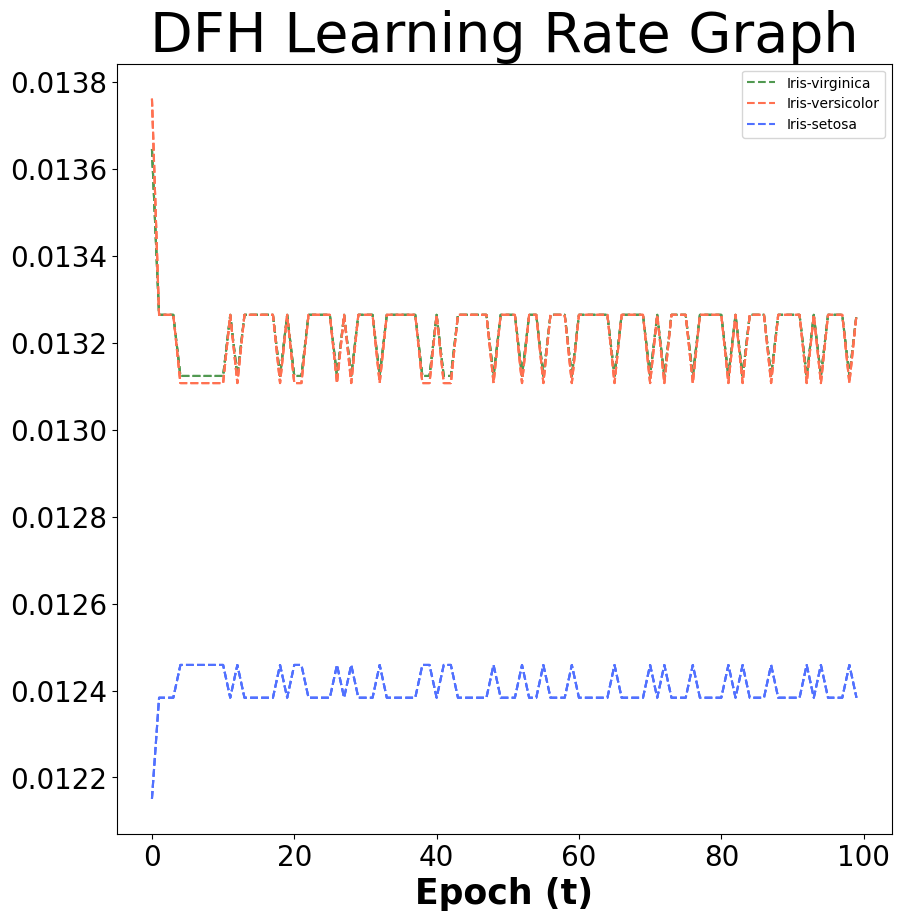

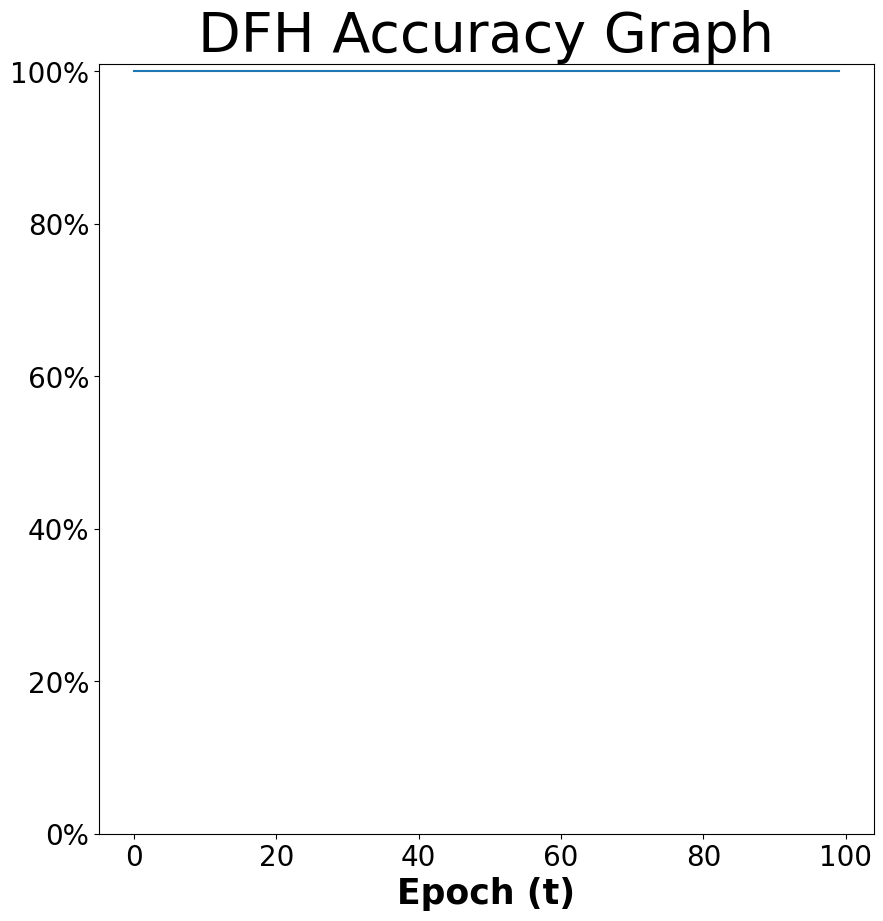

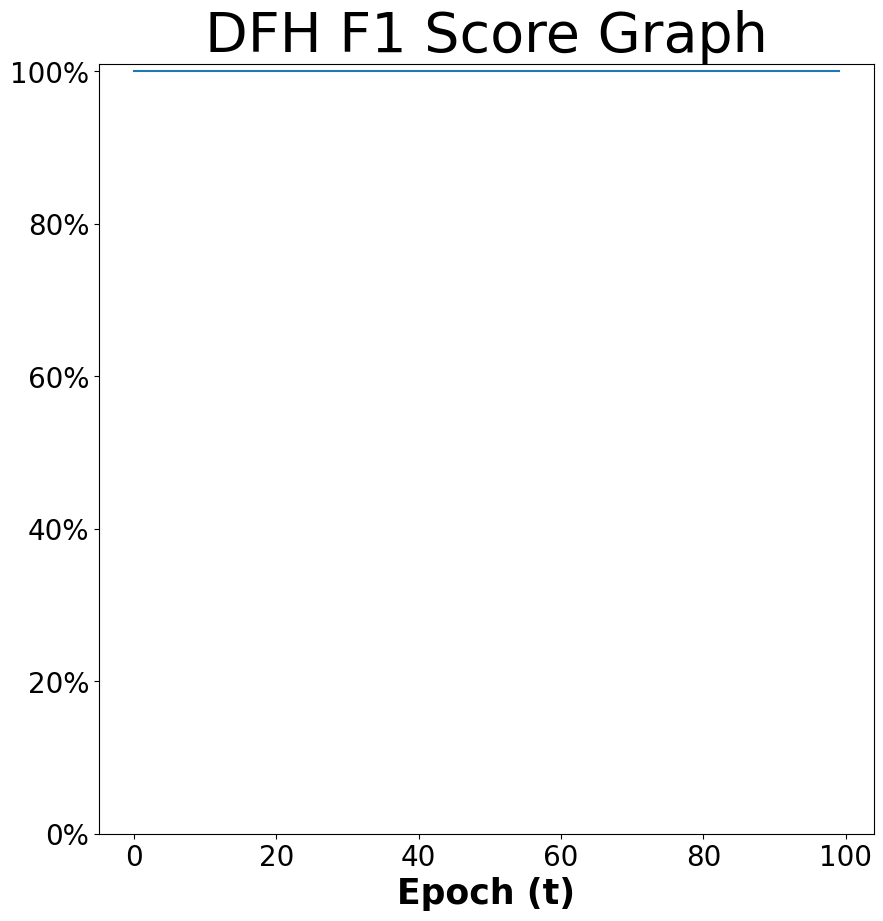

In [28]:
save_figs(dfh_glvq_acc, experiment, "DFH", learning_rate)

##### 3-step lr = 0.01

In [29]:
learning_rate = 0.01
dfh_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = dfh_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.dual_factor_heuristic,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.3439, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 11, Loss: 0.3216, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 21, Loss: 0.3208, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 31, Loss: 0.3206, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 41, Loss: 0.3206, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 51, Loss: 0.3205, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 61, Loss: 0.3206, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 71, Loss: 0.3205, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 81, Loss: 0.3205, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 91, Loss: 0.3205, Accuracy: 100.00 %, F_1_score: 100.00 %


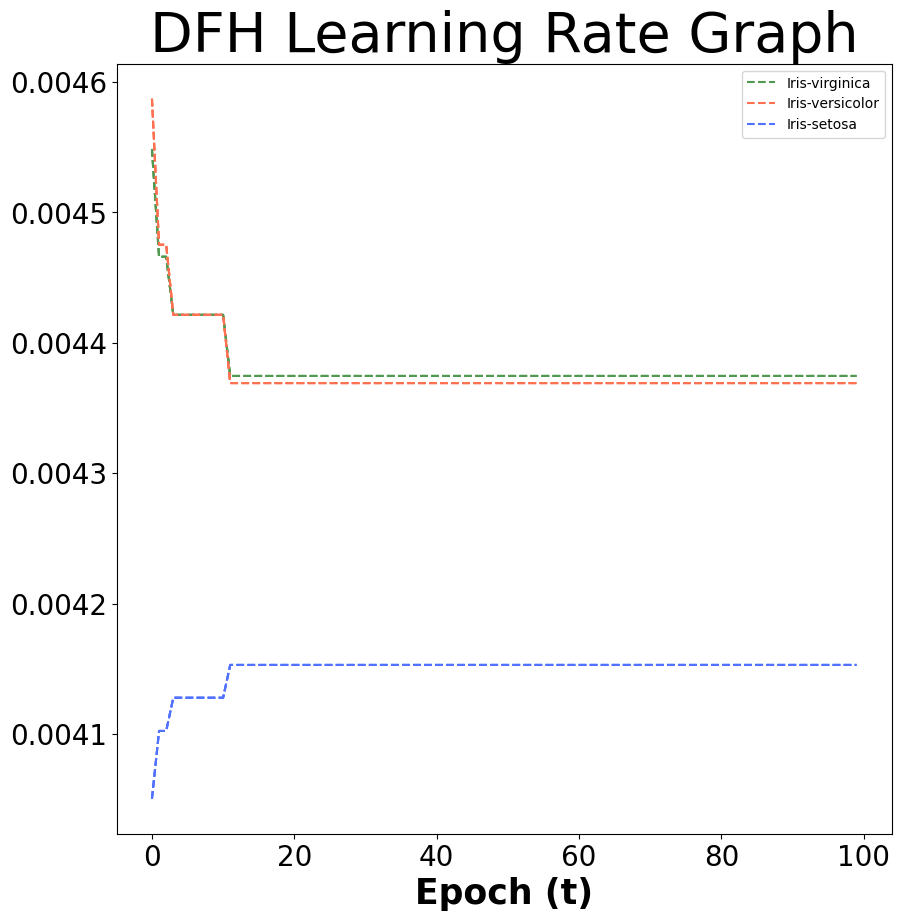

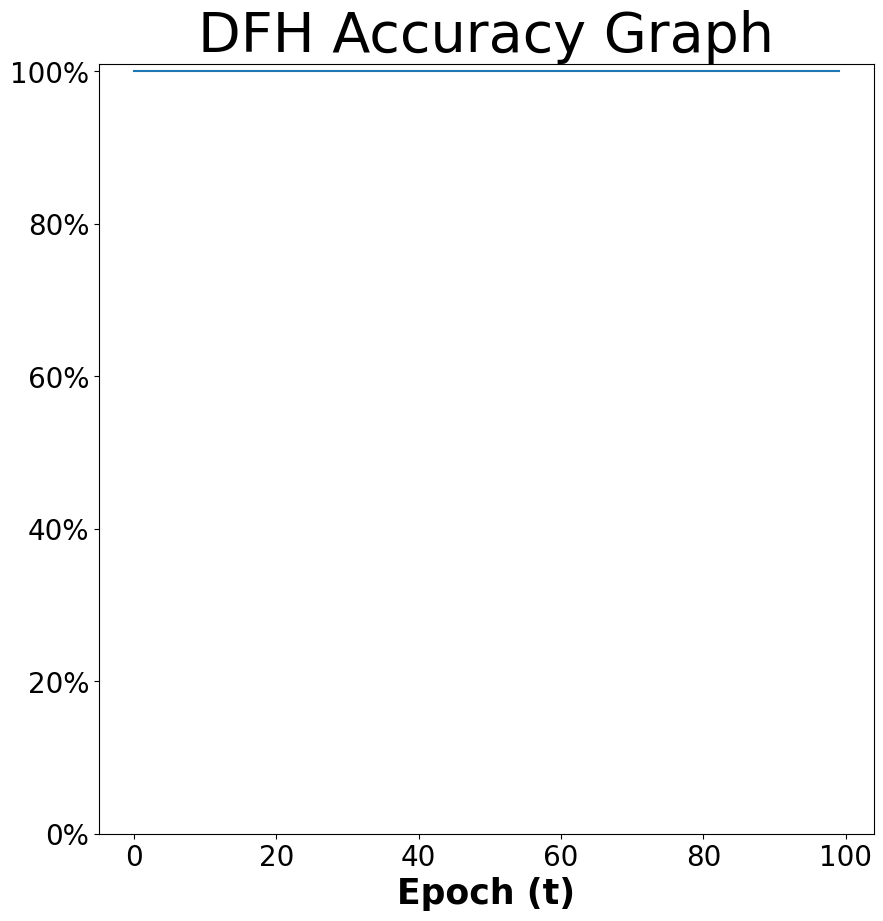

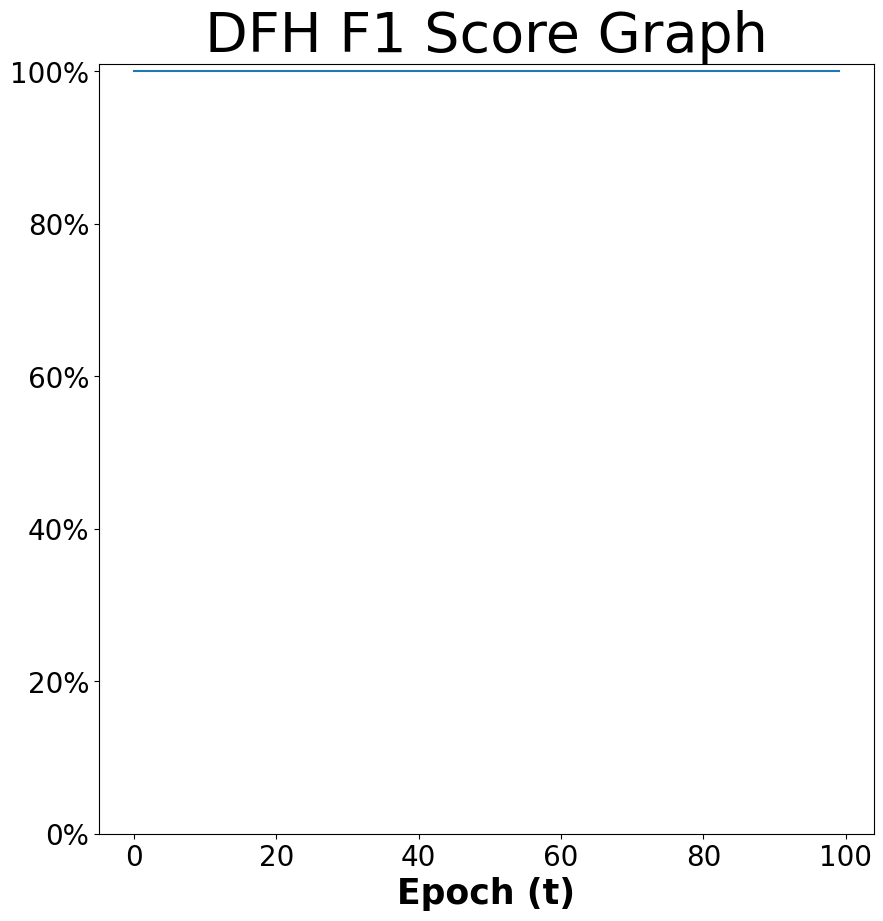

In [30]:
save_figs(dfh_glvq_acc, experiment, "DFH", learning_rate)

##### MS

##### 1-step lr = 0.1

In [31]:
learning_rate = 0.1
ms_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = ms_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.middle_symmetry,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.3336, Accuracy: 95.24 %, F_1_score: 92.99 %
Epoch: 11, Loss: 0.3280, Accuracy: 95.24 %, F_1_score: 92.99 %
Epoch: 21, Loss: 0.3279, Accuracy: 95.24 %, F_1_score: 92.99 %
Epoch: 31, Loss: 0.3282, Accuracy: 95.24 %, F_1_score: 92.99 %
Epoch: 41, Loss: 0.3282, Accuracy: 95.24 %, F_1_score: 92.99 %
Epoch: 51, Loss: 0.3282, Accuracy: 95.24 %, F_1_score: 92.99 %
Epoch: 61, Loss: 0.3282, Accuracy: 95.24 %, F_1_score: 92.99 %
Epoch: 71, Loss: 0.3282, Accuracy: 95.24 %, F_1_score: 92.99 %
Epoch: 81, Loss: 0.3282, Accuracy: 95.24 %, F_1_score: 92.99 %
Epoch: 91, Loss: 0.3281, Accuracy: 95.24 %, F_1_score: 92.99 %


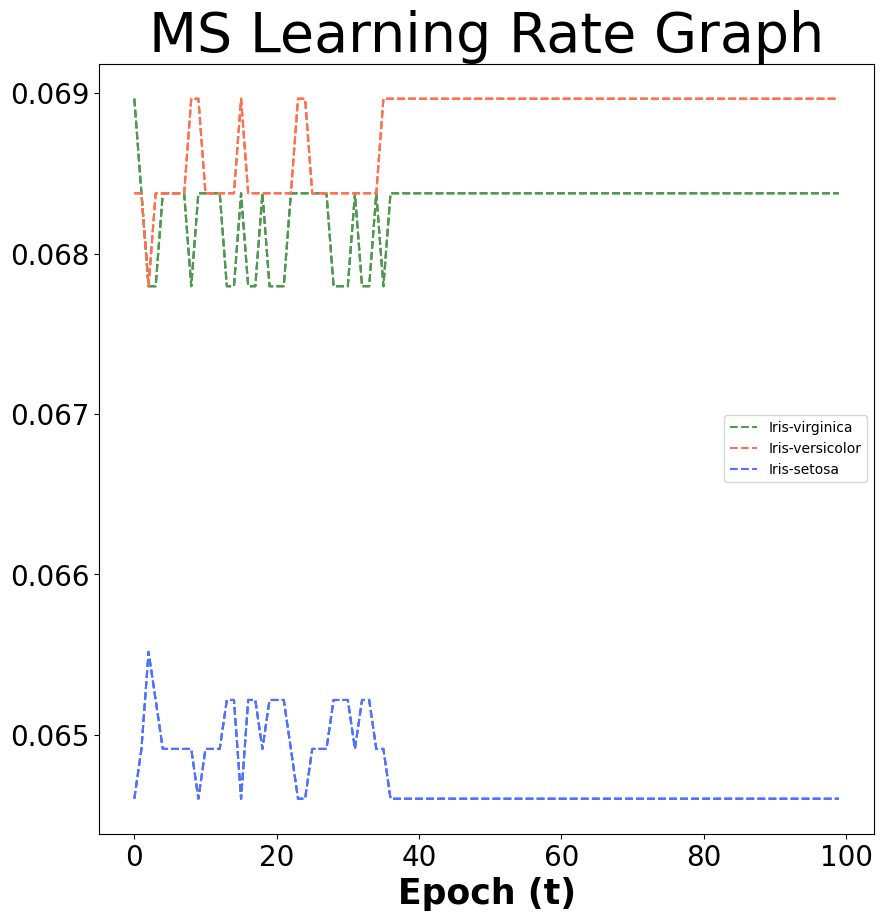

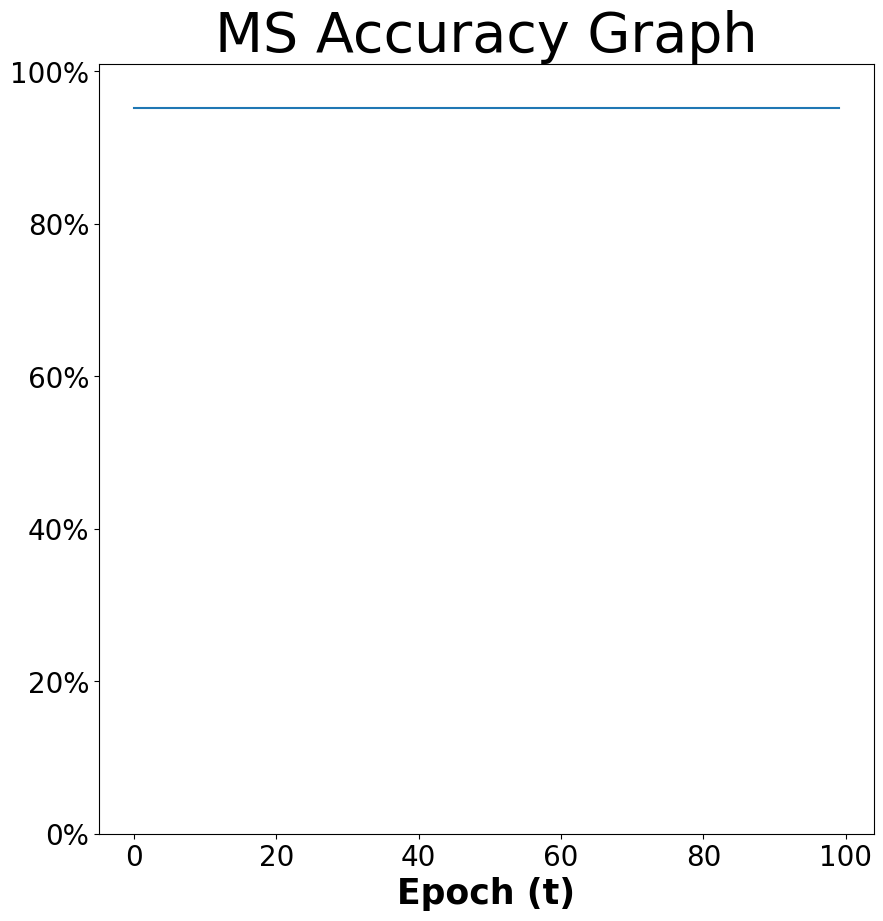

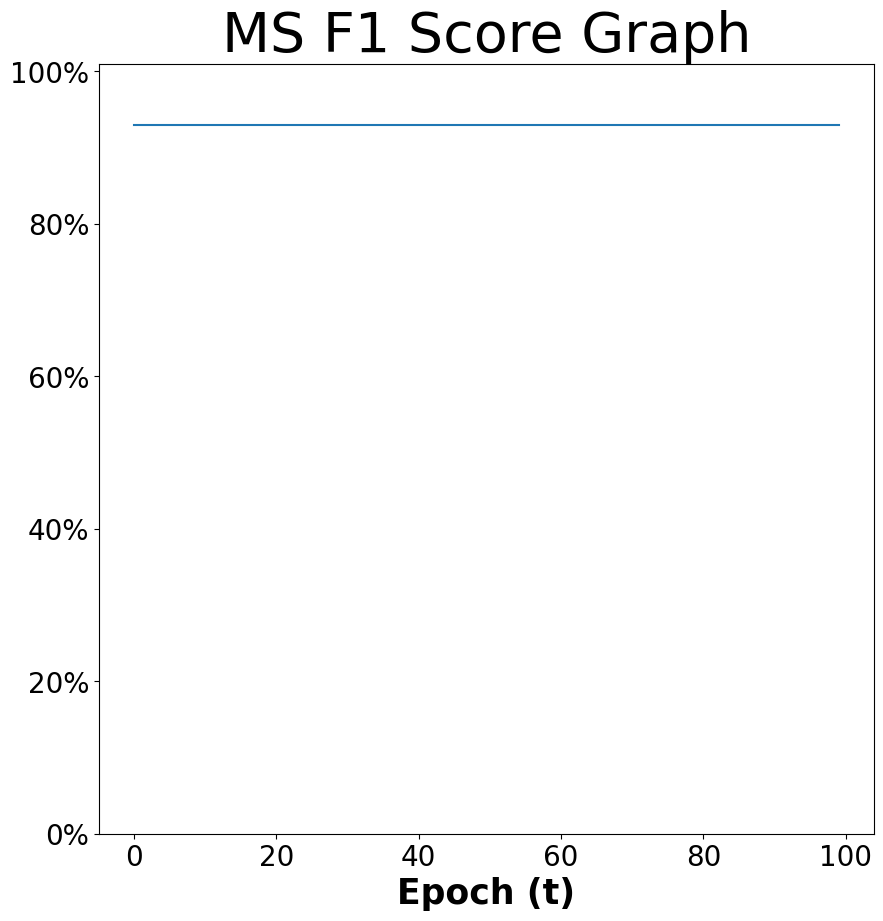

In [32]:
save_figs(ms_glvq_acc, experiment, "MS", learning_rate)

##### 2-step lr = 0.03

In [33]:
learning_rate = 0.03
ms_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = ms_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.middle_symmetry,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.3361, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 11, Loss: 0.3229, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 21, Loss: 0.3228, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 31, Loss: 0.3225, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 41, Loss: 0.3198, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 51, Loss: 0.3194, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 61, Loss: 0.3193, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 71, Loss: 0.3163, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 81, Loss: 0.3163, Accuracy: 95.24 %, F_1_score: 92.99 %
Epoch: 91, Loss: 0.3163, Accuracy: 100.00 %, F_1_score: 100.00 %


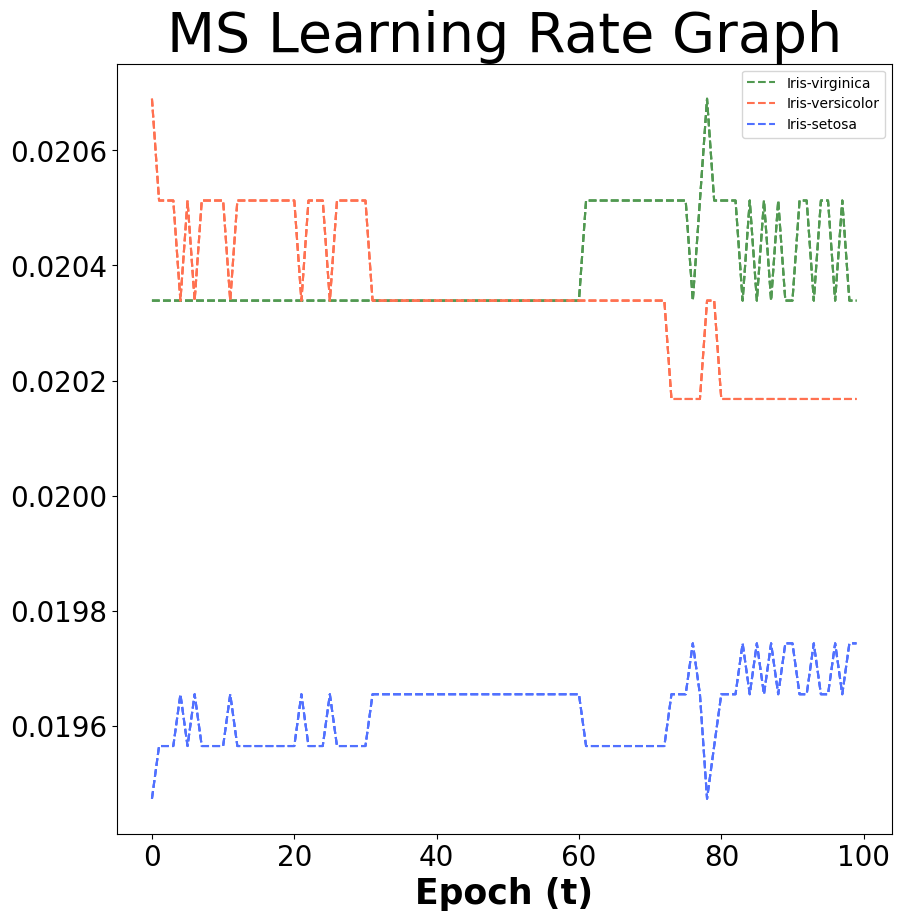

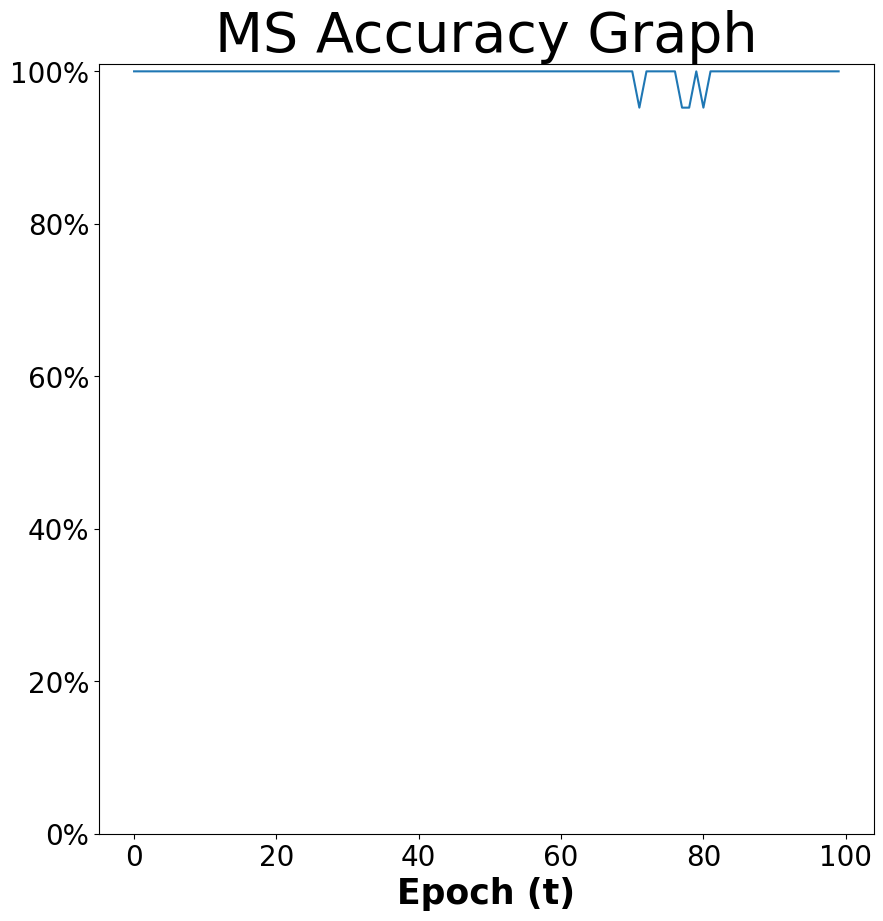

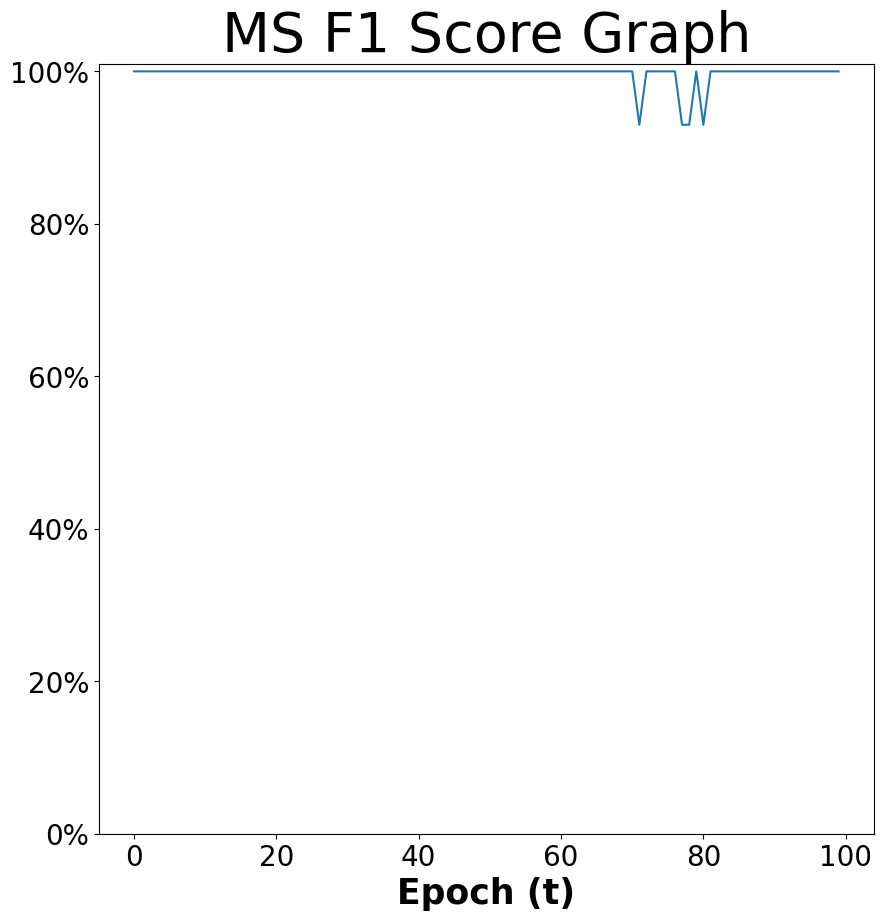

In [34]:
save_figs(ms_glvq_acc, experiment, "MS", learning_rate)

##### 3-step lr = 0.01

In [35]:
learning_rate = 0.01
ms_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = ms_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.middle_symmetry,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.3415, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 11, Loss: 0.3212, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 21, Loss: 0.3209, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 31, Loss: 0.3209, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 41, Loss: 0.3209, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 51, Loss: 0.3209, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 61, Loss: 0.3209, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 71, Loss: 0.3209, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 81, Loss: 0.3209, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 91, Loss: 0.3209, Accuracy: 100.00 %, F_1_score: 100.00 %


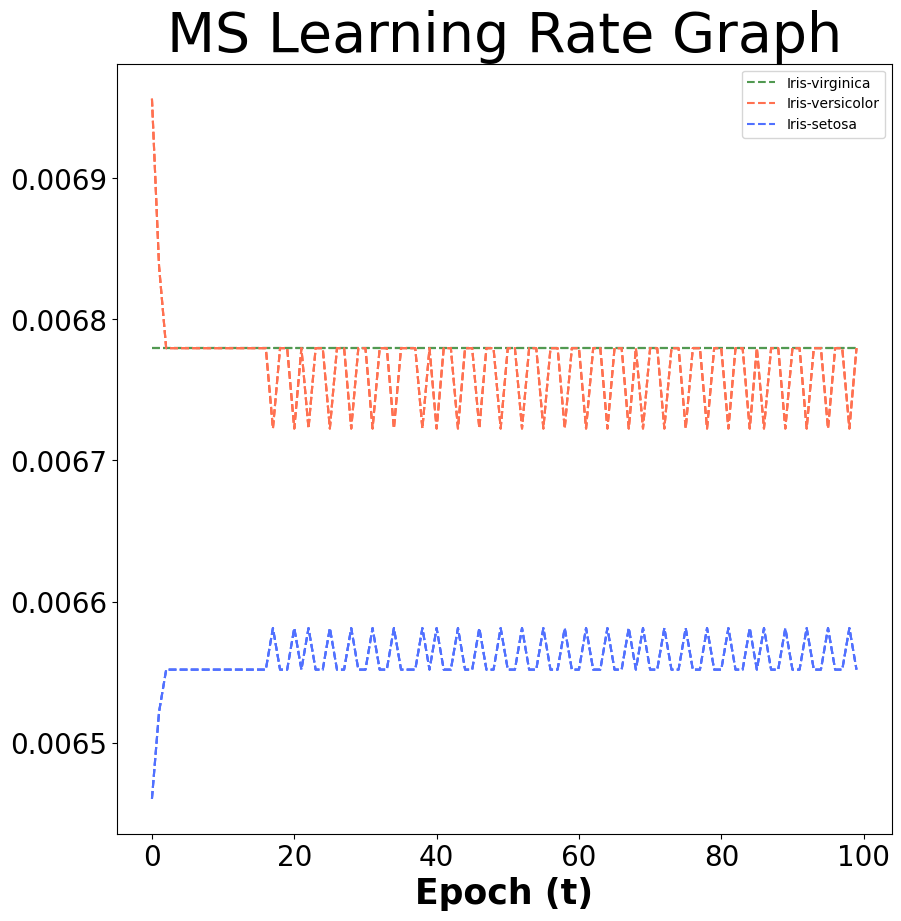

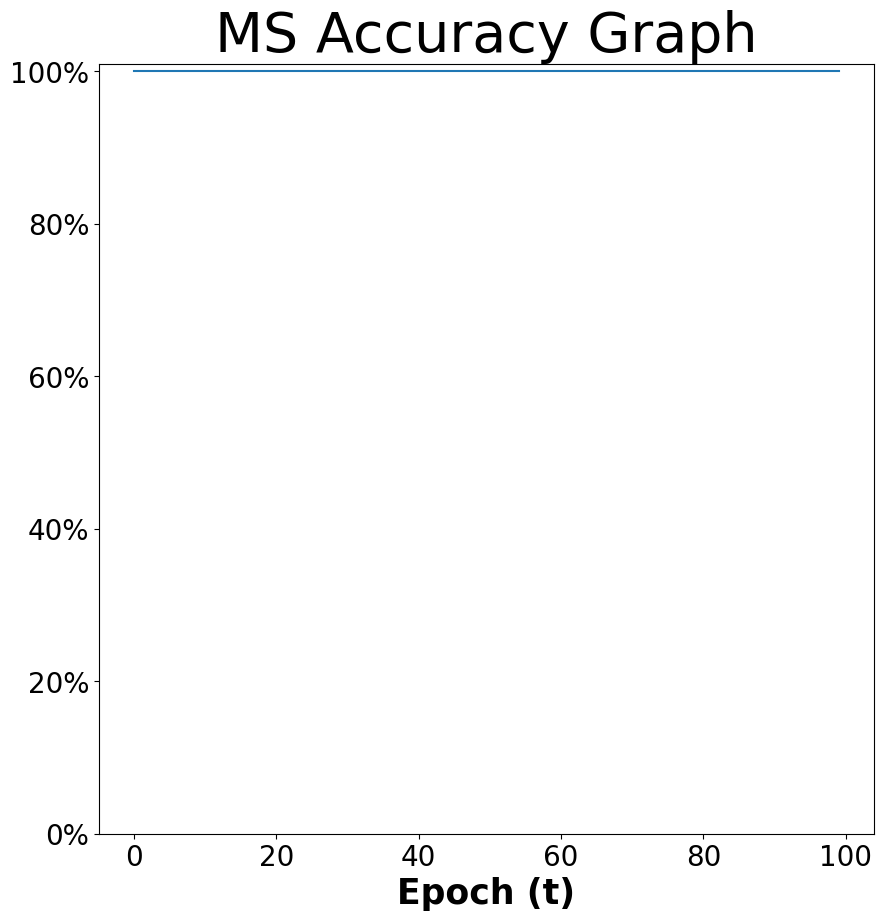

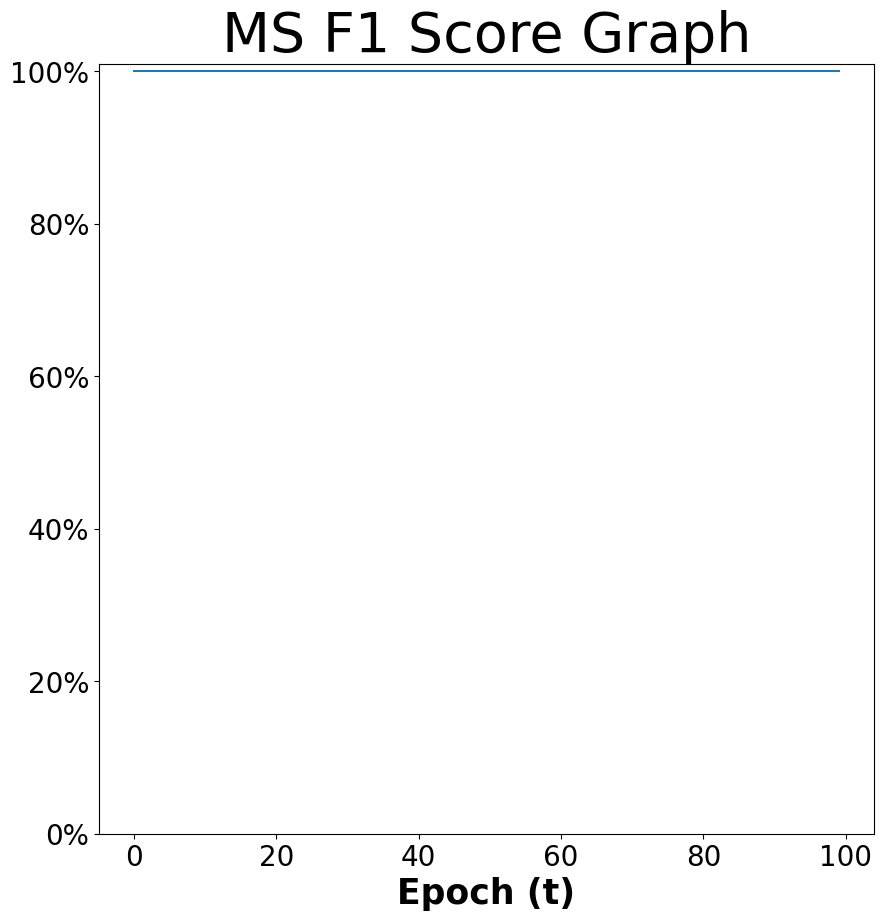

In [36]:
save_figs(ms_glvq_acc, experiment, "MS", learning_rate)

##### LS

##### 1-step lr = 0.1

In [37]:
learning_rate = 0.1
ls_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = ls_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.loose_symmetry,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.3340, Accuracy: 95.24 %, F_1_score: 92.99 %
Epoch: 11, Loss: 0.3252, Accuracy: 95.24 %, F_1_score: 92.99 %
Epoch: 21, Loss: 0.3252, Accuracy: 95.24 %, F_1_score: 92.99 %
Epoch: 31, Loss: 0.3254, Accuracy: 95.24 %, F_1_score: 92.99 %
Epoch: 41, Loss: 0.3254, Accuracy: 95.24 %, F_1_score: 92.99 %
Epoch: 51, Loss: 0.3253, Accuracy: 95.24 %, F_1_score: 92.99 %
Epoch: 61, Loss: 0.3252, Accuracy: 95.24 %, F_1_score: 92.99 %
Epoch: 71, Loss: 0.3253, Accuracy: 95.24 %, F_1_score: 92.99 %
Epoch: 81, Loss: 0.3252, Accuracy: 95.24 %, F_1_score: 92.99 %
Epoch: 91, Loss: 0.3252, Accuracy: 95.24 %, F_1_score: 92.99 %


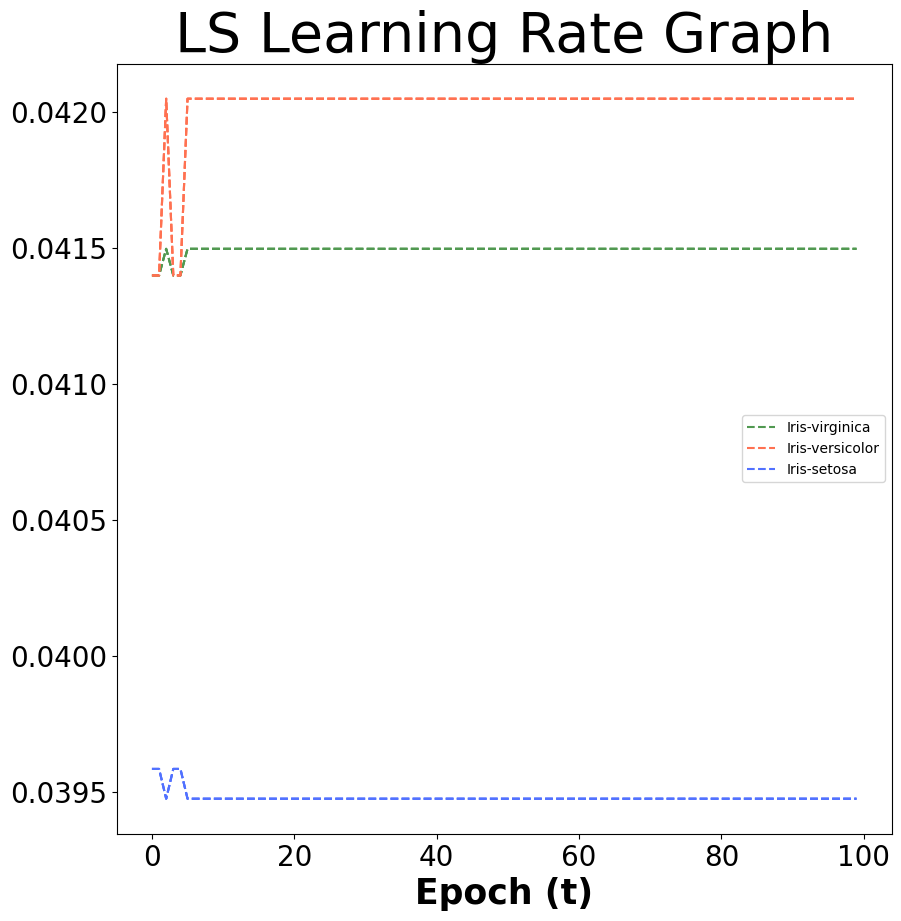

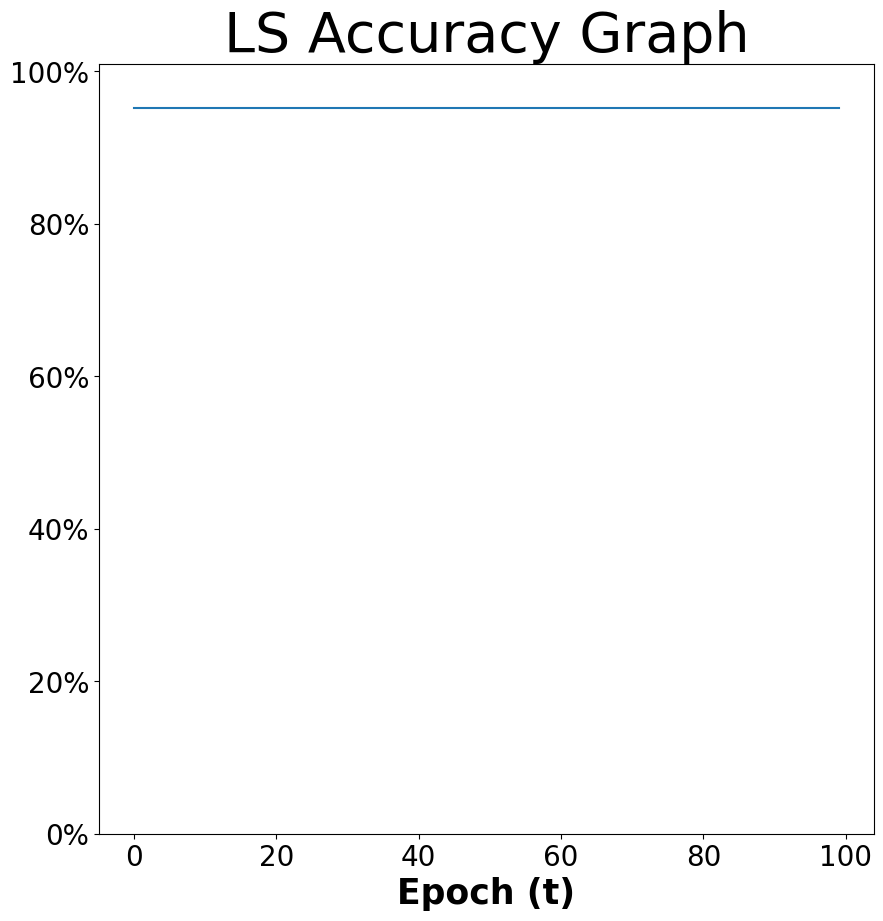

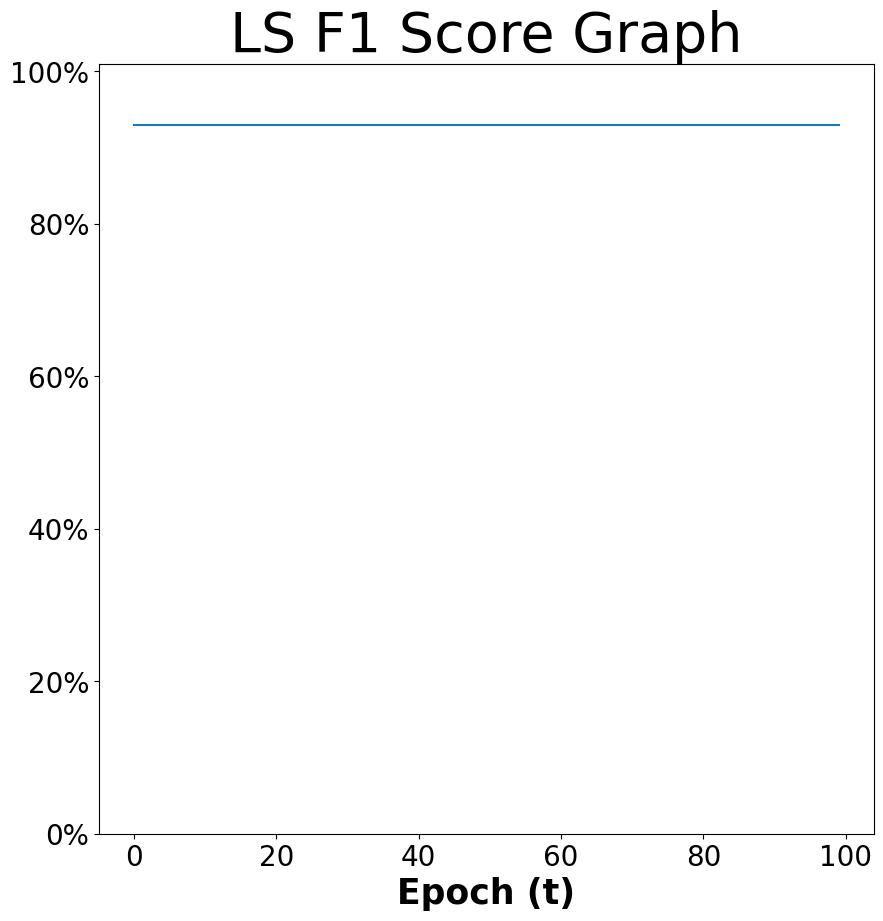

In [38]:
save_figs(ls_glvq_acc, experiment, "LS", learning_rate)

##### 2-step lr = 0.03

In [39]:
learning_rate = 0.03
ls_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = ls_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.loose_symmetry,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.3381, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 11, Loss: 0.3217, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 21, Loss: 0.3215, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 31, Loss: 0.3214, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 41, Loss: 0.3215, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 51, Loss: 0.3214, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 61, Loss: 0.3215, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 71, Loss: 0.3213, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 81, Loss: 0.3214, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 91, Loss: 0.3205, Accuracy: 100.00 %, F_1_score: 100.00 %


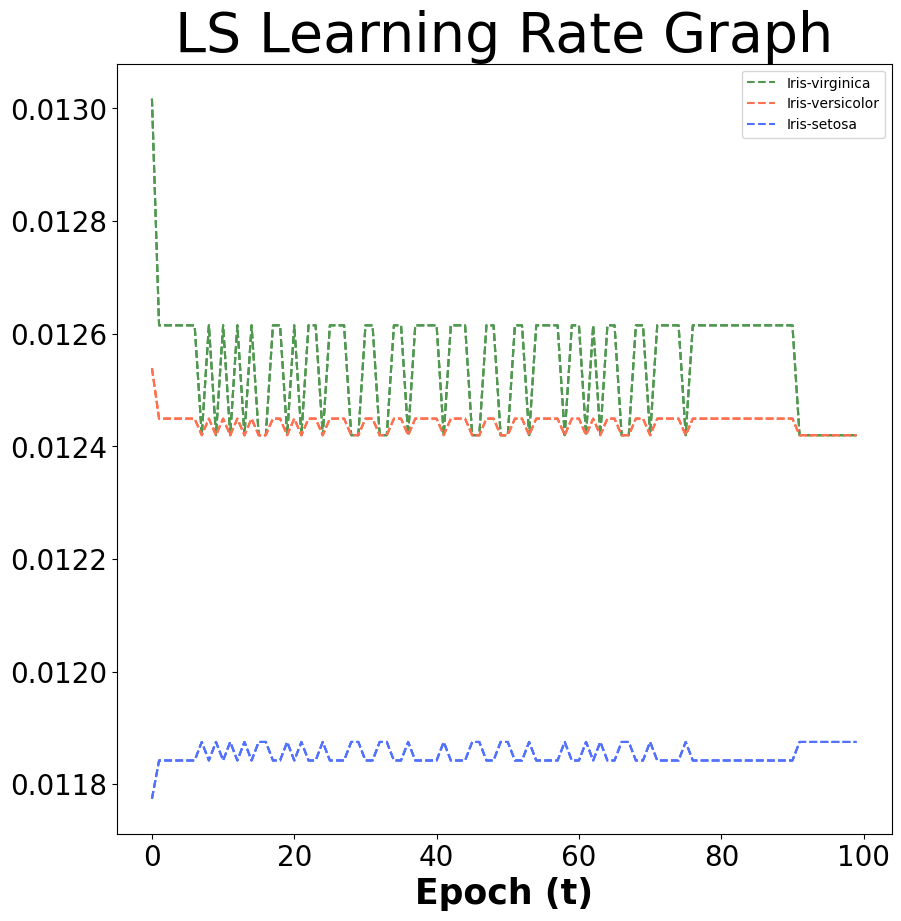

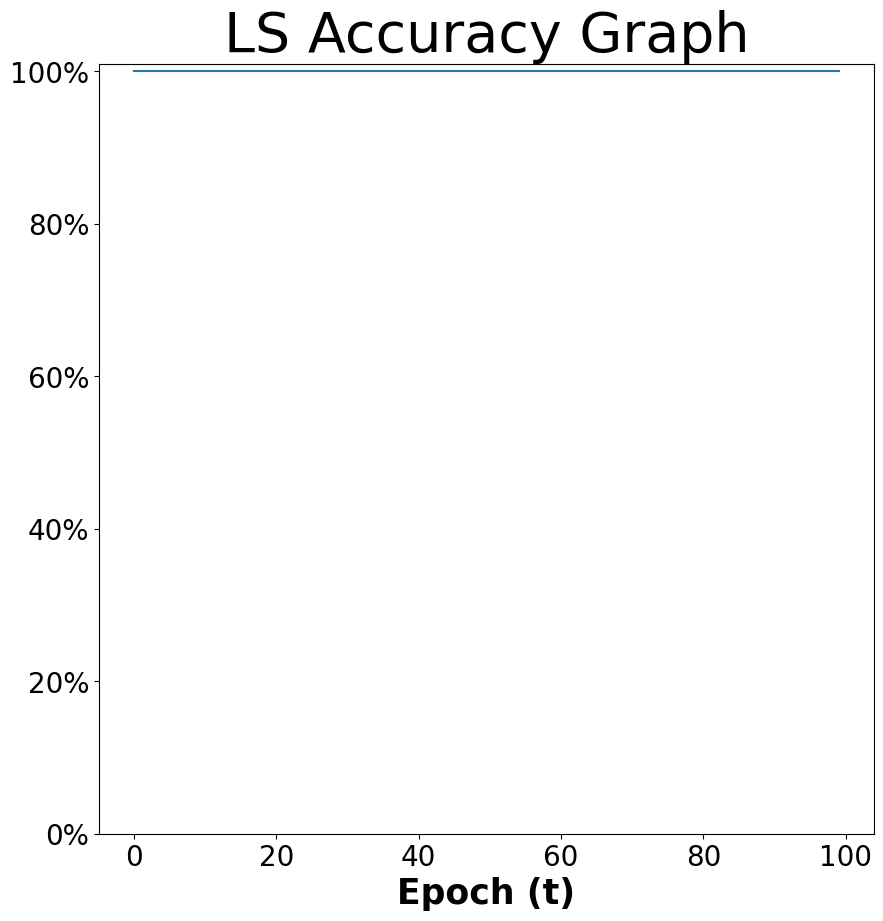

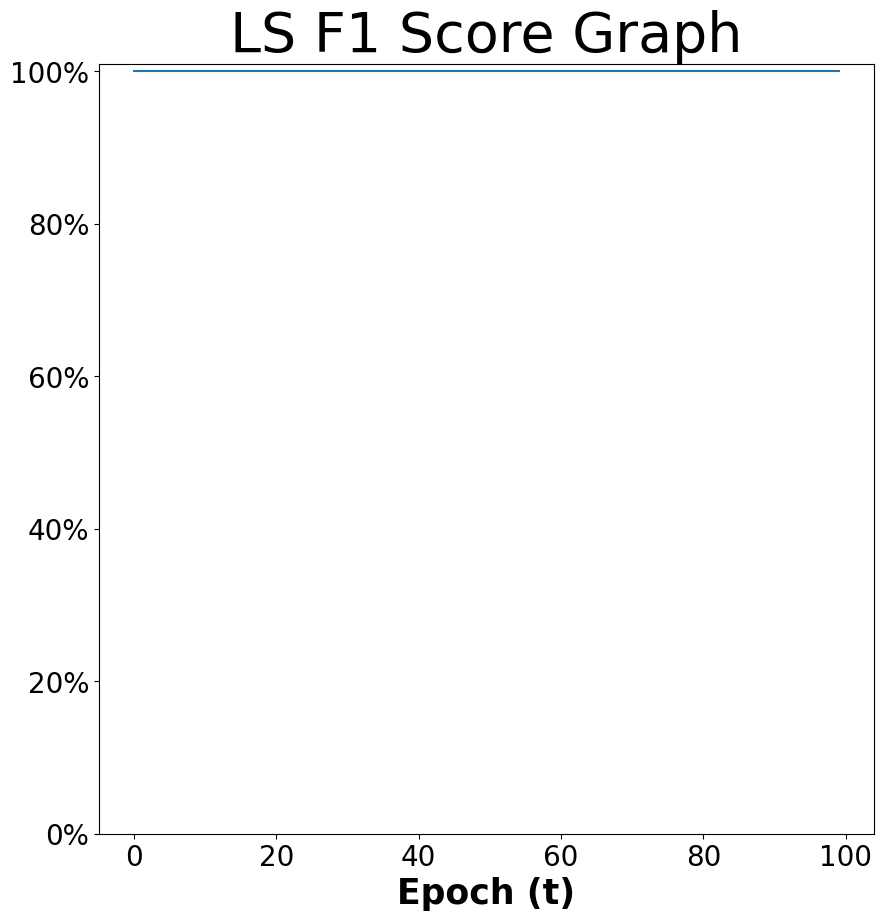

In [40]:
save_figs(ls_glvq_acc, experiment, "LS", learning_rate)

##### 3-step lr = 0.01

In [41]:
learning_rate = 0.01
ls_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = ls_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.loose_symmetry,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.3443, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 11, Loss: 0.3213, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 21, Loss: 0.3203, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 31, Loss: 0.3202, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 41, Loss: 0.3201, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 51, Loss: 0.3201, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 61, Loss: 0.3201, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 71, Loss: 0.3201, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 81, Loss: 0.3201, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 91, Loss: 0.3200, Accuracy: 100.00 %, F_1_score: 100.00 %


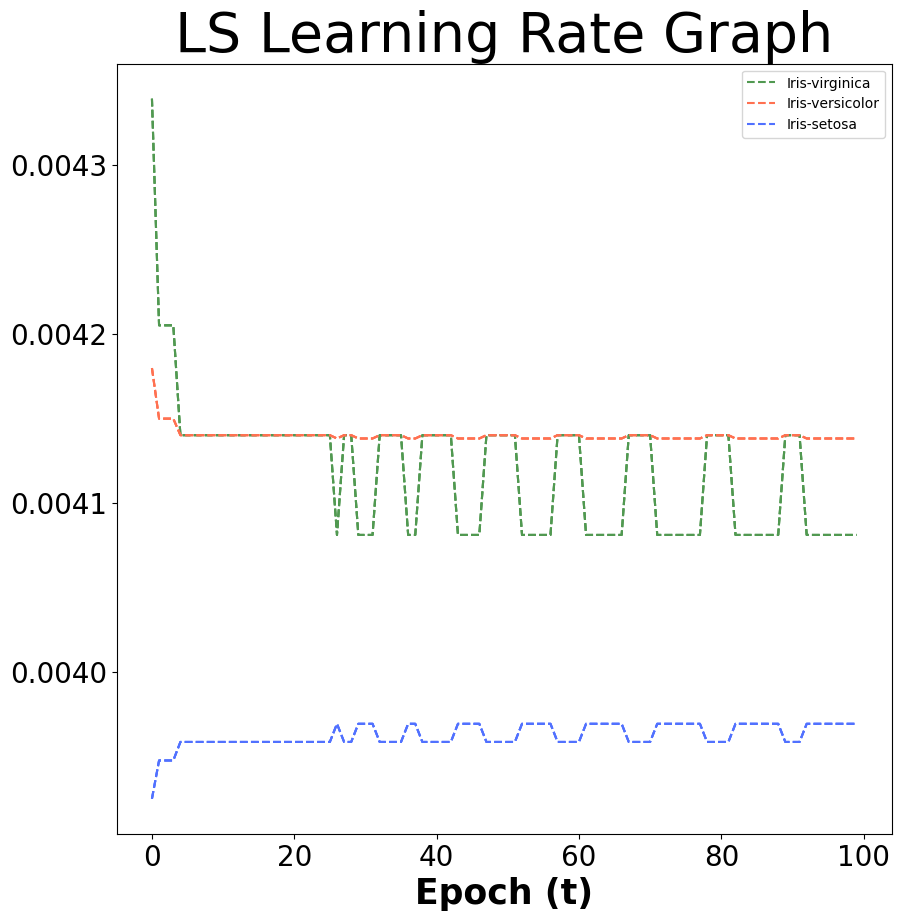

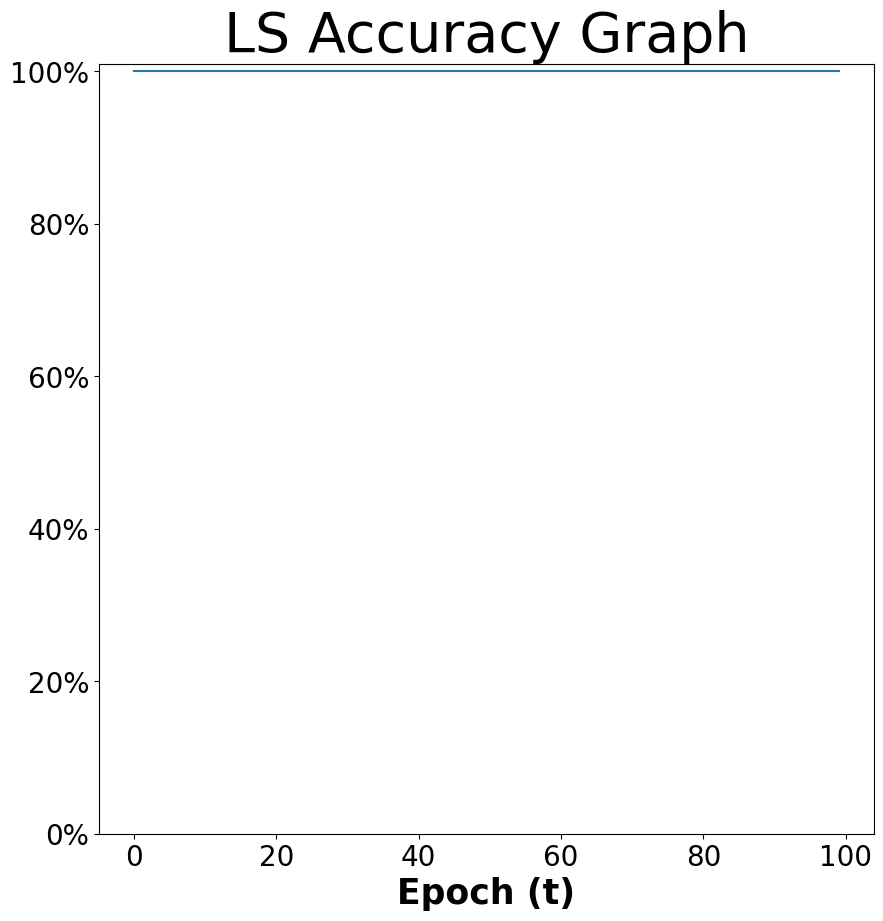

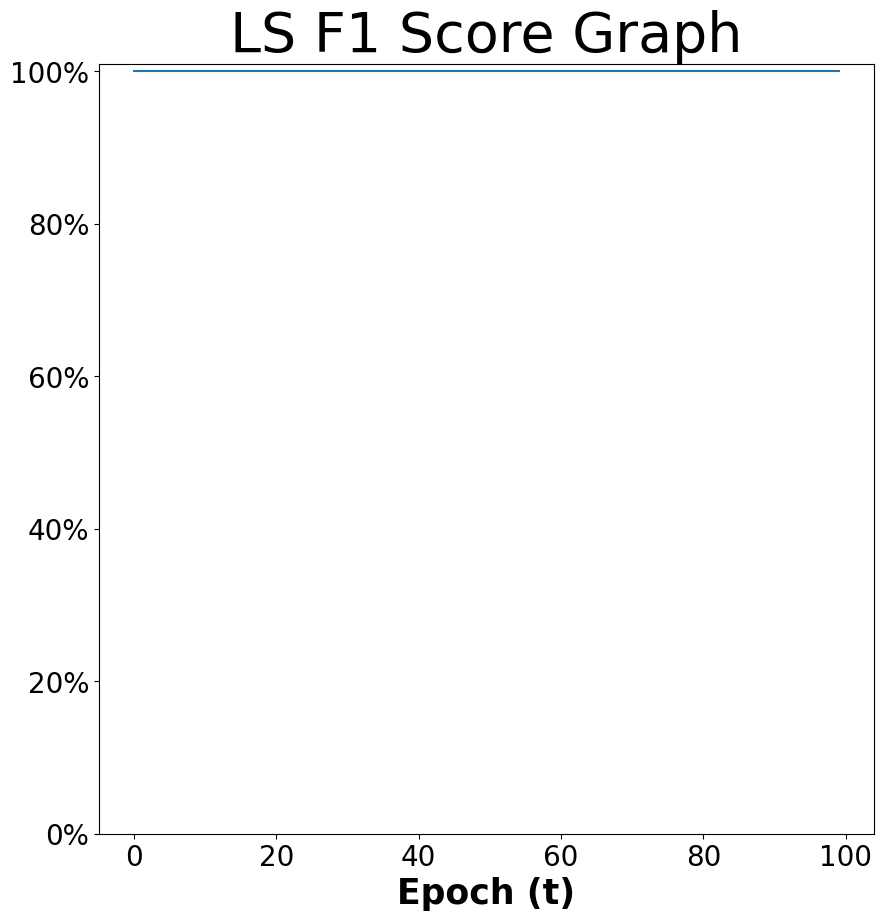

In [42]:
save_figs(ls_glvq_acc, experiment, "LS", learning_rate)

##### LSR

##### 1-step lr = 0.1

In [43]:
learning_rate = 0.1
lsr_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = lsr_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.loose_symmetry_rarity,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.3339, Accuracy: 95.24 %, F_1_score: 92.99 %
Epoch: 11, Loss: 0.3250, Accuracy: 95.24 %, F_1_score: 92.99 %
Epoch: 21, Loss: 0.3253, Accuracy: 95.24 %, F_1_score: 92.99 %
Epoch: 31, Loss: 0.3250, Accuracy: 95.24 %, F_1_score: 92.99 %
Epoch: 41, Loss: 0.3251, Accuracy: 95.24 %, F_1_score: 92.99 %
Epoch: 51, Loss: 0.3253, Accuracy: 95.24 %, F_1_score: 92.99 %
Epoch: 61, Loss: 0.3250, Accuracy: 95.24 %, F_1_score: 92.99 %
Epoch: 71, Loss: 0.3251, Accuracy: 95.24 %, F_1_score: 92.99 %
Epoch: 81, Loss: 0.3253, Accuracy: 95.24 %, F_1_score: 92.99 %
Epoch: 91, Loss: 0.3250, Accuracy: 95.24 %, F_1_score: 92.99 %


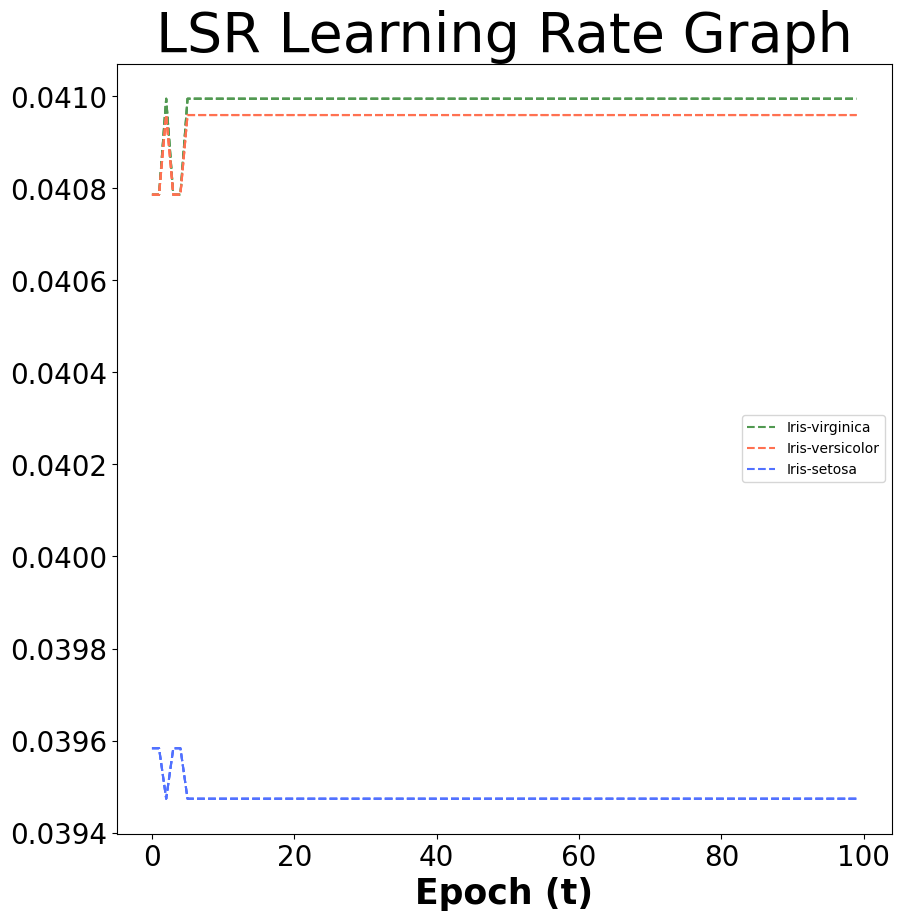

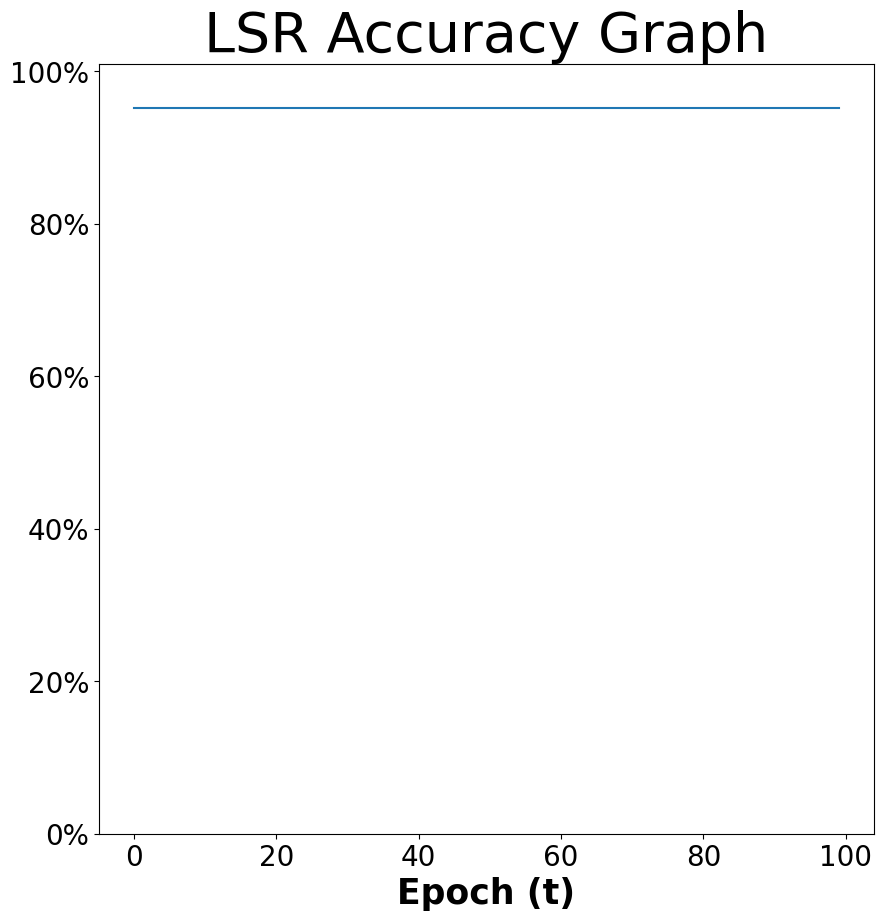

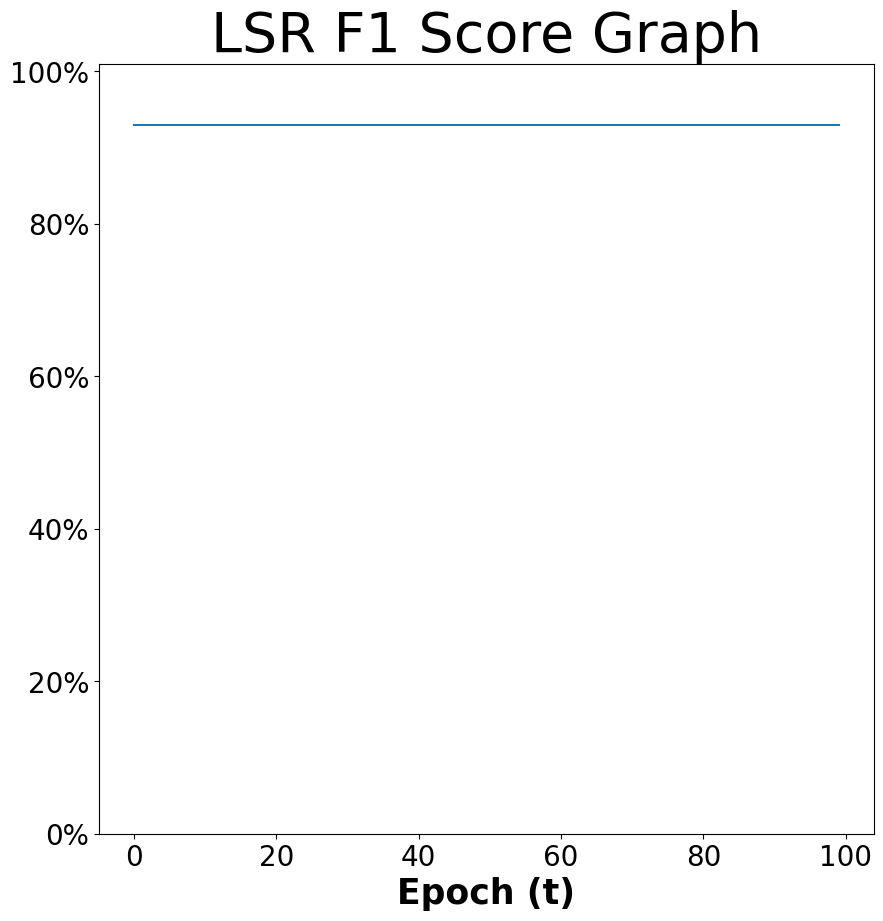

In [44]:
save_figs(lsr_glvq_acc, experiment, "LSR", learning_rate)

##### 2-step lr = 0.03

In [45]:
learning_rate = 0.03
lsr_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = lsr_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.loose_symmetry_rarity,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.3382, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 11, Loss: 0.3218, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 21, Loss: 0.3215, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 31, Loss: 0.3214, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 41, Loss: 0.3213, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 51, Loss: 0.3213, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 61, Loss: 0.3215, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 71, Loss: 0.3215, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 81, Loss: 0.3214, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 91, Loss: 0.3203, Accuracy: 100.00 %, F_1_score: 100.00 %


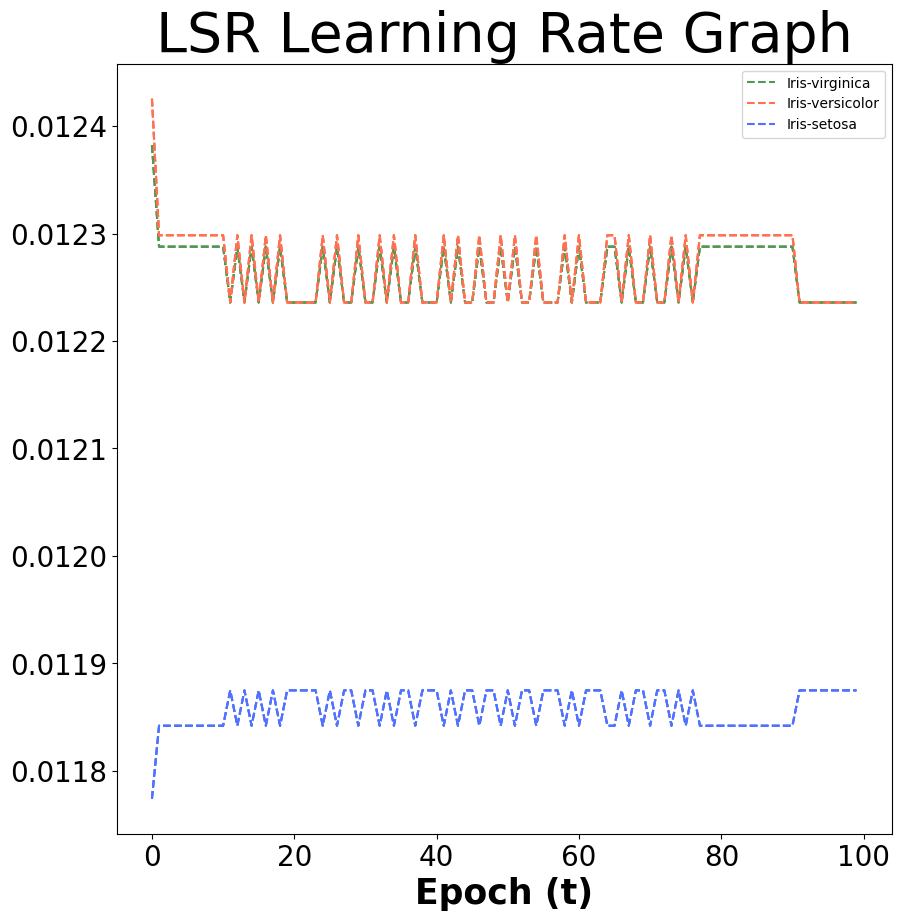

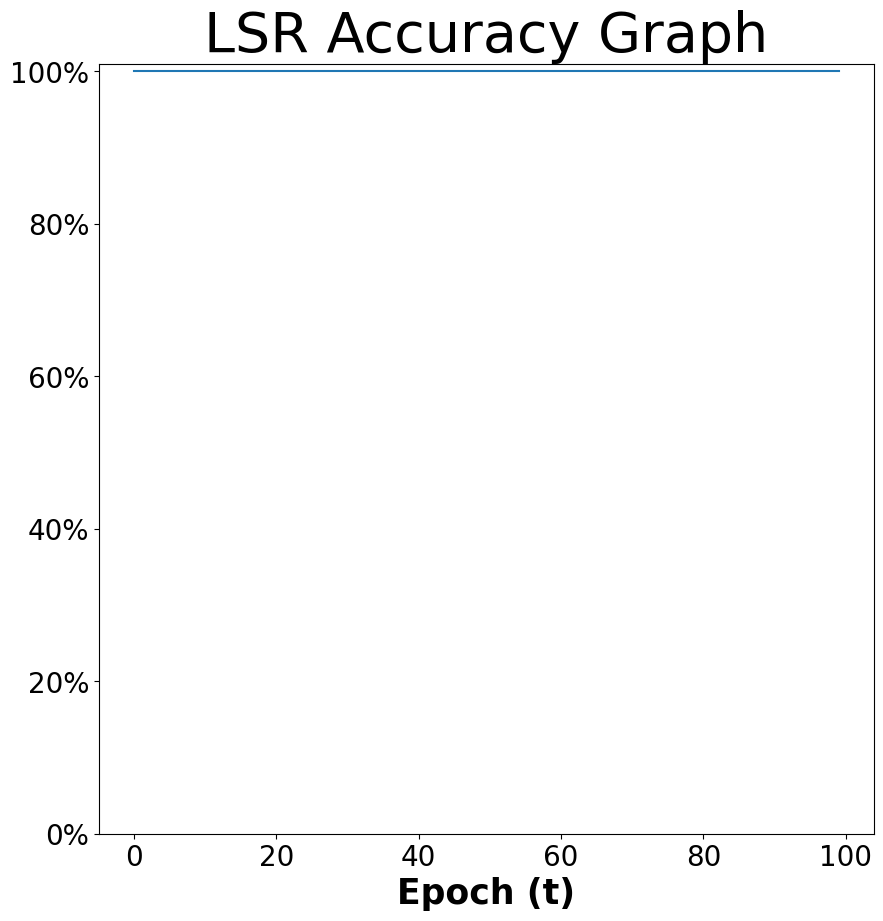

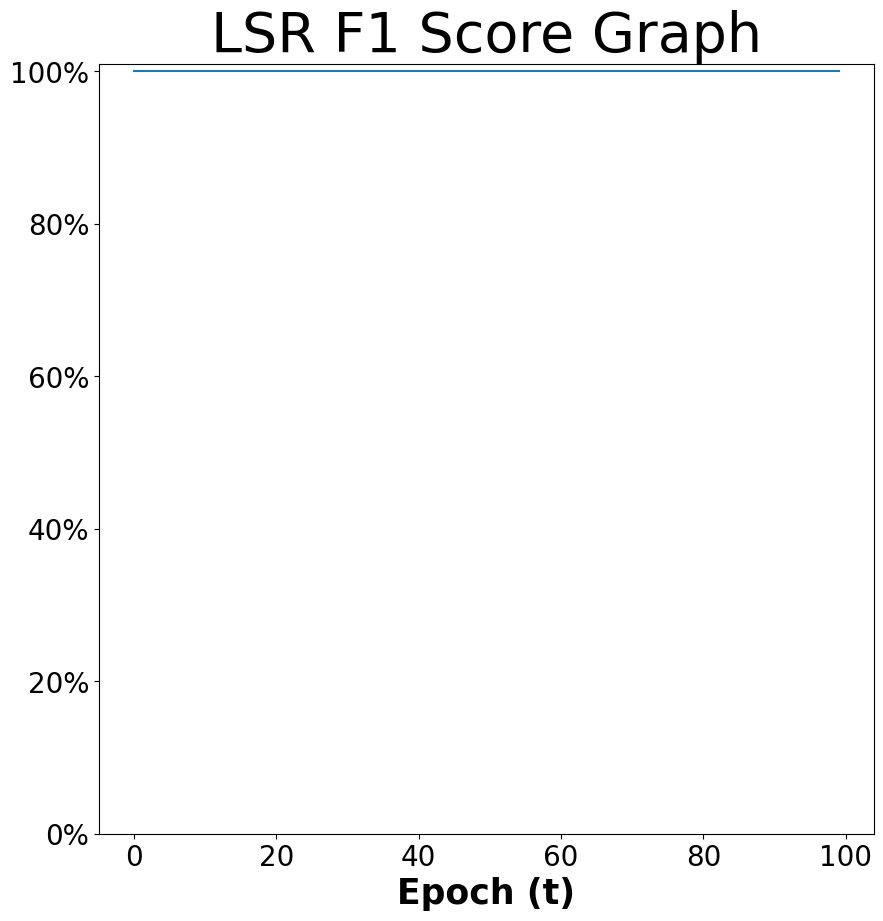

In [46]:
save_figs(lsr_glvq_acc, experiment, "LSR", learning_rate)

##### 3-step lr = 0.01

In [47]:
learning_rate = 0.01
lsr_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = lsr_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.loose_symmetry_rarity,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.3444, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 11, Loss: 0.3213, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 21, Loss: 0.3203, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 31, Loss: 0.3202, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 41, Loss: 0.3201, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 51, Loss: 0.3201, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 61, Loss: 0.3201, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 71, Loss: 0.3201, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 81, Loss: 0.3200, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 91, Loss: 0.3201, Accuracy: 100.00 %, F_1_score: 100.00 %


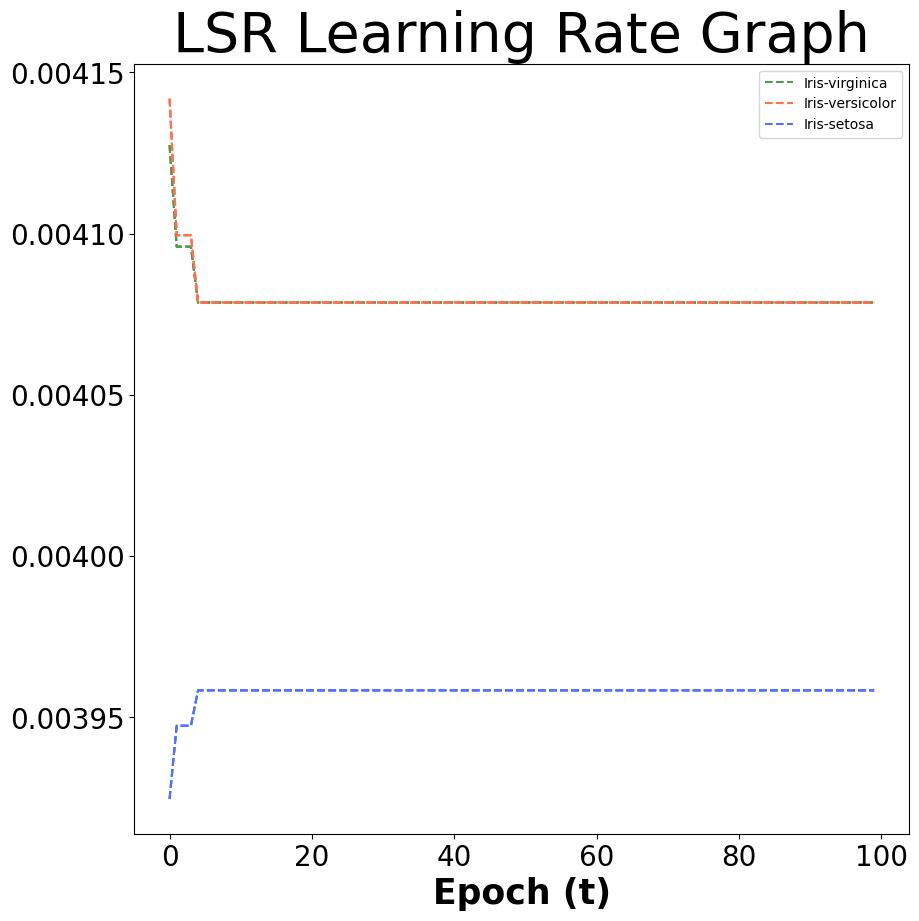

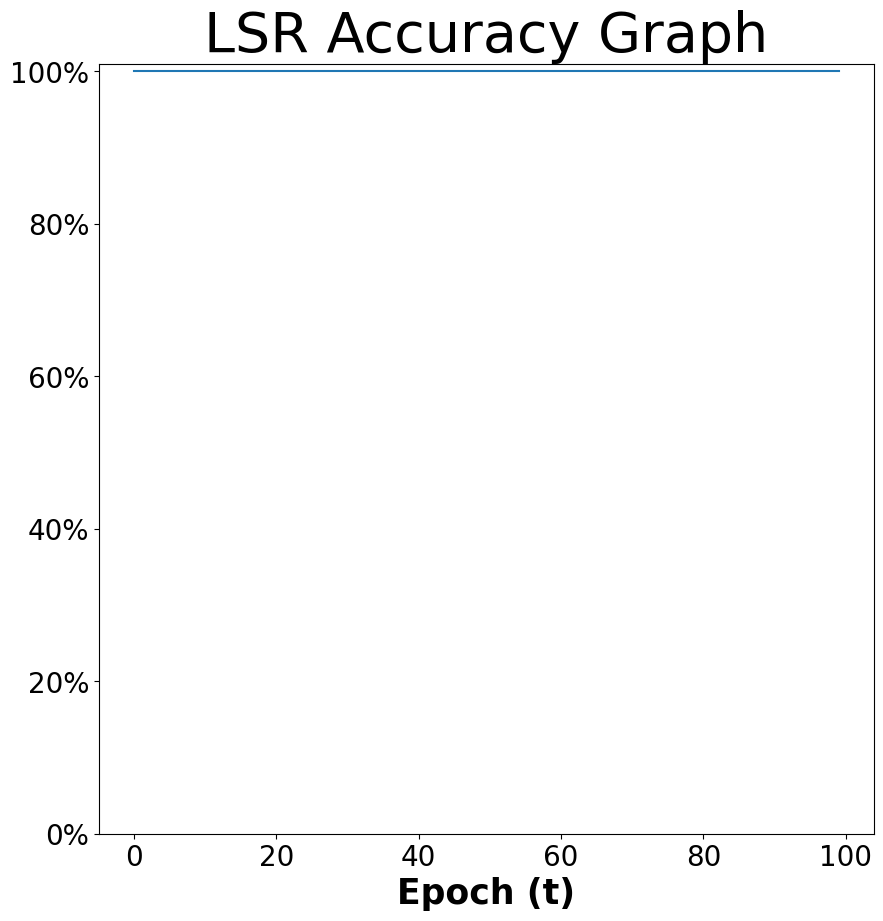

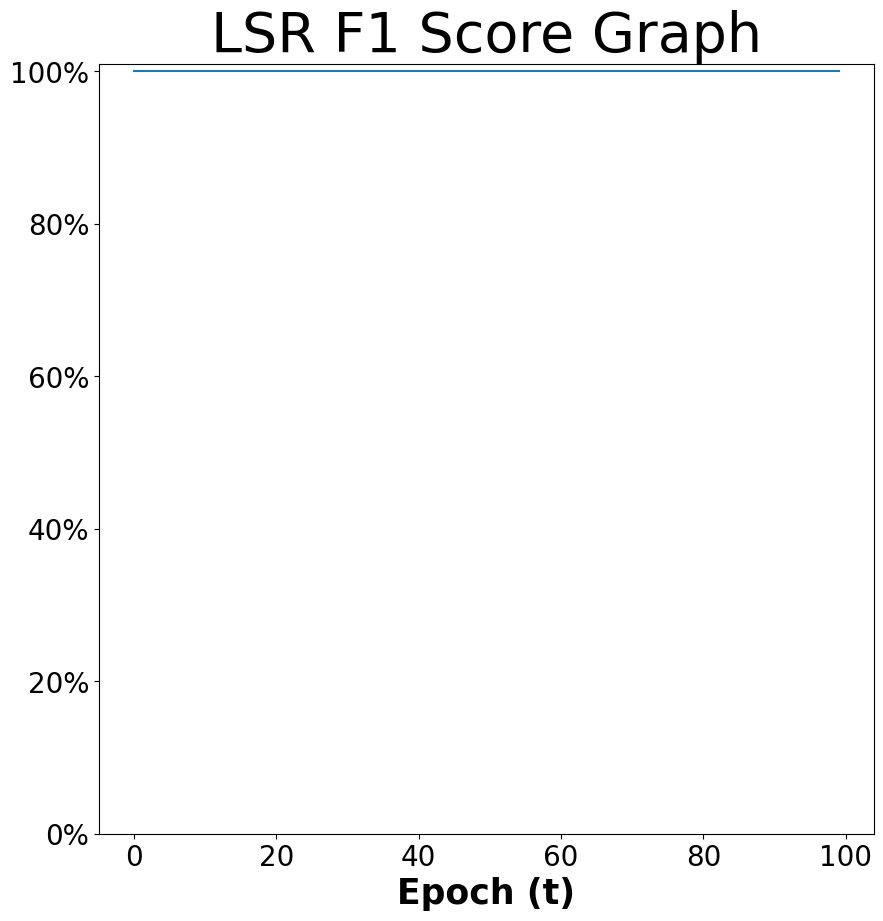

In [48]:
save_figs(lsr_glvq_acc, experiment, "LSR", learning_rate)

##### F1 Score

In [49]:
experiment = "experiment_2"

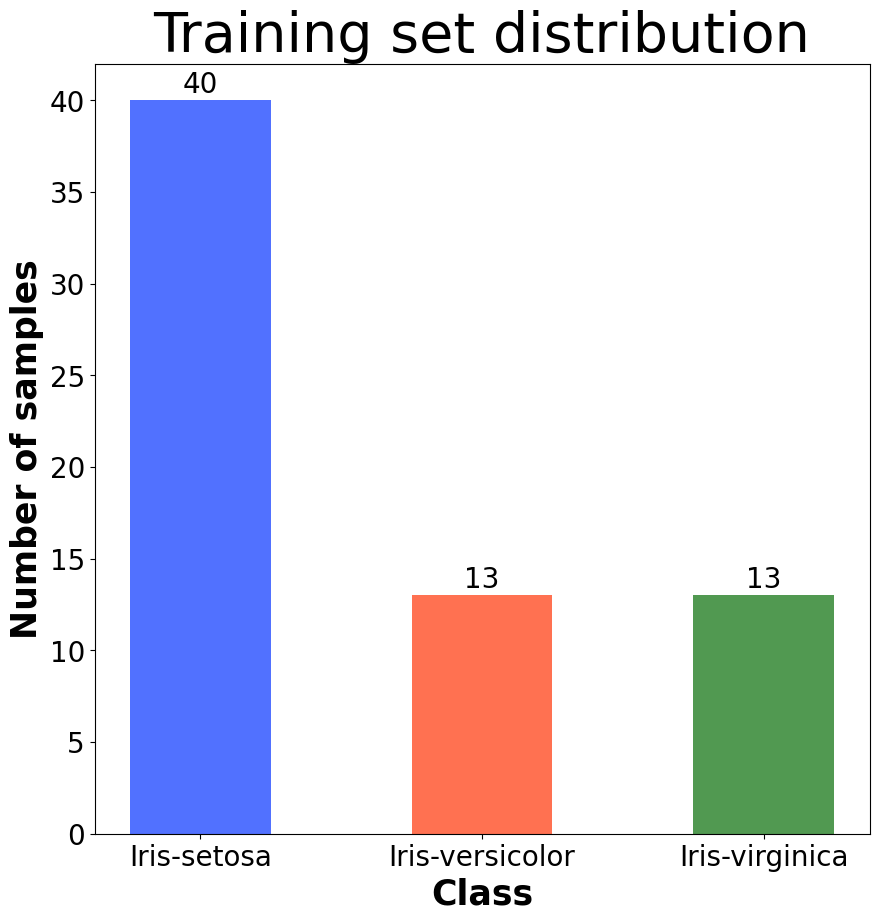

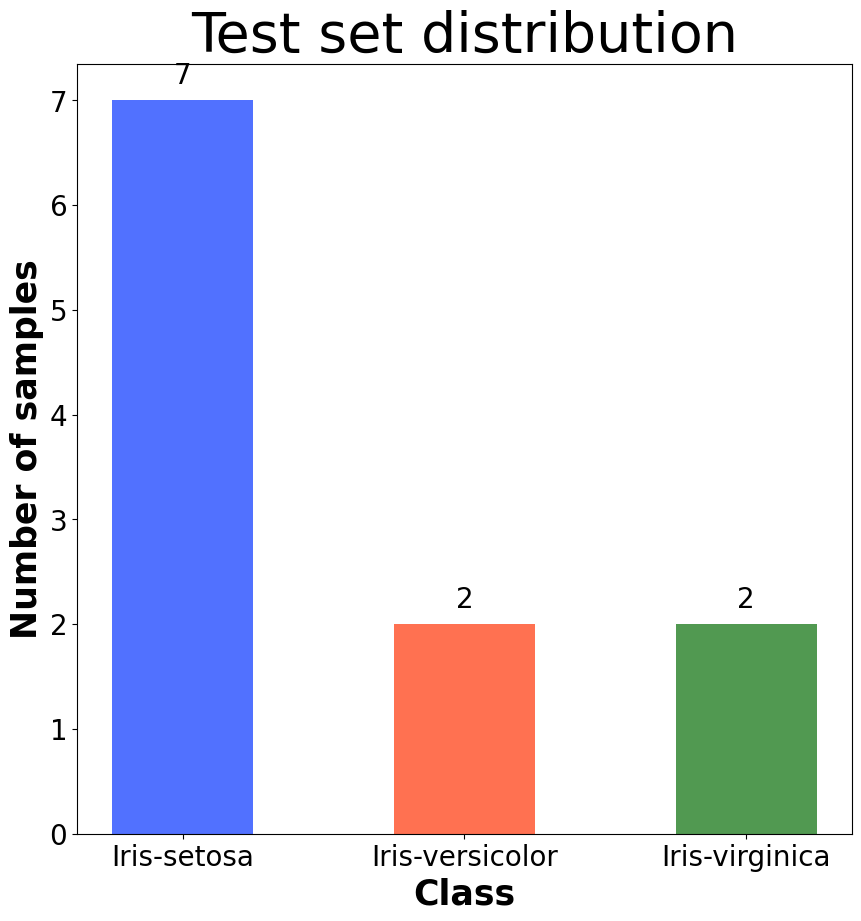

In [50]:
# Select 33% of #sample-1 as #sample-2
max_data = max(count) - num_prototypes
data_per_class = [max_data, int(max_data / 3), int(max_data / 3)]
test_percentage = 0.15
test_size = list(map(lambda data: int(data * test_percentage), data_per_class))
train_size = [data - test for data, test in zip(data_per_class, test_size)]
feature_f1 = copy.deepcopy(feature)
label_f1 = copy.deepcopy(label)
## Select test set
test_index = []
for j, class_name in enumerate(sample_number):
    index_i = np.where(label_f1 == class_name)
    index_i = list(index_i[0])
    index_i_sample = random.sample(index_i, test_size[j])
    test_index += index_i_sample
test_index.sort(reverse=True)
test_set_fscore = [(feature_f1[i], label_f1[i]) for i in test_index]
random.shuffle(test_set_fscore)
unique, counts = np.unique(label_f1[test_index], return_counts=True)
test_dist = dict(zip(unique, counts))
feature_f1 = np.delete(feature_f1, test_index, axis=0)
label_f1 = np.delete(label_f1, test_index, axis=0)

## Select train set
train_index = []
for j, class_name in enumerate(sample_number):
    index_i = np.where(label_f1 == class_name)
    index_i = list(index_i[0])
    index_i_sample = random.sample(index_i, train_size[j])
    train_index += index_i_sample
train_index.sort(reverse=True)
train_set_fscore = [(feature_f1[i], label_f1[i]) for i in train_index]
random.shuffle(train_set_fscore)
unique, counts = np.unique(label_f1[train_index], return_counts=True)
train_dist = dict(zip(unique, counts))

fig, ax = plt.subplots(figsize=(10, 10))
for i, (k, v) in enumerate(train_dist.items()):
    ax.bar(k, v, width=0.5, color=colors[i])
    plt.text(k, v + 0.1, str(v), ha="center", va="bottom", fontsize=20)
plt.title("Training set distribution", fontsize=40)
plt.xlabel("Class", fontsize=25, weight="bold")
plt.ylabel("Number of samples", fontsize=25, weight="bold")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()
fig.savefig(img_folder + experiment + "/" + data_name + "/train_dist.png", dpi=300)

fig, ax = plt.subplots(figsize=(10, 10))
for i, (k, v) in enumerate(test_dist.items()):
    ax.bar(k, v, width=0.5, color=colors[i])
    plt.text(k, v + 0.1, str(v), ha="center", va="bottom", fontsize=20)
plt.title("Test set distribution", fontsize=40)
plt.xlabel("Class", fontsize=25, weight="bold")
plt.ylabel("Number of samples", fontsize=25, weight="bold")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()
fig.savefig(img_folder + experiment + "/" + data_name + "/test_dist.png", dpi=300)

#### Train the Models

In [51]:
num_epochs = 100

##### GLVQ

##### 1-step lr =0.1

In [52]:
learning_rate = 0.1
oglvq_fscore = oglvq.OGLVQ(prototypes, learning_rate)
hist = oglvq_fscore.train(
    num_epochs, train_set_fscore, test_set_fscore, sample_number=train_dist
)


Epoch: 1, Loss: 21.1205, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 11, Loss: 20.2056, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 21, Loss: 20.1833, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 31, Loss: 20.1760, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 41, Loss: 20.1726, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 51, Loss: 20.1700, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 61, Loss: 20.1685, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 71, Loss: 20.1675, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 81, Loss: 20.1669, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 91, Loss: 20.1663, Accuracy: 90.91 %, F_1_score: 85.45 %


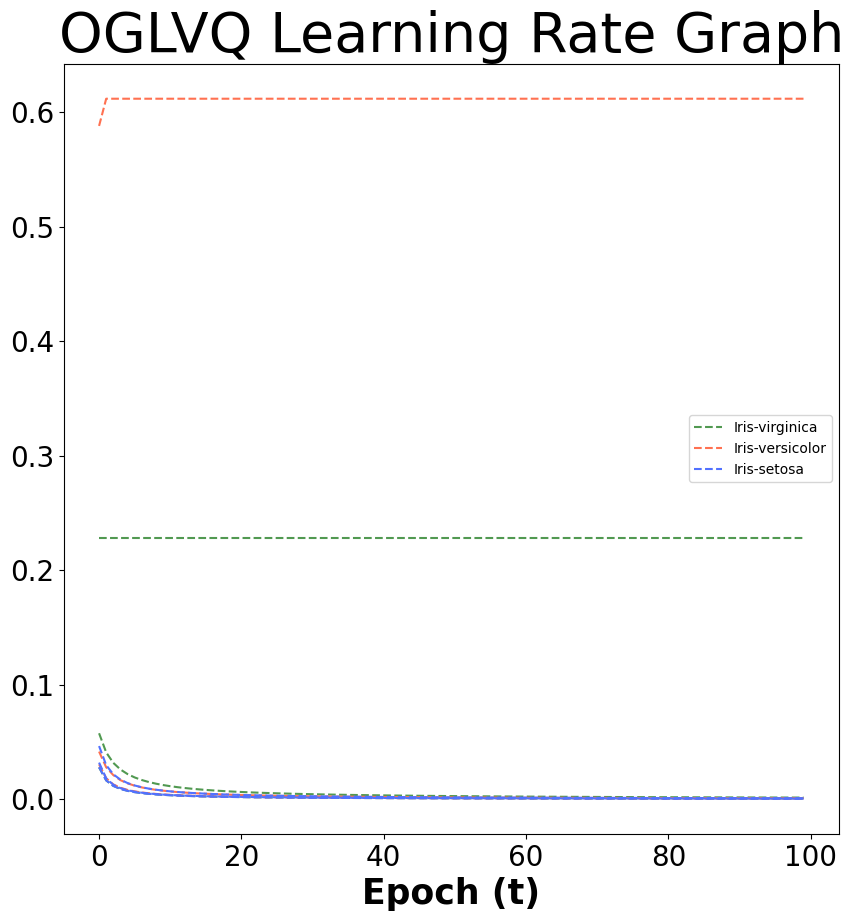

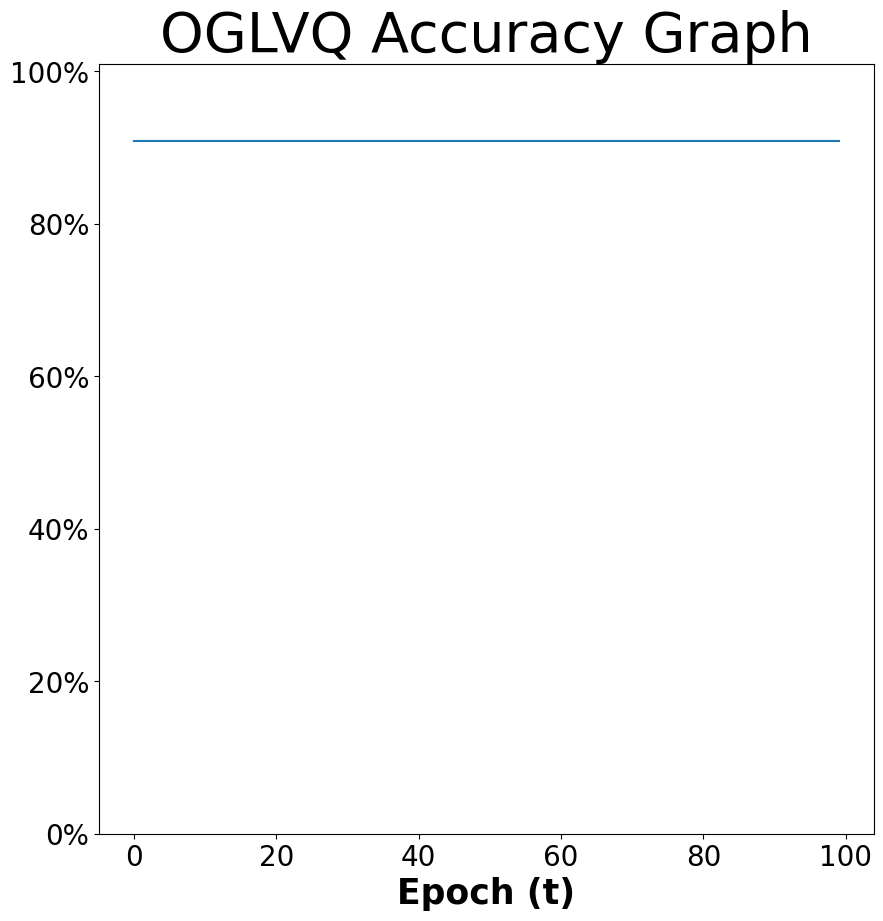

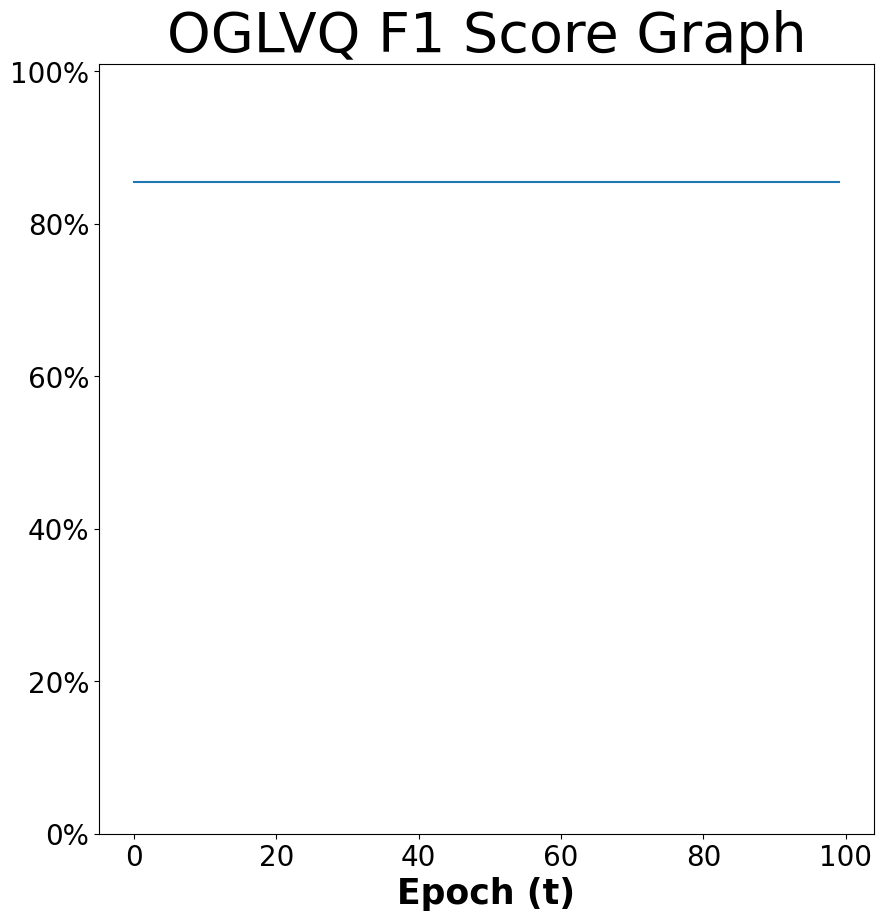

In [53]:
save_figs(oglvq_fscore, experiment, "OGLVQ", learning_rate)

##### 2-step lr = 0.03

In [54]:
learning_rate = 0.03
oglvq_fscore = oglvq.OGLVQ(
    prototypes,
    learning_rate,
)
hist = oglvq_fscore.train(
    num_epochs, train_set_fscore, test_set_fscore, sample_number=train_dist
)


Epoch: 1, Loss: 21.1706, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 11, Loss: 20.1111, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 21, Loss: 20.0775, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 31, Loss: 20.0701, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 41, Loss: 20.0634, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 51, Loss: 20.0596, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 61, Loss: 20.0585, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 71, Loss: 20.0558, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 81, Loss: 20.0553, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 91, Loss: 20.0548, Accuracy: 90.91 %, F_1_score: 85.45 %


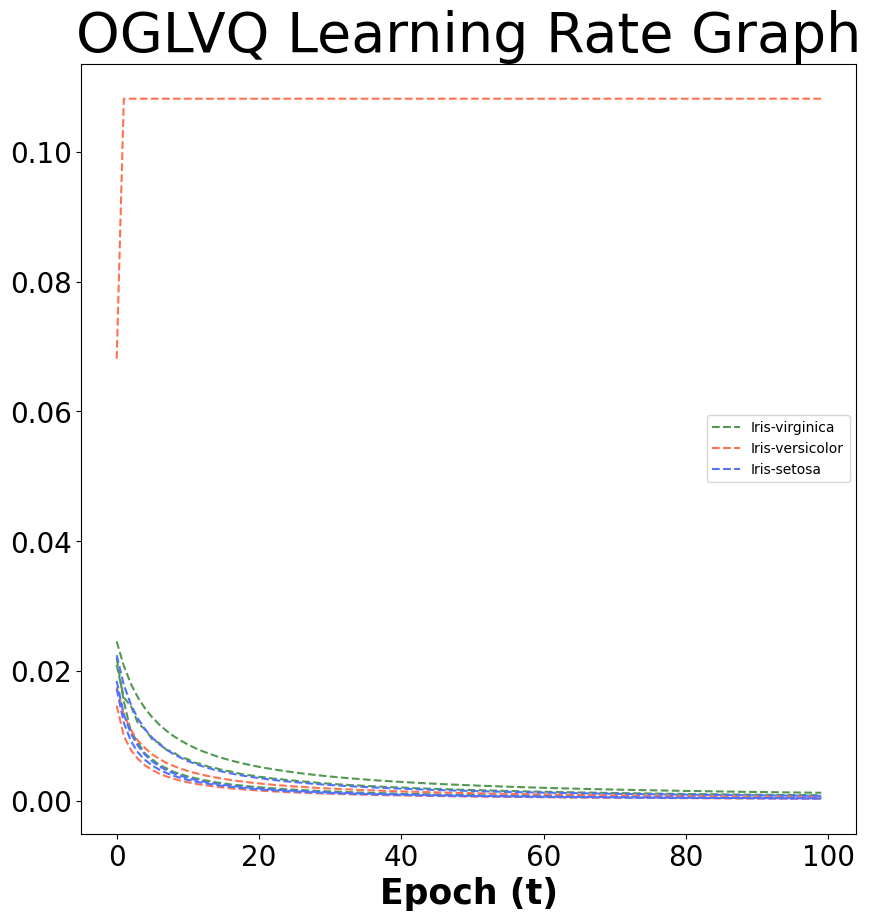

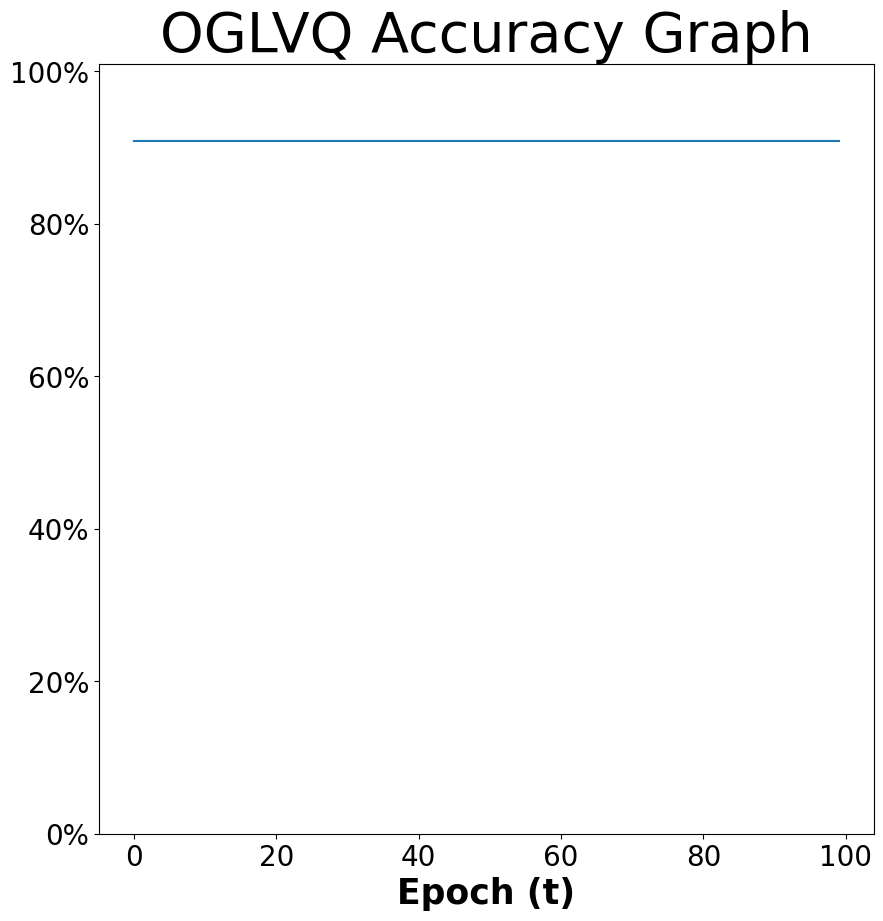

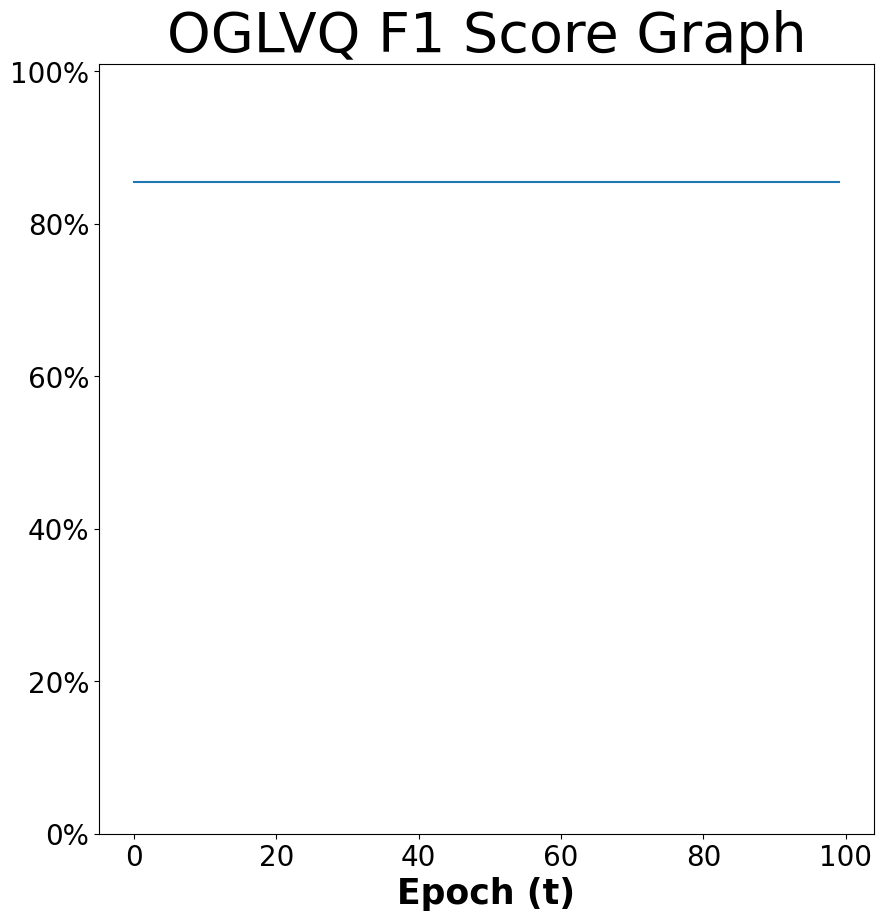

In [55]:
save_figs(oglvq_fscore, experiment, "OGLVQ", learning_rate)

##### 3-step lr = 0.01

In [56]:
learning_rate = 0.01
oglvq_fscore = oglvq.OGLVQ(prototypes, learning_rate)
hist = oglvq_fscore.train(
    num_epochs, train_set_fscore, test_set_fscore, sample_number=train_dist
)


Epoch: 1, Loss: 21.3671, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 11, Loss: 20.1826, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 21, Loss: 20.1118, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 31, Loss: 20.0865, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 41, Loss: 20.0709, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 51, Loss: 20.0643, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 61, Loss: 20.0575, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 71, Loss: 20.0538, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 81, Loss: 20.0523, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 91, Loss: 20.0508, Accuracy: 90.91 %, F_1_score: 85.45 %


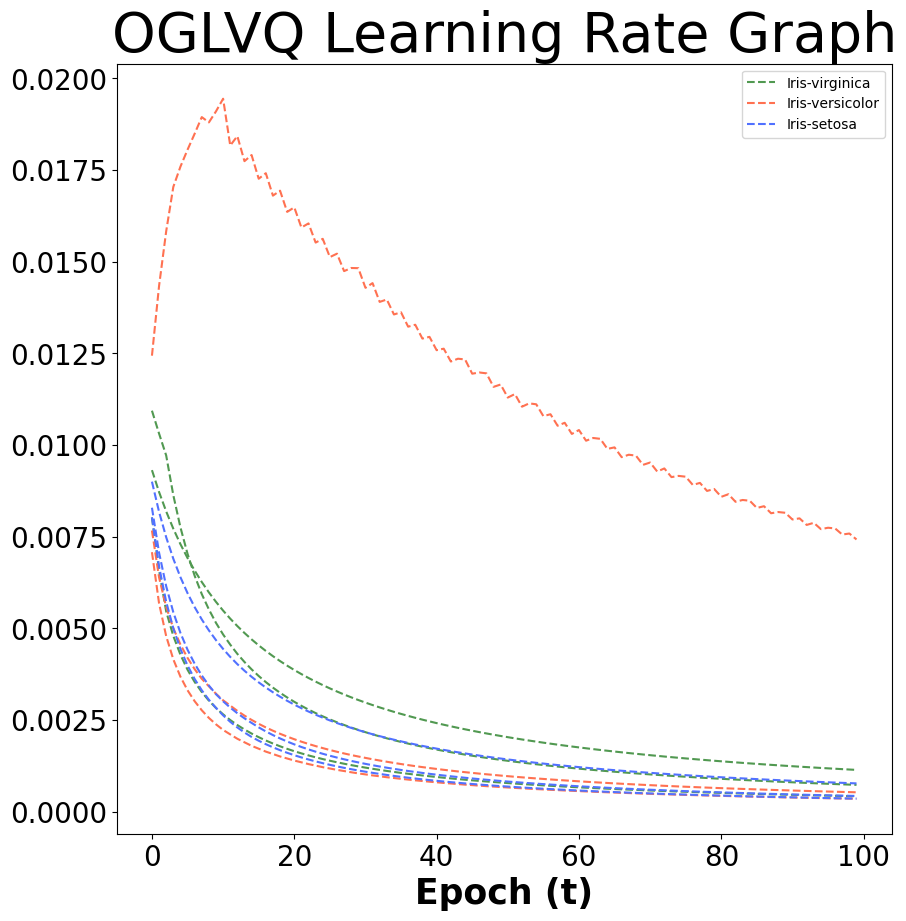

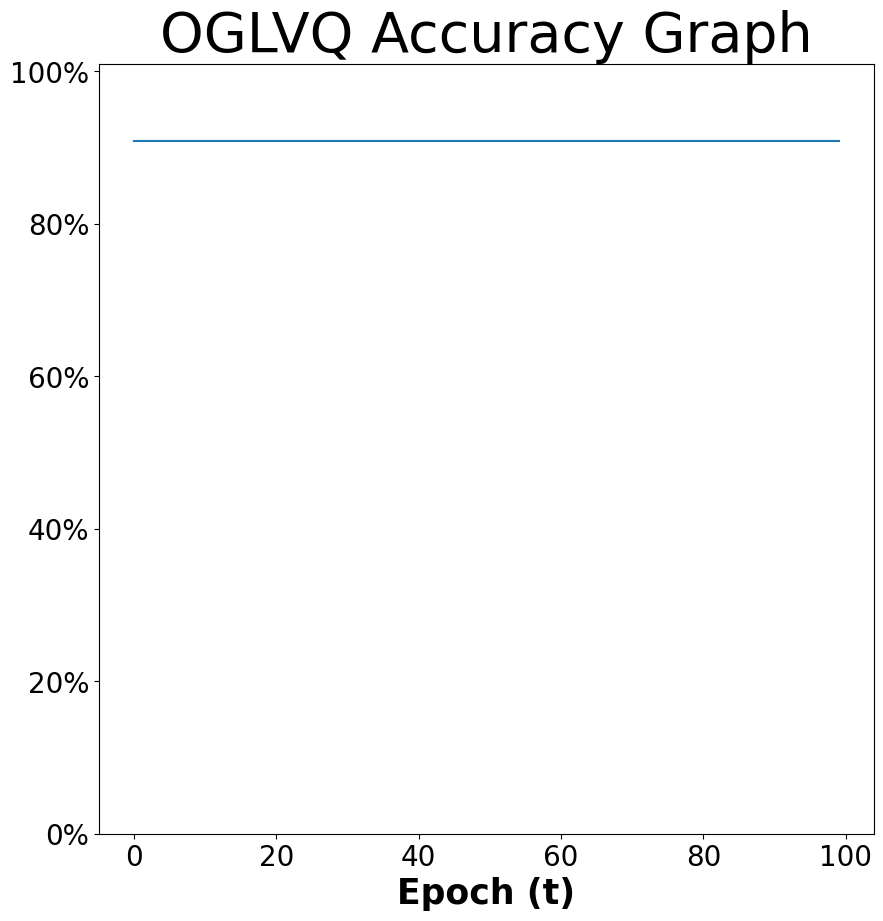

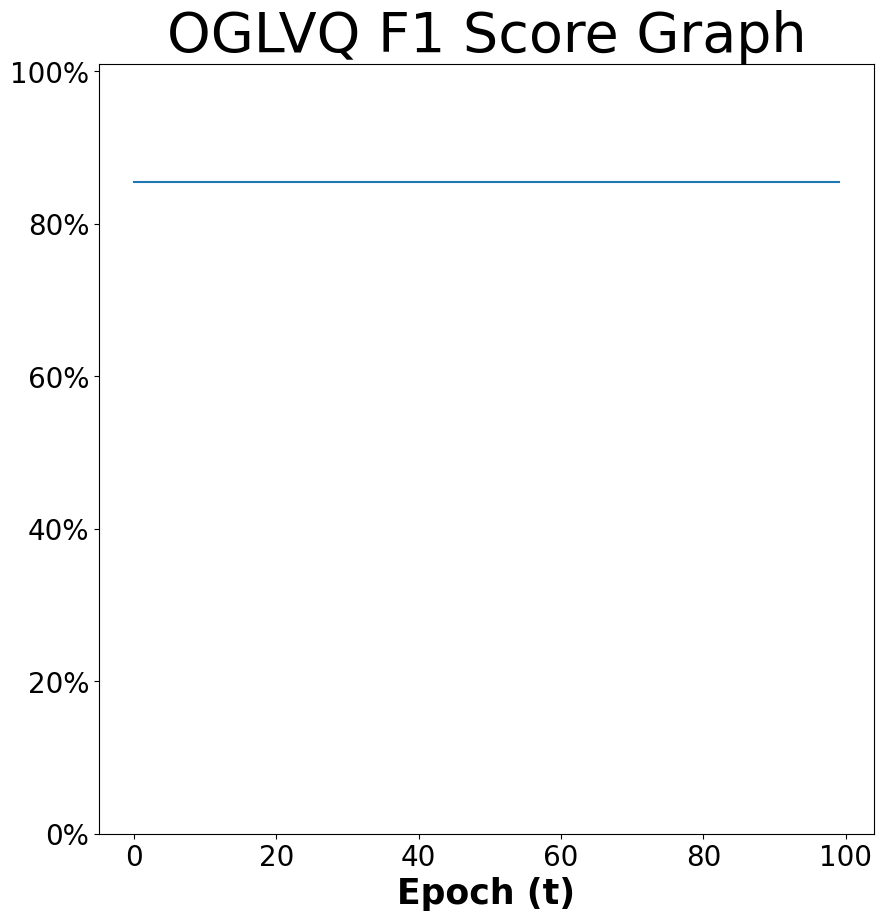

In [57]:
save_figs(oglvq_fscore, experiment, "OGLVQ", learning_rate)

##### CP

##### 1-step lr = 0.1

In [58]:
learning_rate = 0.1
cp_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = cp_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.conditional_probability,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.3243, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 11, Loss: 0.3139, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 21, Loss: 0.3186, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 31, Loss: 0.3233, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 41, Loss: 0.3248, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 51, Loss: 0.3263, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 61, Loss: 0.3299, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 71, Loss: 0.3305, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 81, Loss: 0.3307, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 91, Loss: 0.3308, Accuracy: 90.91 %, F_1_score: 85.45 %


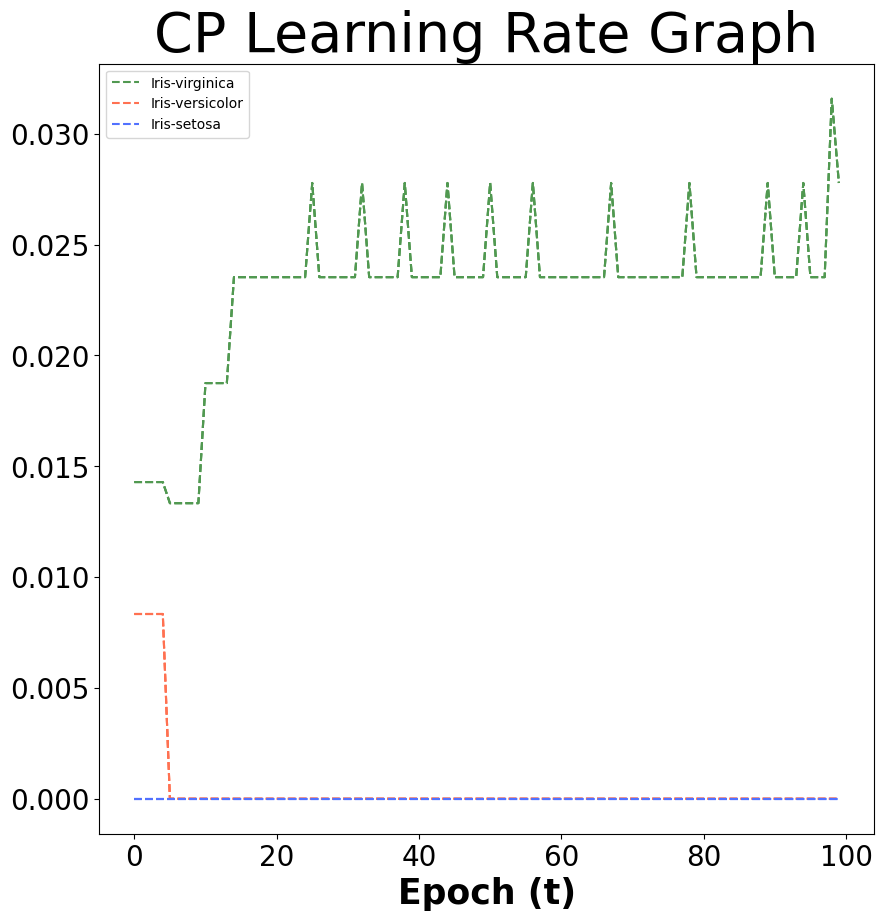

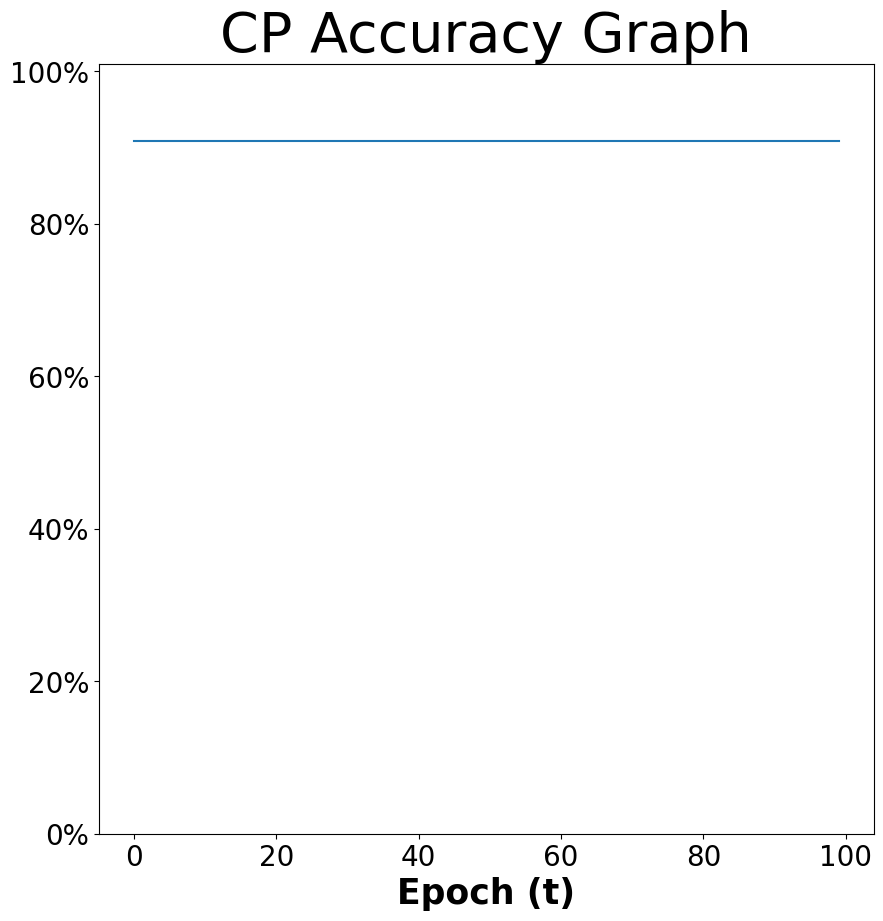

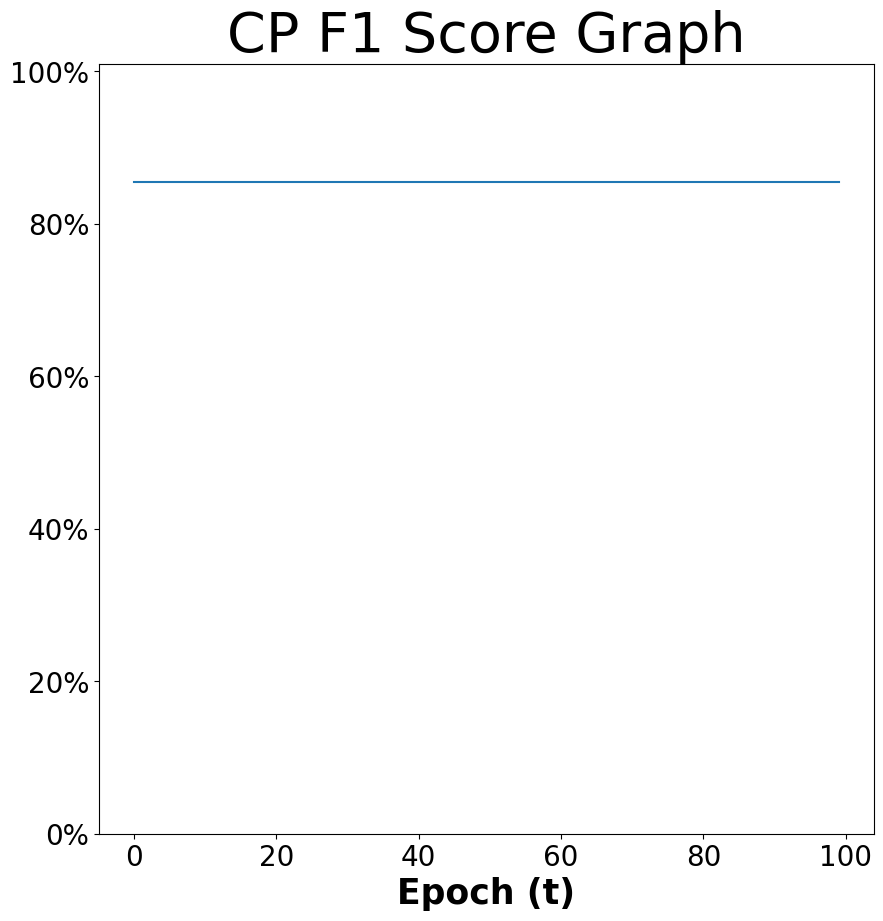

In [59]:
save_figs(cp_glvq_fscore, experiment, "CP", learning_rate)

##### 2-step lr = 0.03

In [60]:
learning_rate = 0.03
cp_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = cp_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.conditional_probability,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.3247, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 11, Loss: 0.3162, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 21, Loss: 0.3142, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 31, Loss: 0.3136, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 41, Loss: 0.3137, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 51, Loss: 0.3144, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 61, Loss: 0.3163, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 71, Loss: 0.3183, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 81, Loss: 0.3202, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 91, Loss: 0.3209, Accuracy: 90.91 %, F_1_score: 85.45 %


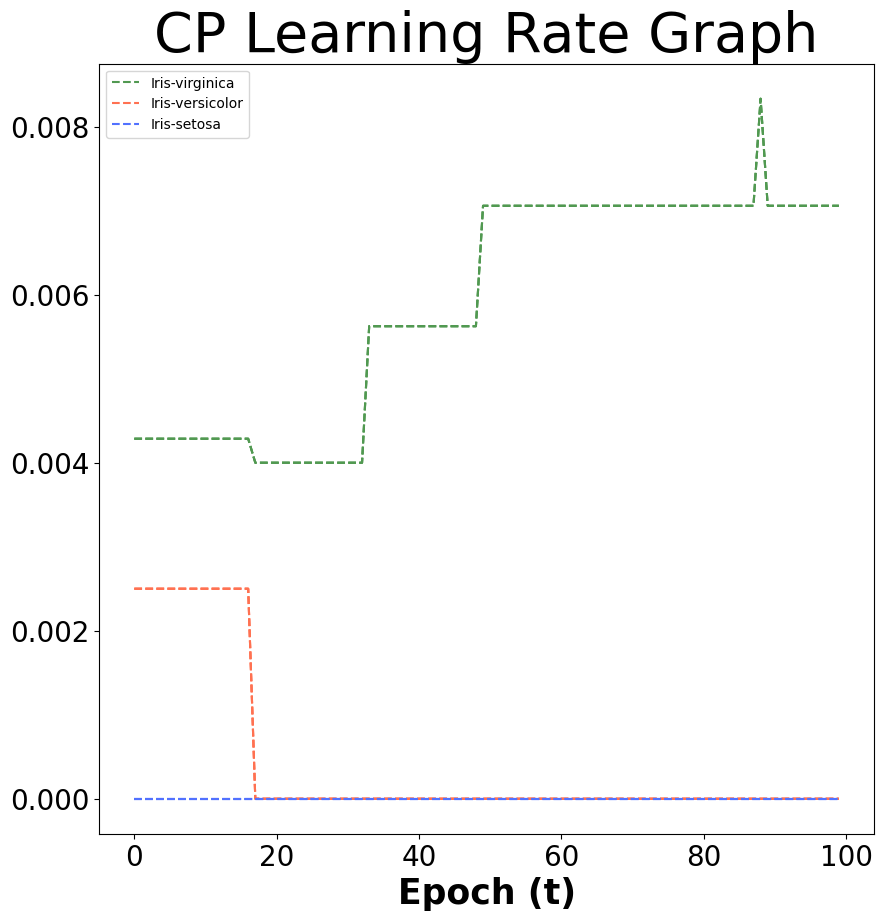

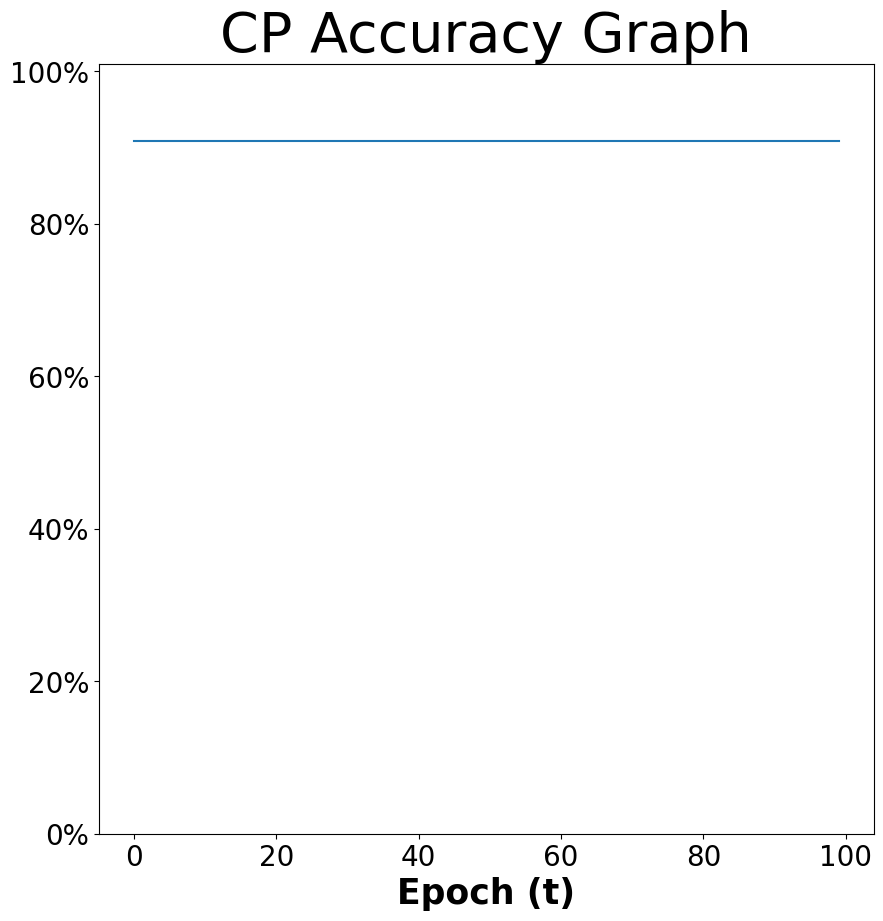

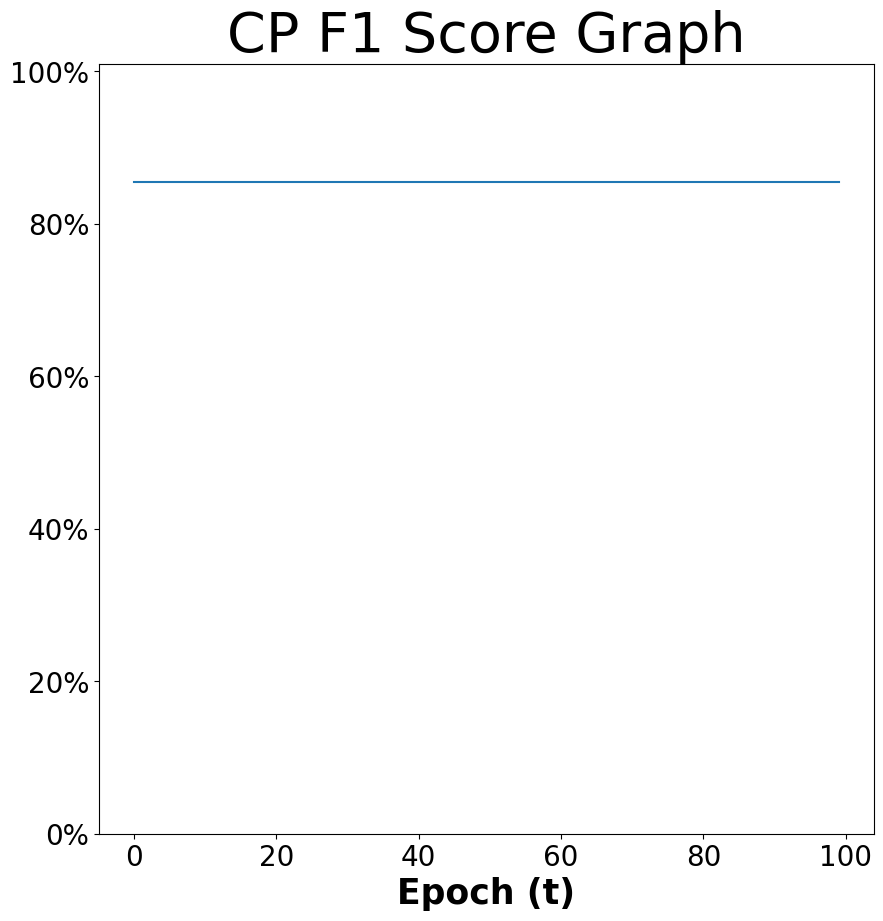

In [61]:
save_figs(cp_glvq_fscore, experiment, "CP", learning_rate)

##### 3-step lr = 0.01

In [62]:
learning_rate = 0.01
cp_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = cp_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.conditional_probability,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.3249, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 11, Loss: 0.3201, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 21, Loss: 0.3177, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 31, Loss: 0.3162, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 41, Loss: 0.3152, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 51, Loss: 0.3145, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 61, Loss: 0.3141, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 71, Loss: 0.3138, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 81, Loss: 0.3135, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 91, Loss: 0.3135, Accuracy: 90.91 %, F_1_score: 85.45 %


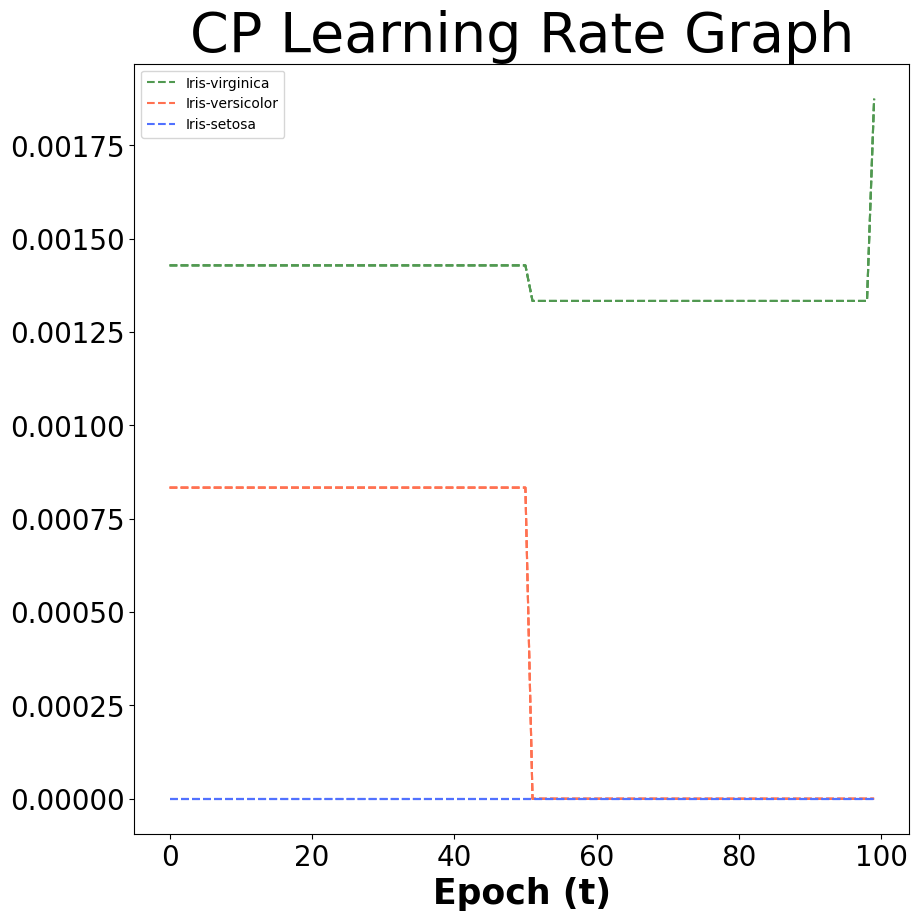

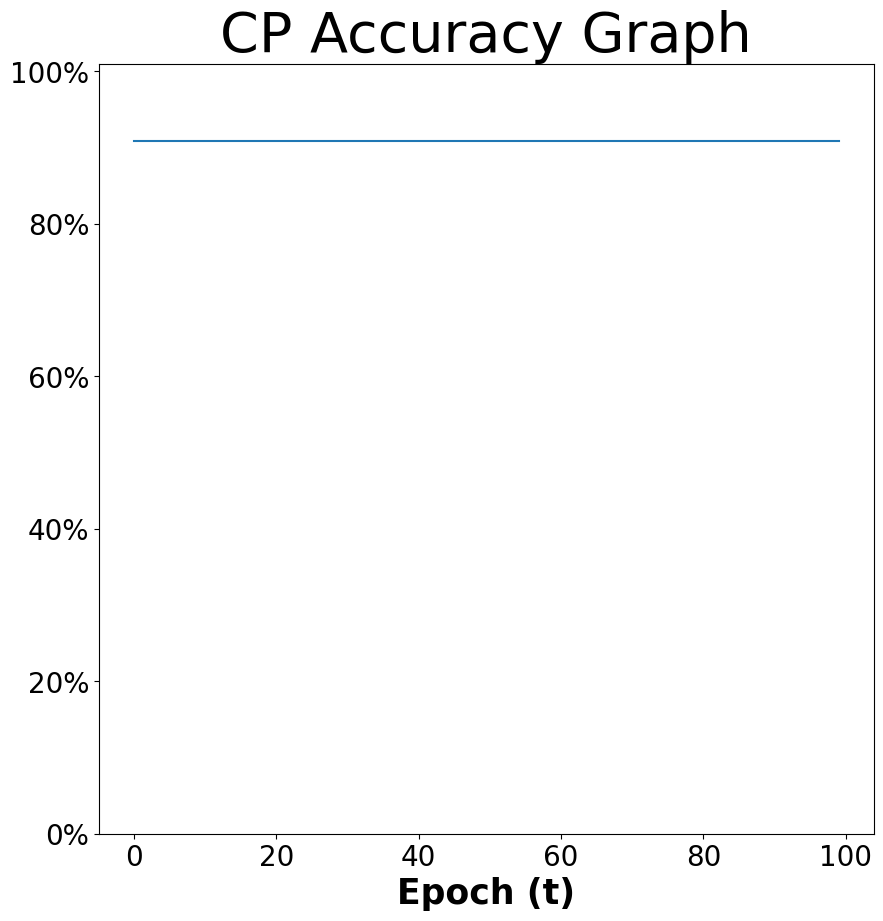

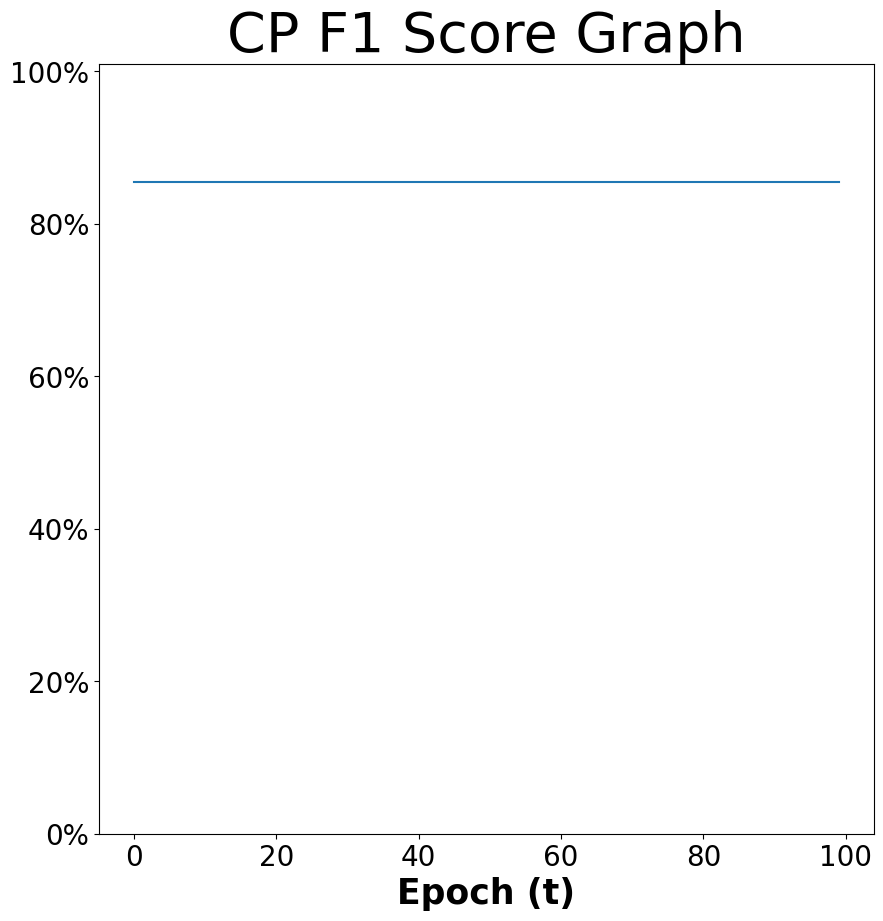

In [63]:
save_figs(cp_glvq_fscore, experiment, "CP", learning_rate)

##### DFH

##### 1-step lr = 0.1

In [64]:
learning_rate = 0.1
dfh_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = dfh_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.dual_factor_heuristic,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.3199, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 11, Loss: 0.3103, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 21, Loss: 0.3098, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 31, Loss: 0.3095, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 41, Loss: 0.3094, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 51, Loss: 0.3100, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 61, Loss: 0.3094, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 71, Loss: 0.3100, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 81, Loss: 0.3095, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 91, Loss: 0.3100, Accuracy: 90.91 %, F_1_score: 85.45 %


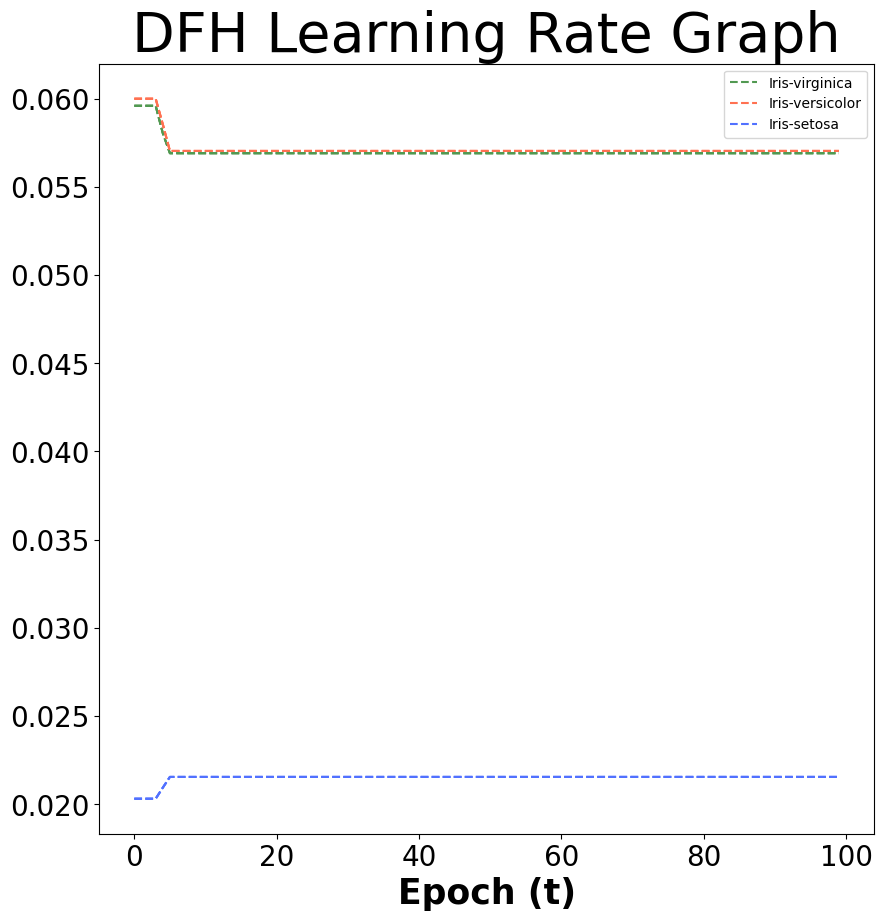

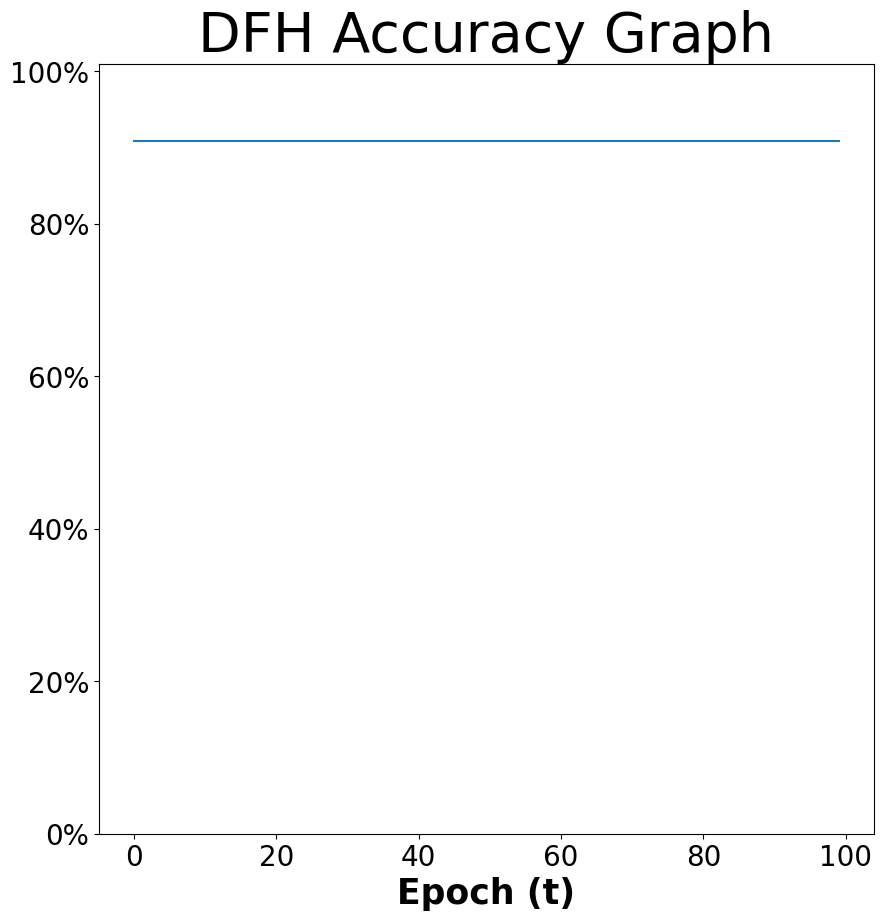

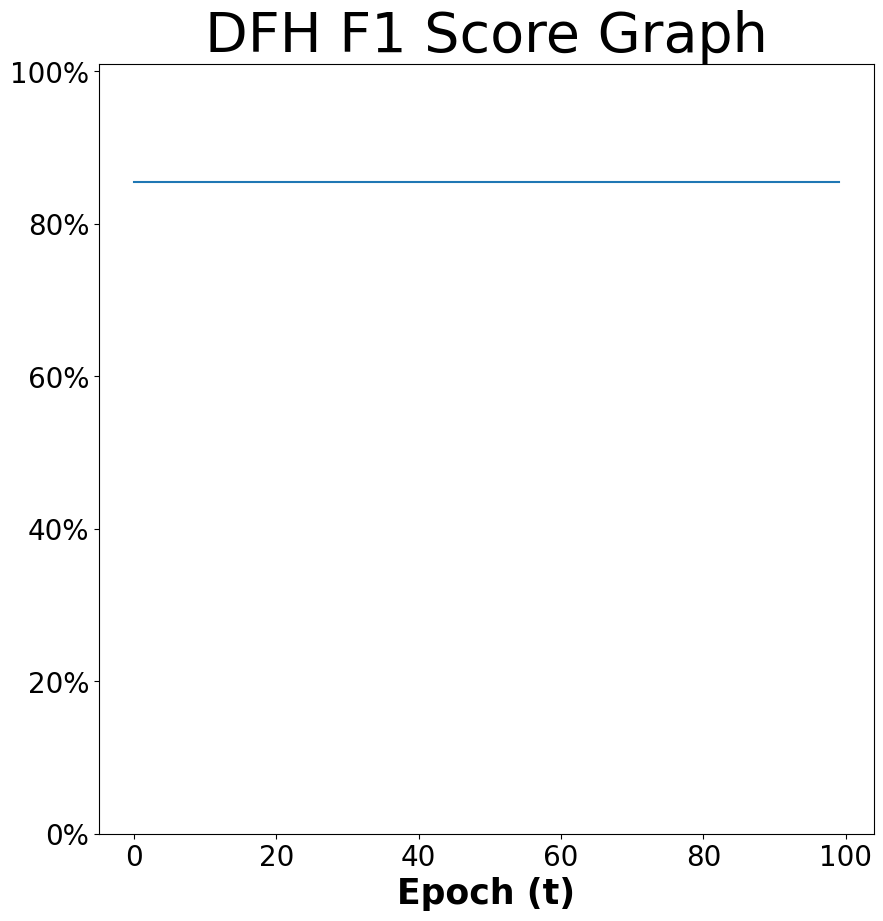

In [65]:
save_figs(dfh_glvq_fscore, experiment, "DFH", learning_rate)

##### 2-step lr = 0.03

In [66]:
learning_rate = 0.03
dfh_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = dfh_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.dual_factor_heuristic,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.3224, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 11, Loss: 0.3064, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 21, Loss: 0.3050, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 31, Loss: 0.3048, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 41, Loss: 0.3048, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 51, Loss: 0.3048, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 61, Loss: 0.3048, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 71, Loss: 0.3048, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 81, Loss: 0.3048, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 91, Loss: 0.3048, Accuracy: 90.91 %, F_1_score: 85.45 %


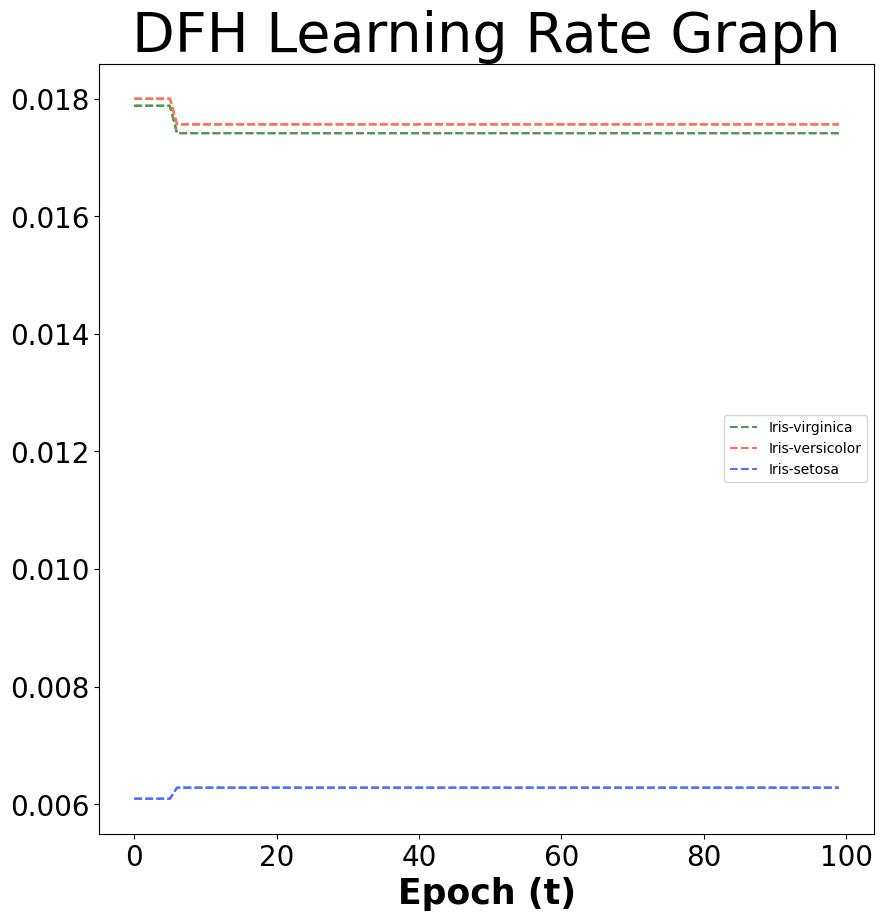

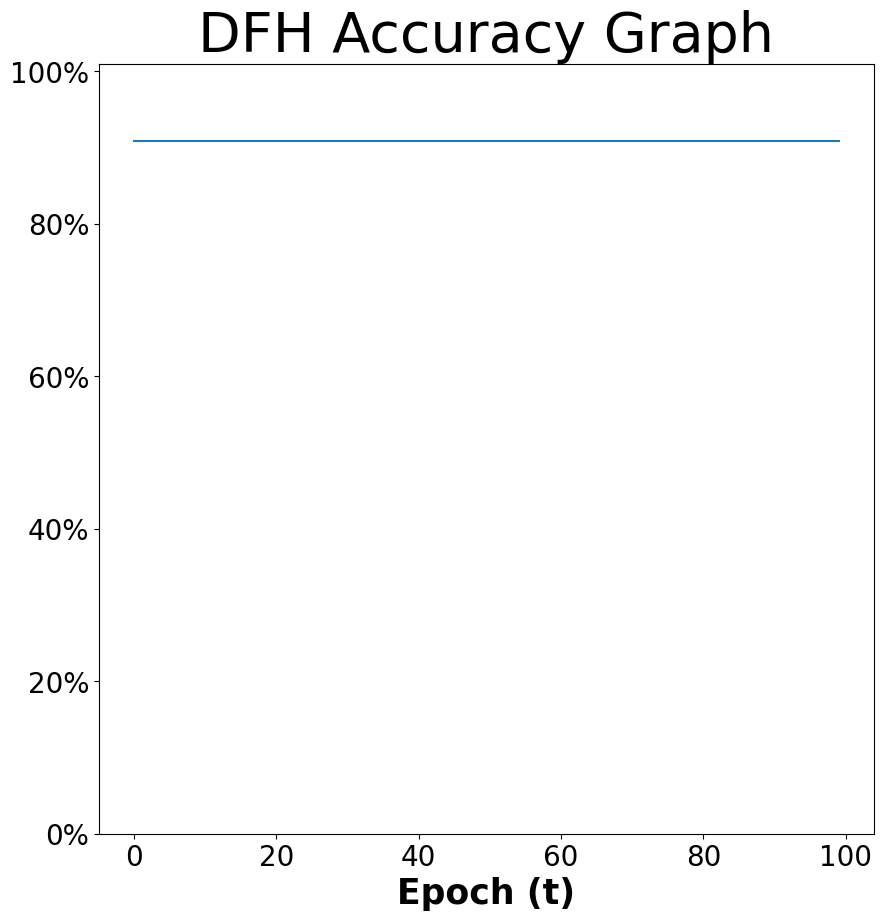

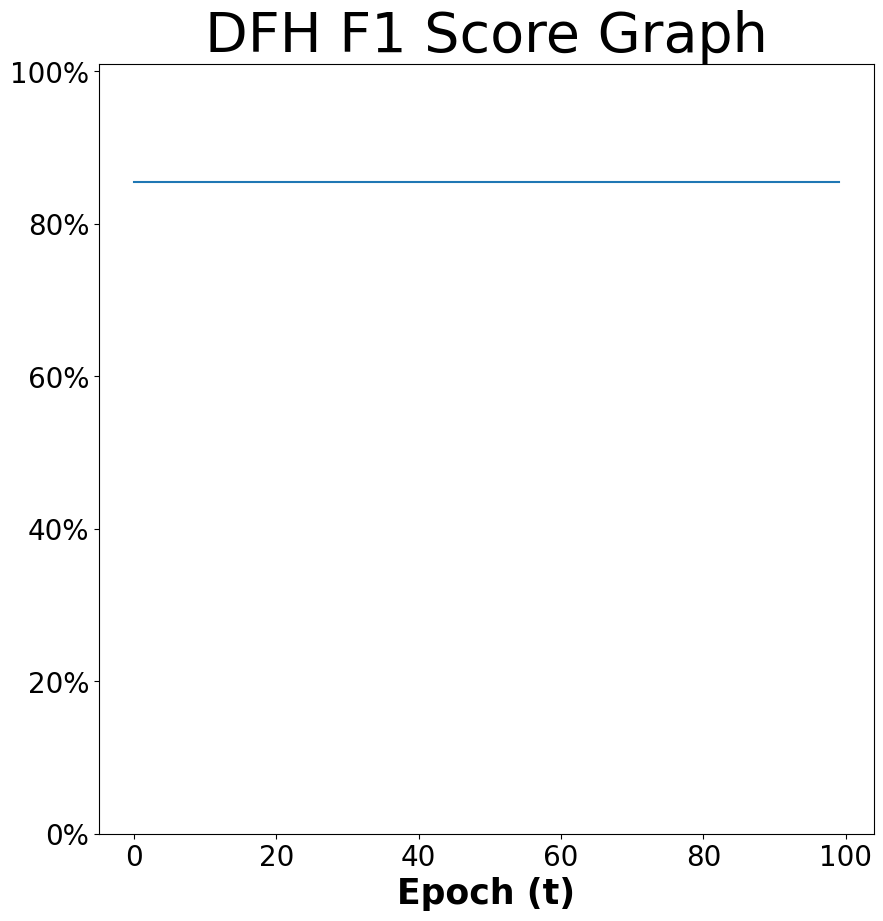

In [67]:
save_figs(dfh_glvq_fscore, experiment, "DFH", learning_rate)

##### 3-step lr = 0.01

In [68]:
learning_rate = 0.01
dfh_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = dfh_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.dual_factor_heuristic,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.3245, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 11, Loss: 0.3084, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 21, Loss: 0.3062, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 31, Loss: 0.3053, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 41, Loss: 0.3048, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 51, Loss: 0.3046, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 61, Loss: 0.3046, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 71, Loss: 0.3045, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 81, Loss: 0.3045, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 91, Loss: 0.3045, Accuracy: 90.91 %, F_1_score: 85.45 %


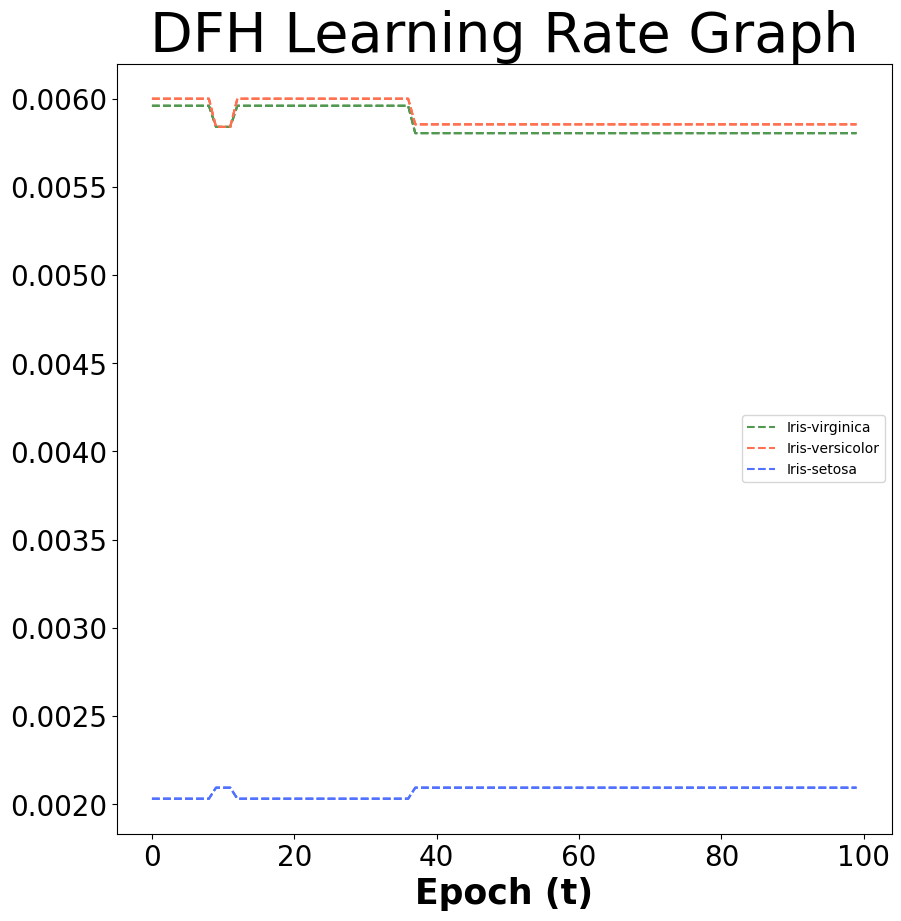

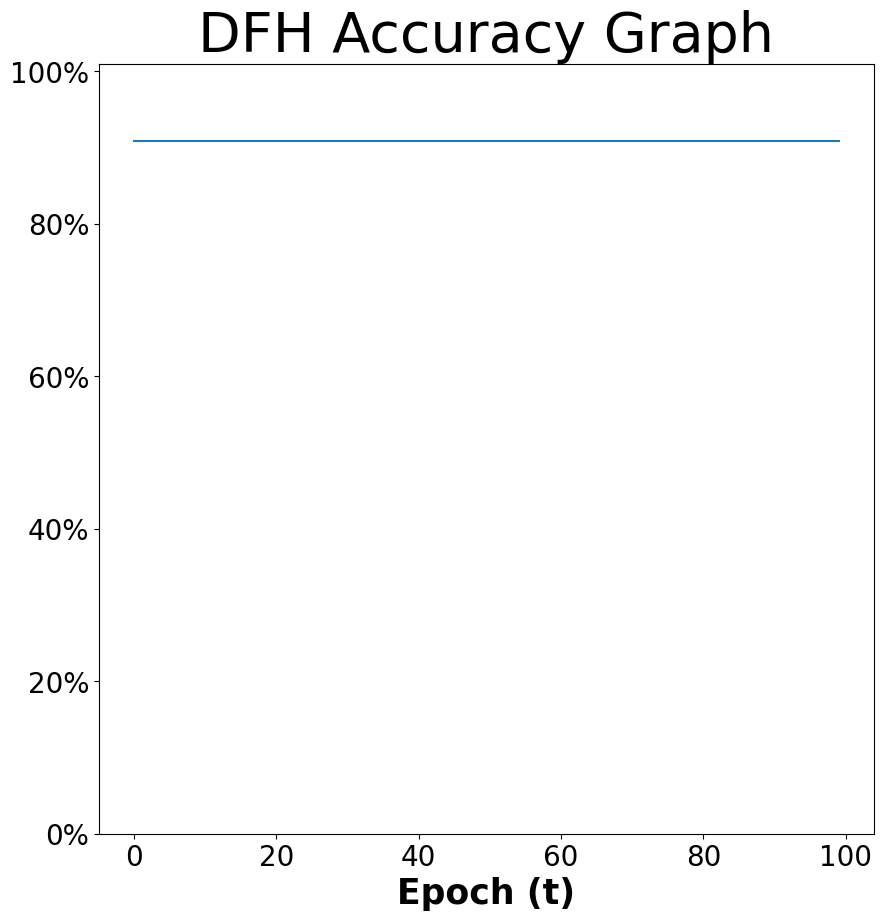

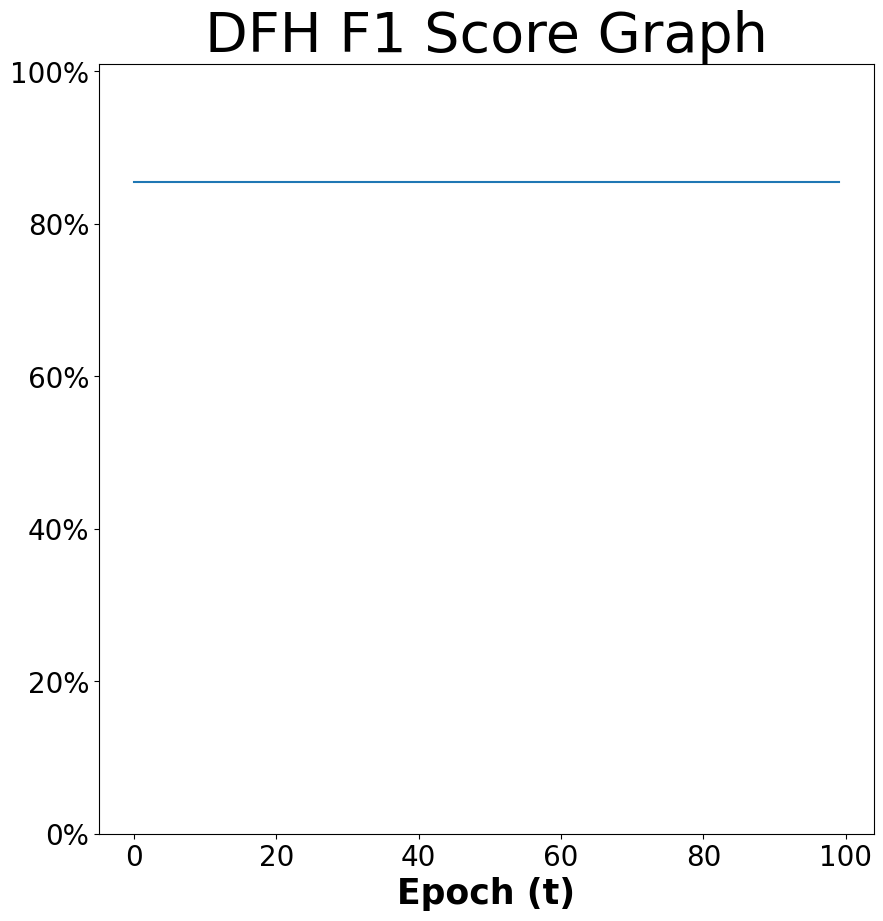

In [69]:
save_figs(dfh_glvq_fscore, experiment, "DFH", learning_rate)

##### MS

##### 1-step lr = 0.1

In [70]:
learning_rate = 0.1
ms_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = ms_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.middle_symmetry,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.3202, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 11, Loss: 0.3149, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 21, Loss: 0.3153, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 31, Loss: 0.3150, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 41, Loss: 0.3154, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 51, Loss: 0.3154, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 61, Loss: 0.3153, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 71, Loss: 0.3154, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 81, Loss: 0.3154, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 91, Loss: 0.3153, Accuracy: 90.91 %, F_1_score: 85.45 %


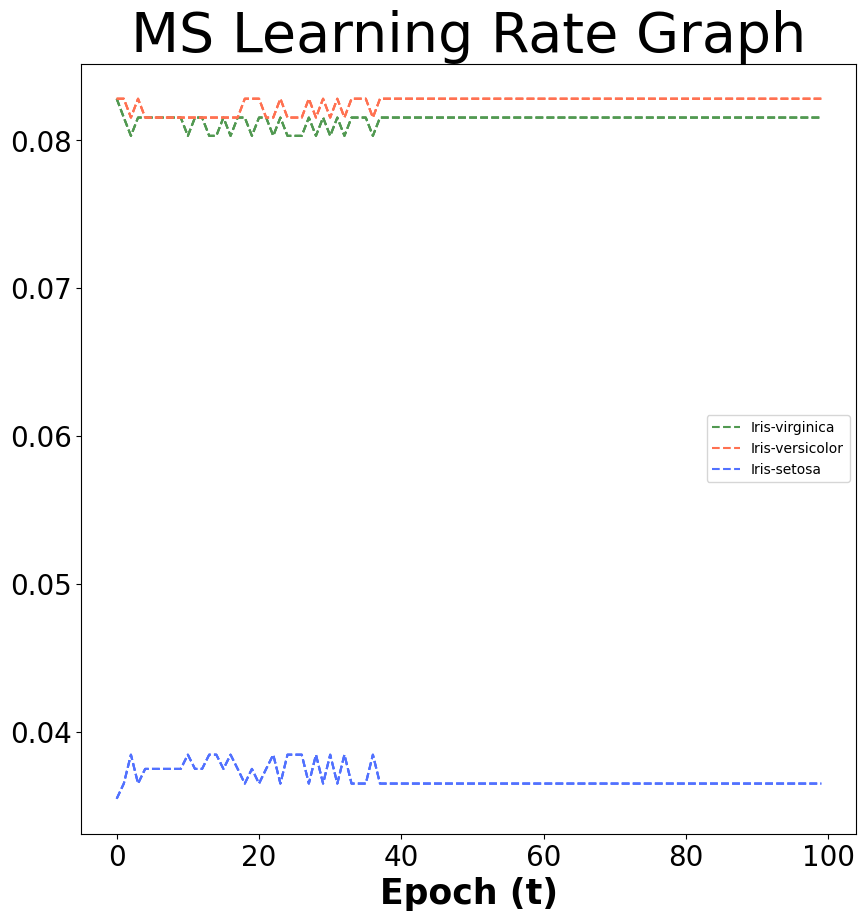

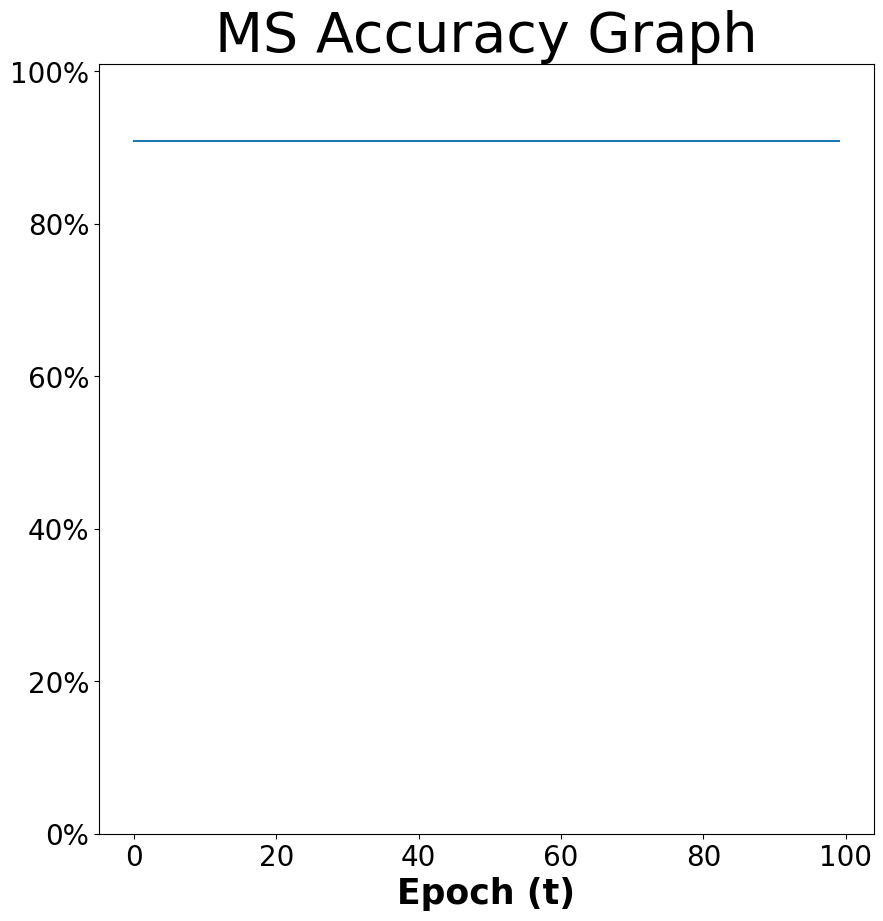

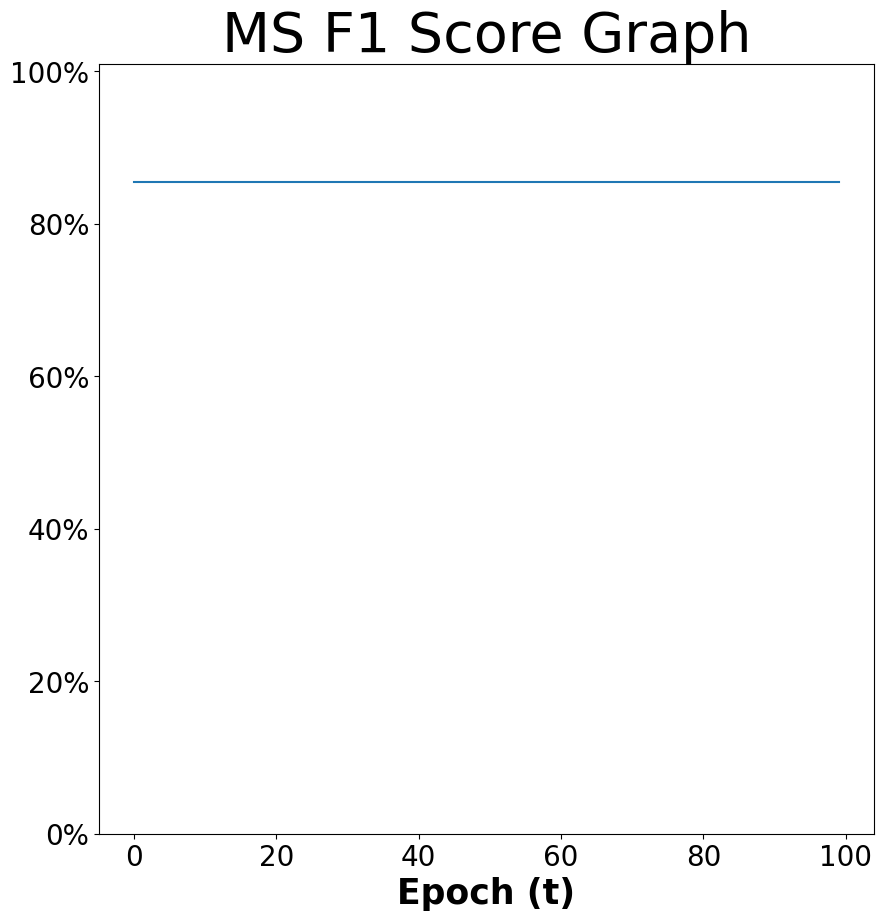

In [71]:
save_figs(ms_glvq_fscore, experiment, "MS", learning_rate)

##### 2-step lr = 0.03

In [72]:
learning_rate = 0.03
ms_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = ms_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.middle_symmetry,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.3213, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 11, Loss: 0.3064, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 21, Loss: 0.3065, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 31, Loss: 0.3062, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 41, Loss: 0.3062, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 51, Loss: 0.3064, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 61, Loss: 0.3062, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 71, Loss: 0.3063, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 81, Loss: 0.3064, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 91, Loss: 0.3062, Accuracy: 90.91 %, F_1_score: 85.45 %


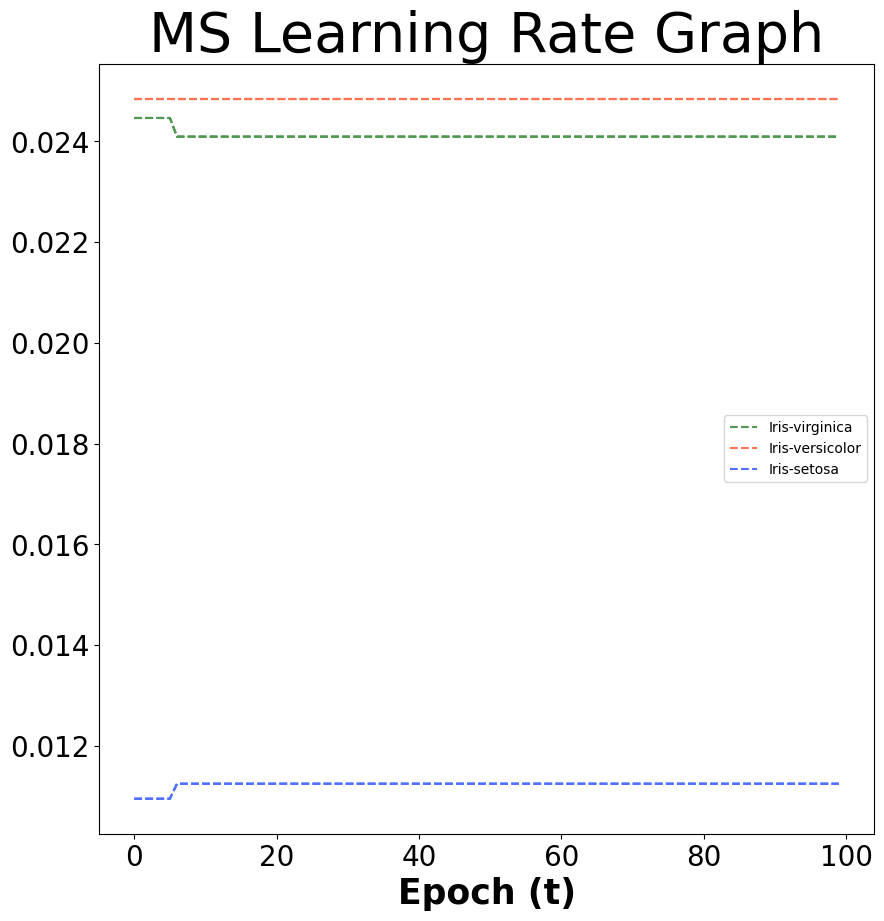

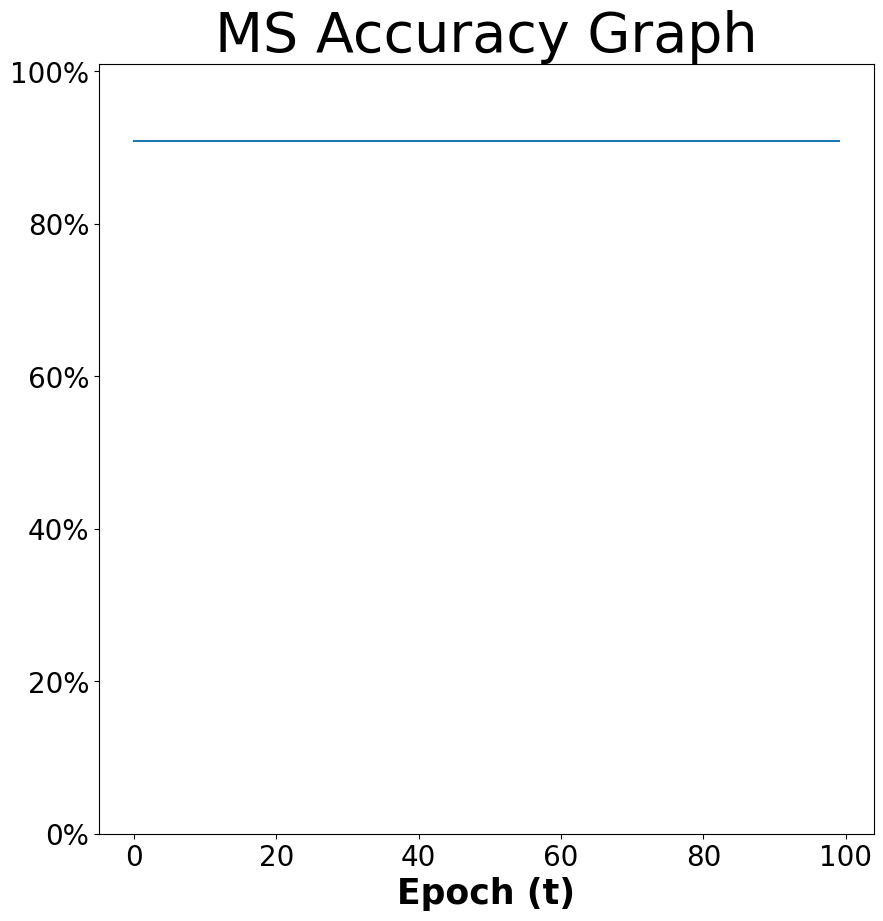

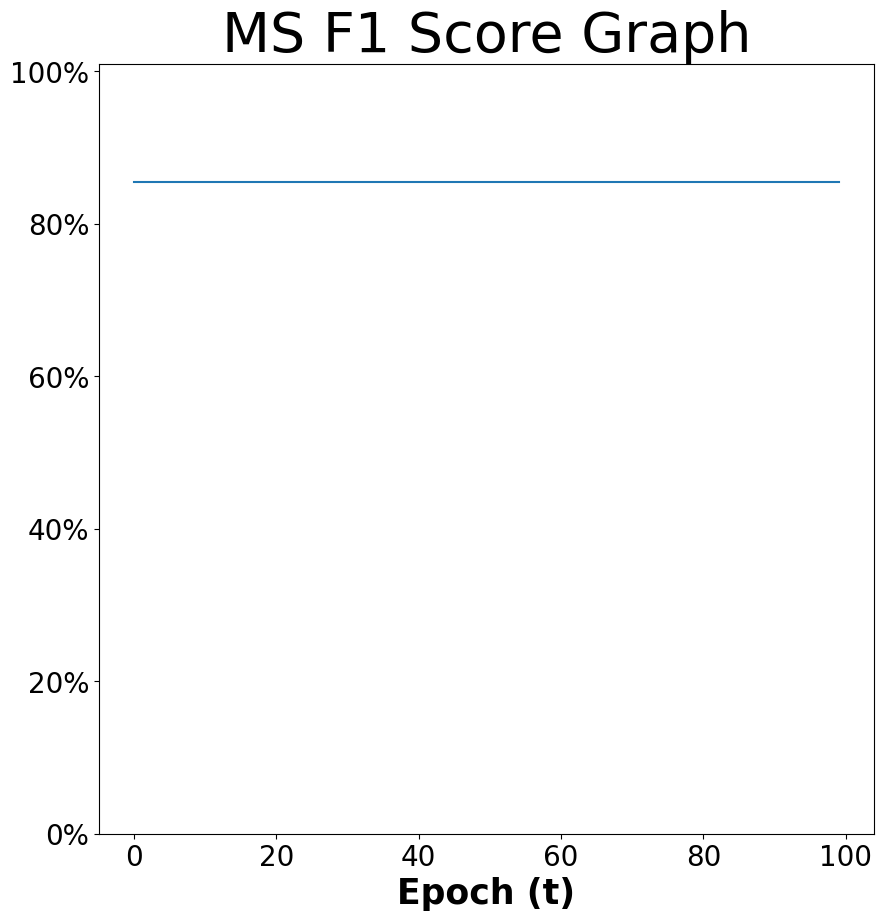

In [73]:
save_figs(ms_glvq_fscore, experiment, "MS", learning_rate)

##### 3-step lr = 0.01

In [74]:
learning_rate = 0.01
ms_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = ms_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.middle_symmetry,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.3241, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 11, Loss: 0.3073, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 21, Loss: 0.3056, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 31, Loss: 0.3050, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 41, Loss: 0.3049, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 51, Loss: 0.3049, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 61, Loss: 0.3049, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 71, Loss: 0.3048, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 81, Loss: 0.3048, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 91, Loss: 0.3048, Accuracy: 90.91 %, F_1_score: 85.45 %


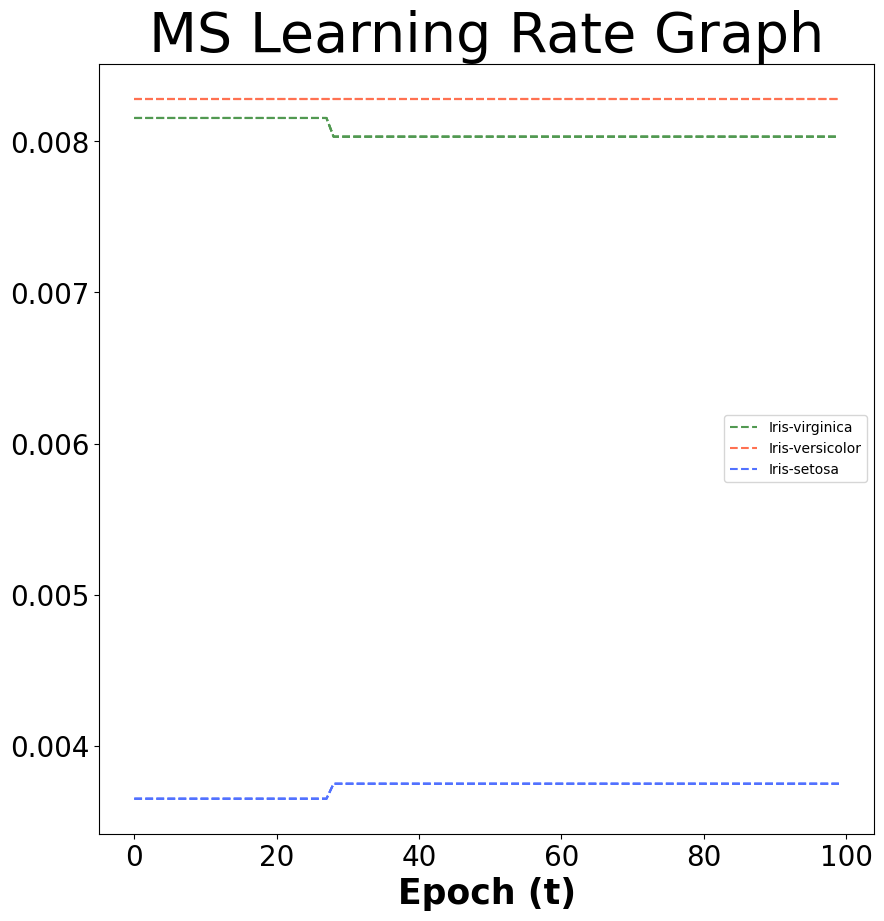

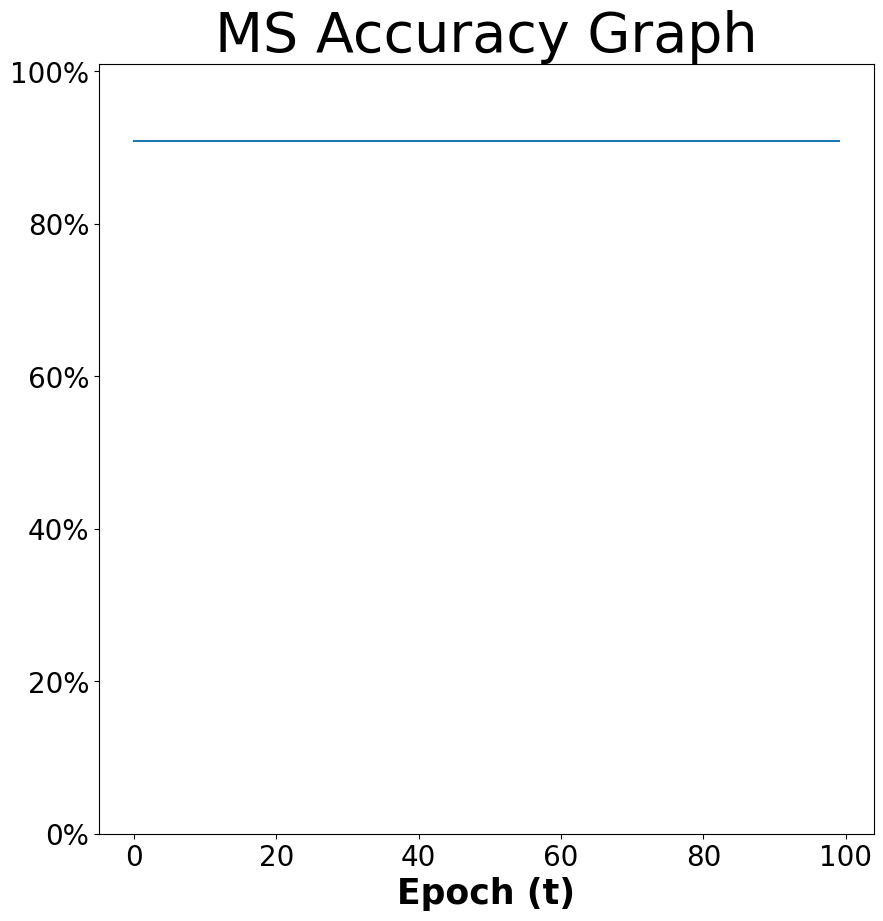

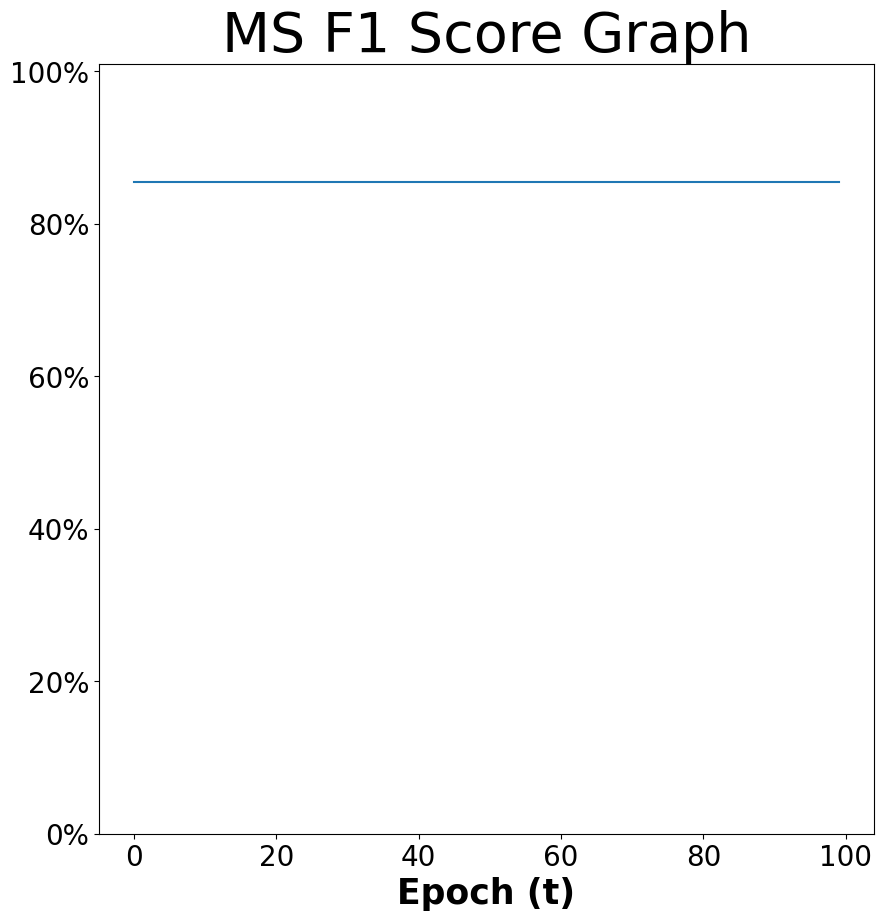

In [75]:
save_figs(ms_glvq_fscore, experiment, "MS", learning_rate)

##### LS

##### 1-step lr = 0.1

In [76]:
learning_rate = 0.1
ls_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = ls_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.loose_symmetry,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.3198, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 11, Loss: 0.3091, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 21, Loss: 0.3086, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 31, Loss: 0.3085, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 41, Loss: 0.3086, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 51, Loss: 0.3086, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 61, Loss: 0.3088, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 71, Loss: 0.3088, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 81, Loss: 0.3088, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 91, Loss: 0.3088, Accuracy: 90.91 %, F_1_score: 85.45 %


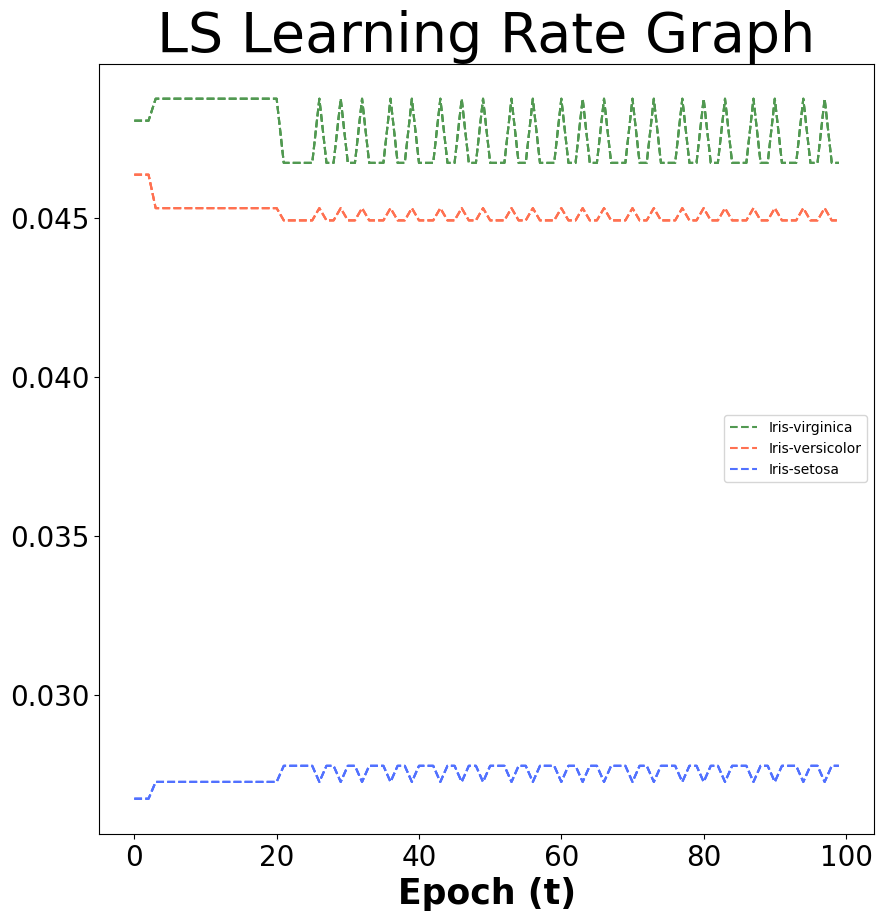

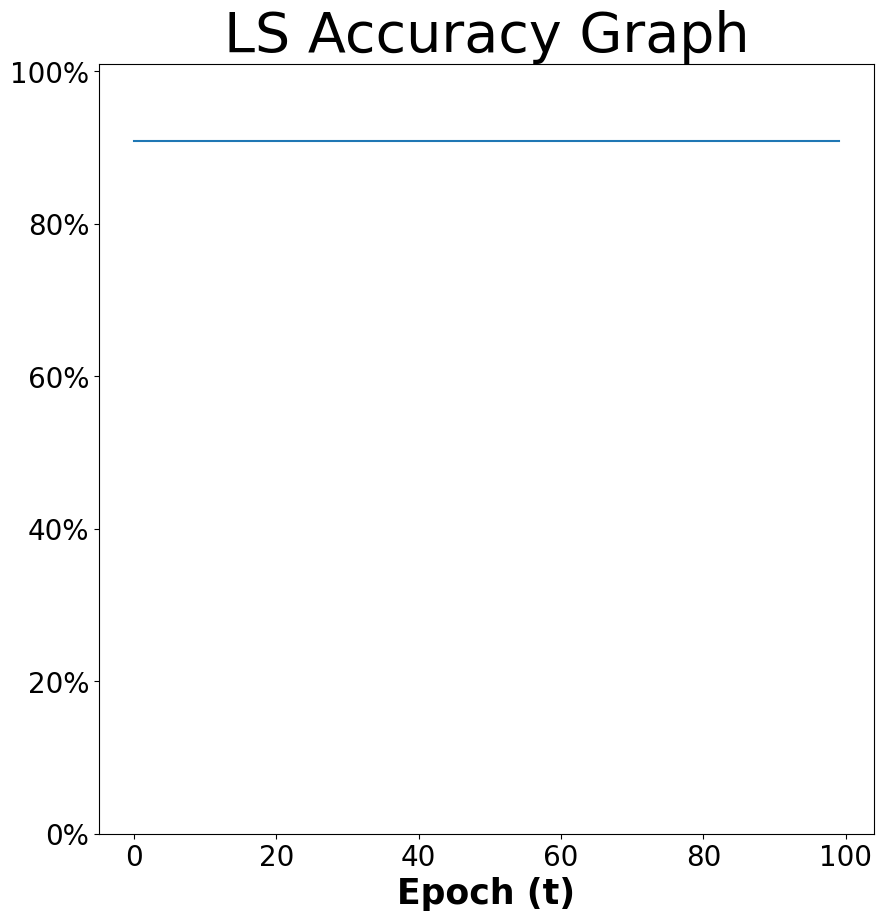

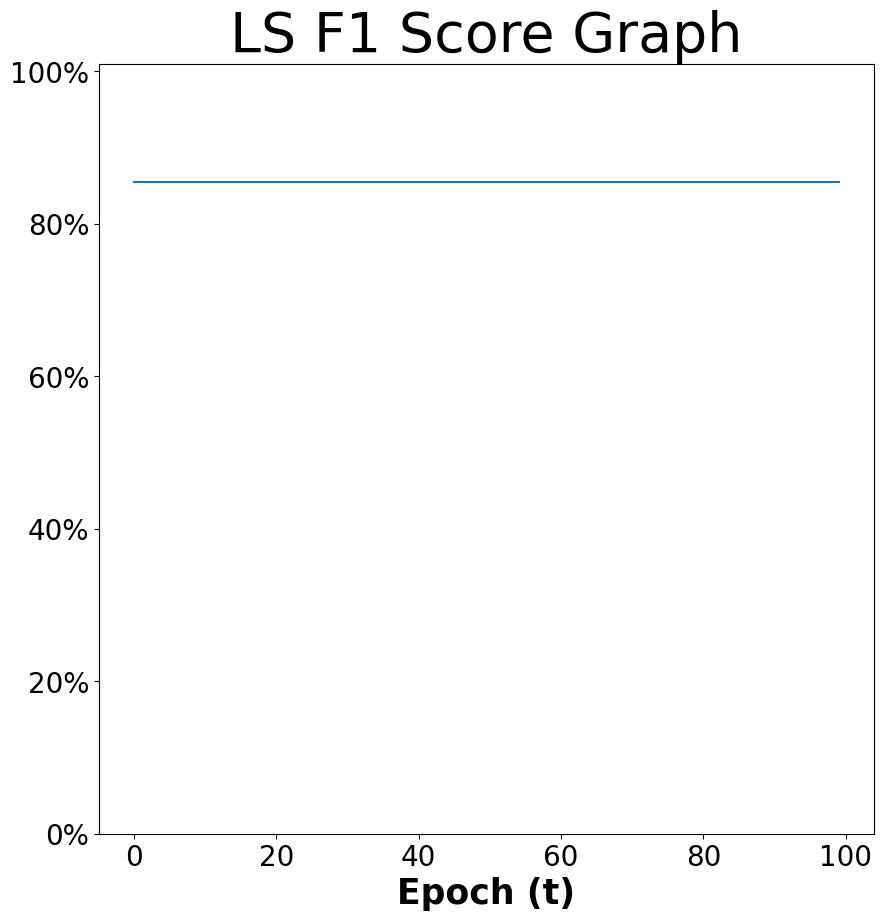

In [77]:
save_figs(ls_glvq_fscore, experiment, "LS", learning_rate)

##### 2-step lr = 0.03

In [78]:
learning_rate = 0.03
ls_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = ls_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.loose_symmetry,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.3229, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 11, Loss: 0.3060, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 21, Loss: 0.3052, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 31, Loss: 0.3051, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 41, Loss: 0.3051, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 51, Loss: 0.3051, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 61, Loss: 0.3050, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 71, Loss: 0.3051, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 81, Loss: 0.3050, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 91, Loss: 0.3051, Accuracy: 90.91 %, F_1_score: 85.45 %


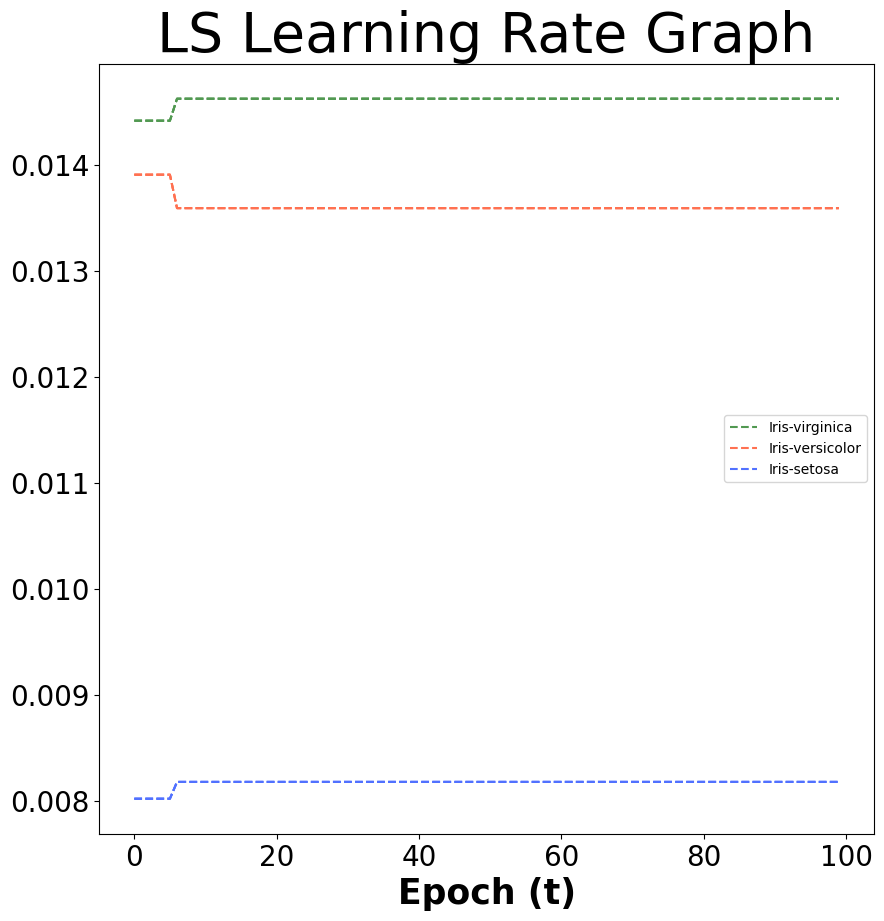

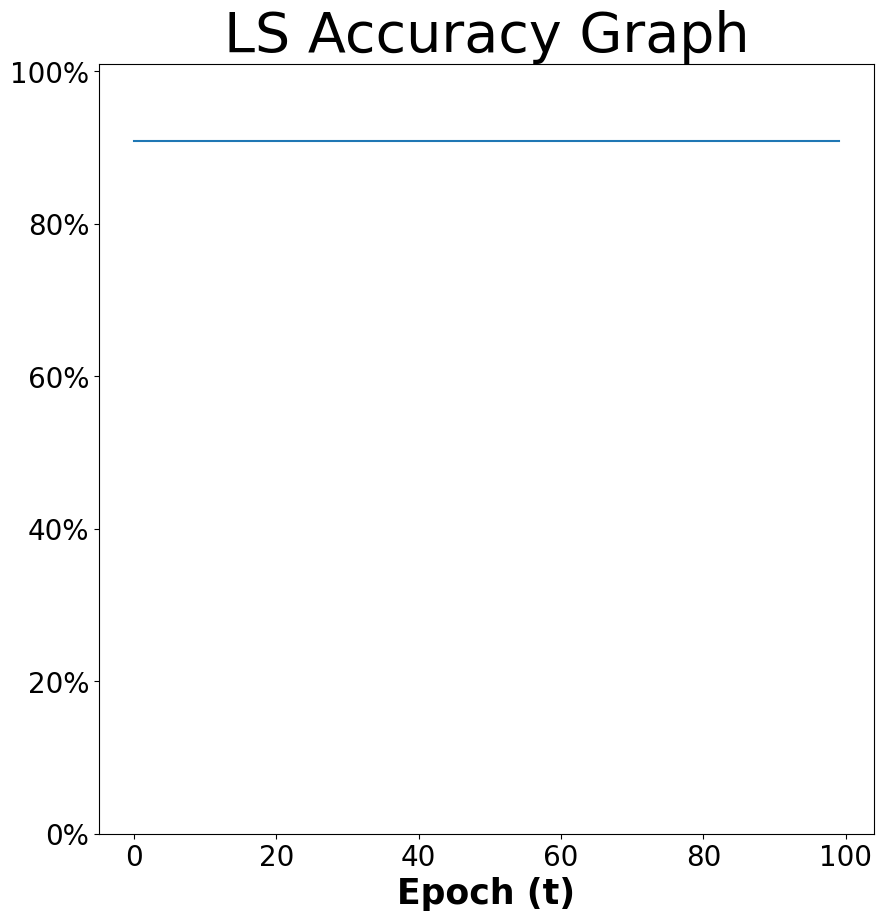

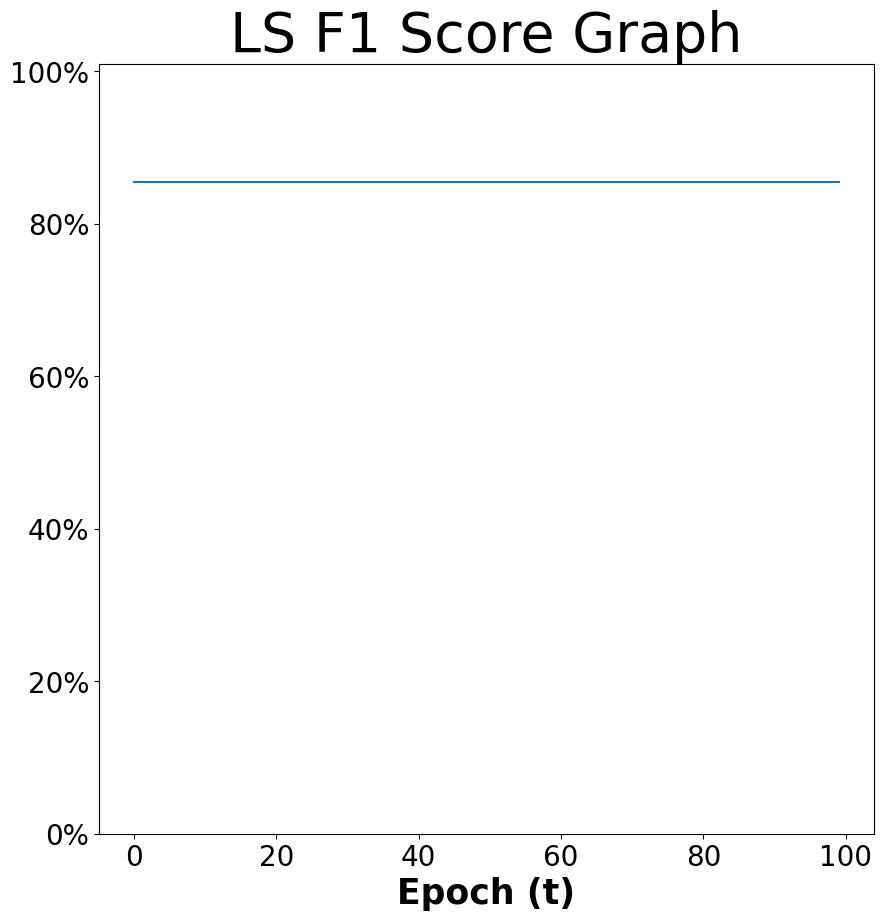

In [79]:
save_figs(ls_glvq_fscore, experiment, "LS", learning_rate)

##### 3-step lr = 0.01

In [80]:
learning_rate = 0.01
ls_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = ls_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.loose_symmetry,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.3246, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 11, Loss: 0.3086, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 21, Loss: 0.3062, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 31, Loss: 0.3052, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 41, Loss: 0.3047, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 51, Loss: 0.3045, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 61, Loss: 0.3044, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 71, Loss: 0.3044, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 81, Loss: 0.3044, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 91, Loss: 0.3044, Accuracy: 90.91 %, F_1_score: 85.45 %


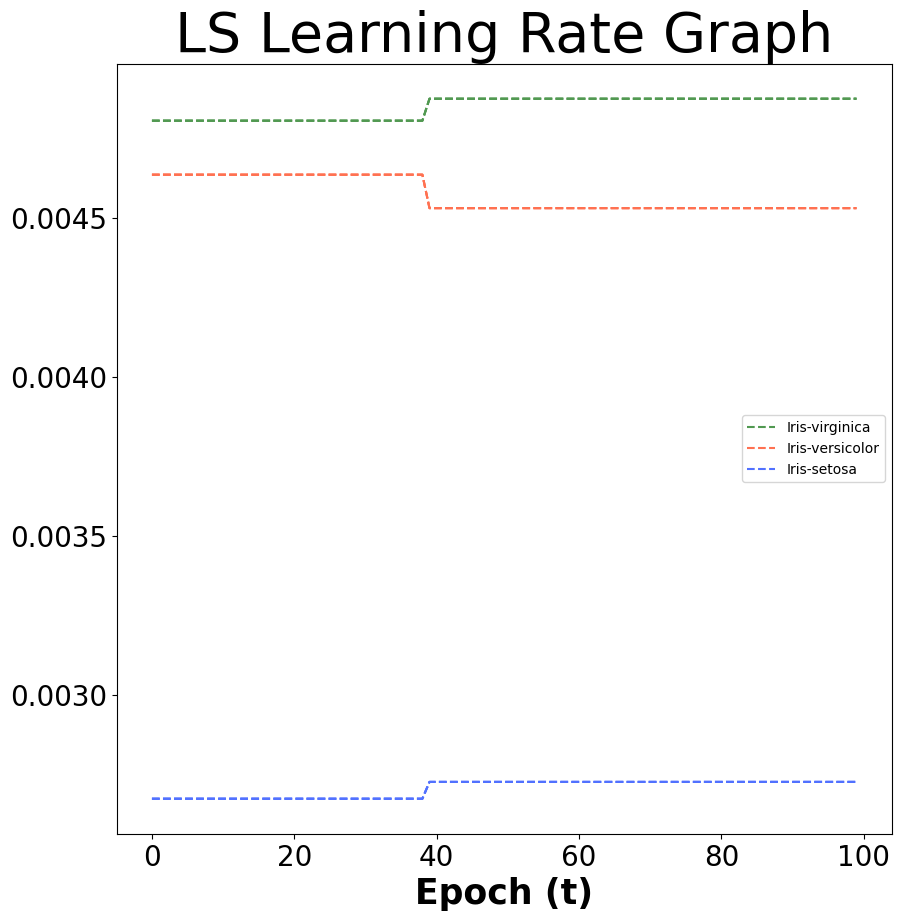

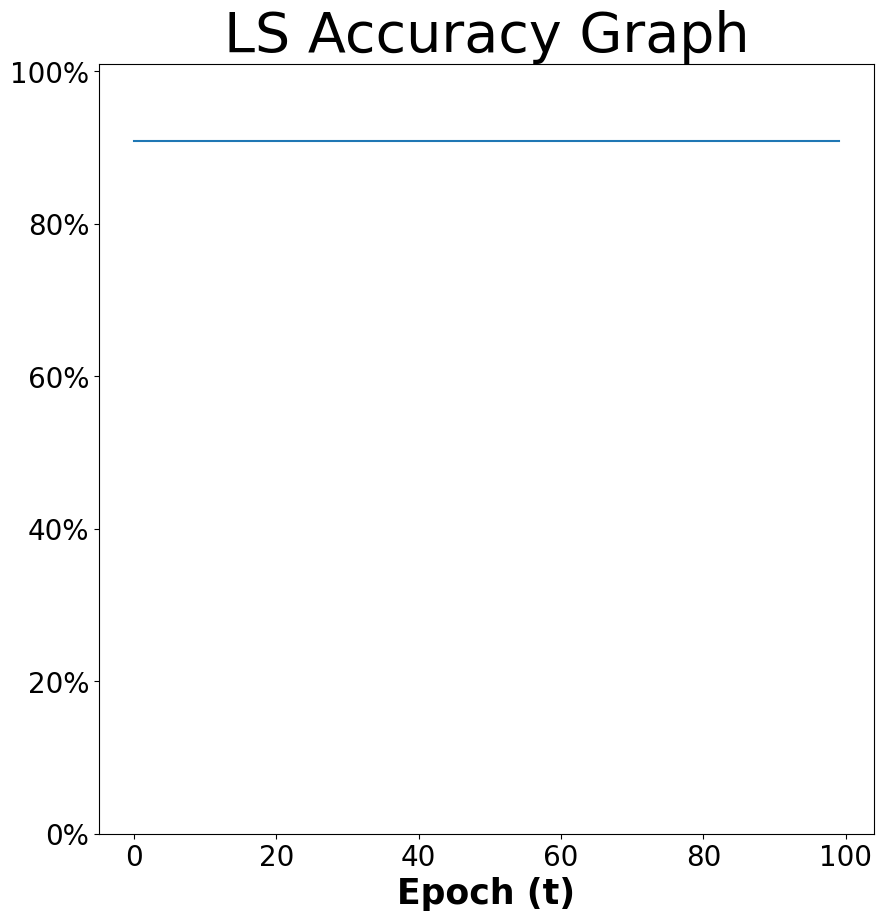

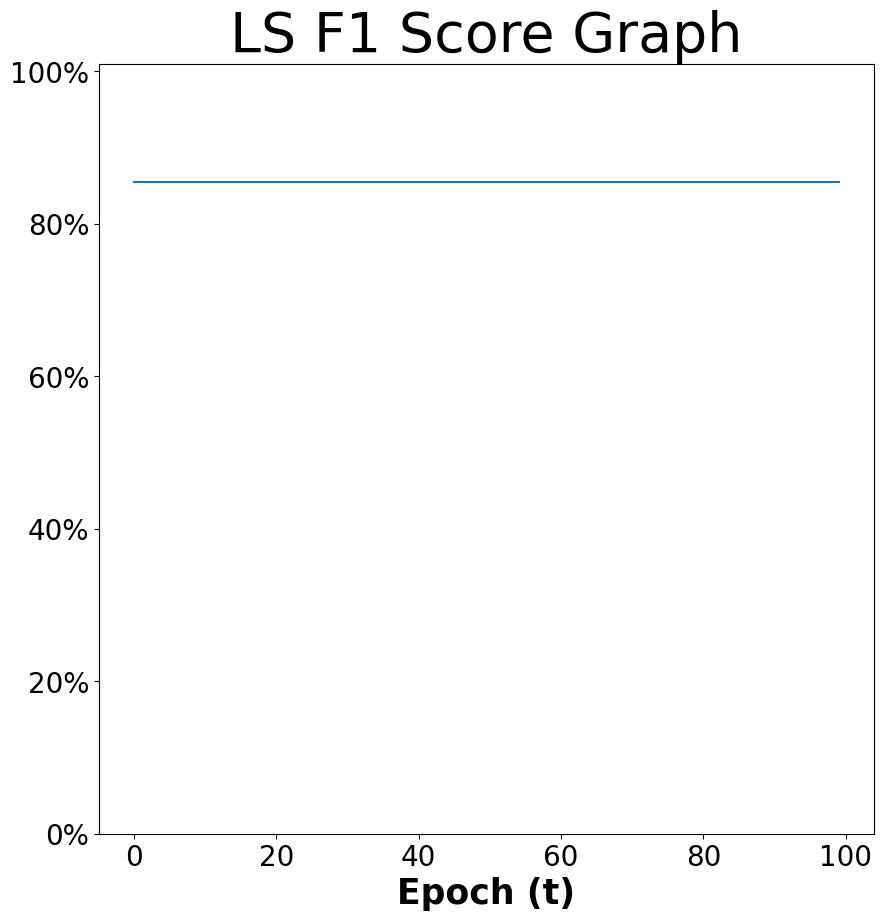

In [81]:
save_figs(ls_glvq_fscore, experiment, "LS", learning_rate)

##### LSR

##### 1-step lr = 0.1

In [82]:
learning_rate = 0.1
lsr_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = lsr_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.loose_symmetry_rarity,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.3200, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 11, Loss: 0.3083, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 21, Loss: 0.3083, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 31, Loss: 0.3083, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 41, Loss: 0.3087, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 51, Loss: 0.3087, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 61, Loss: 0.3090, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 71, Loss: 0.3091, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 81, Loss: 0.3092, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 91, Loss: 0.3083, Accuracy: 90.91 %, F_1_score: 85.45 %


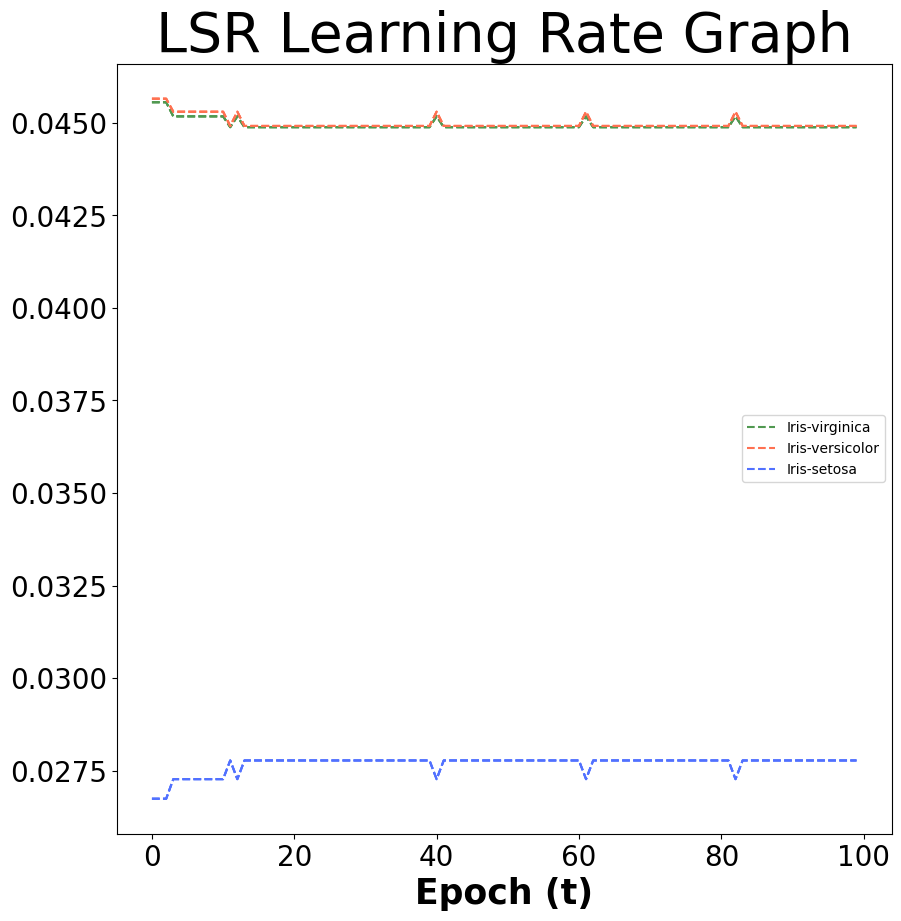

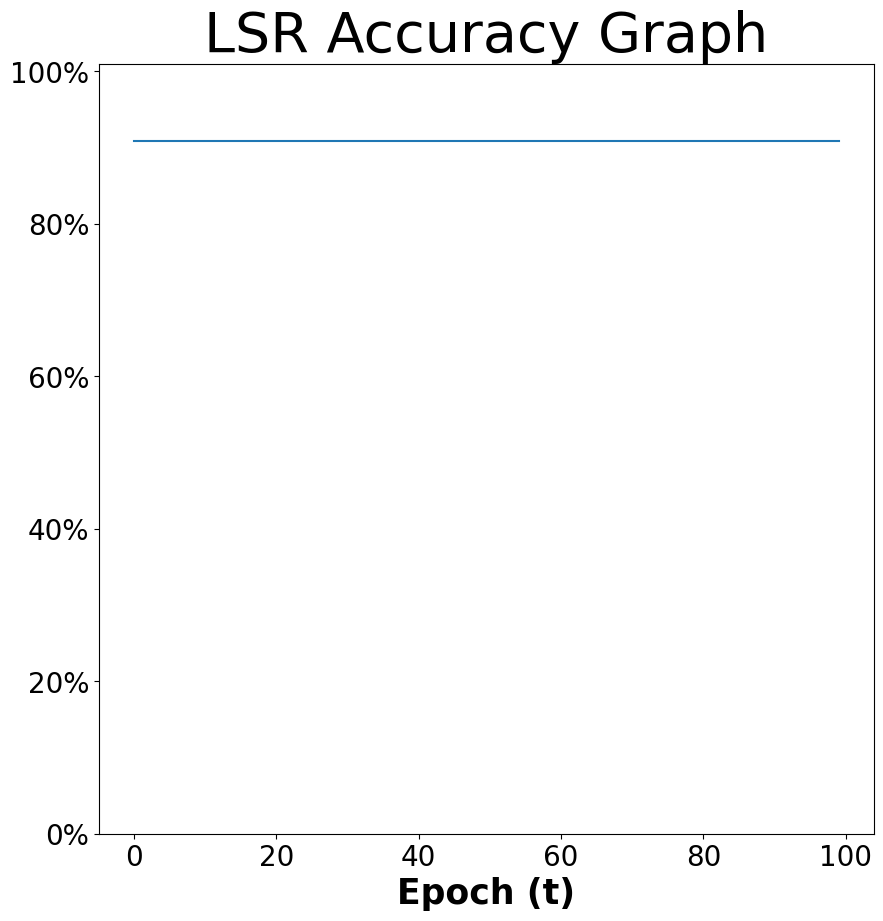

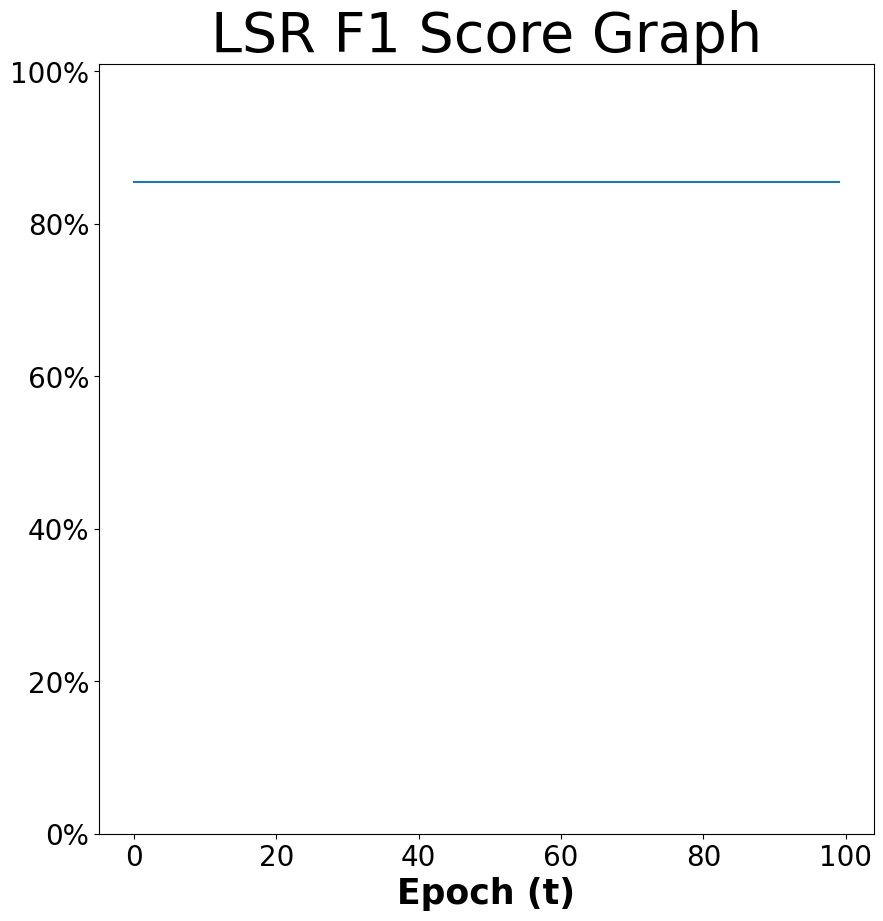

In [83]:
save_figs(lsr_glvq_fscore, experiment, "LSR", learning_rate)

##### 2-step lr = 0.03

In [84]:
learning_rate = 0.03
lsr_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = lsr_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.loose_symmetry_rarity,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.3230, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 11, Loss: 0.3061, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 21, Loss: 0.3053, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 31, Loss: 0.3051, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 41, Loss: 0.3050, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 51, Loss: 0.3050, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 61, Loss: 0.3050, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 71, Loss: 0.3050, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 81, Loss: 0.3049, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 91, Loss: 0.3050, Accuracy: 90.91 %, F_1_score: 85.45 %


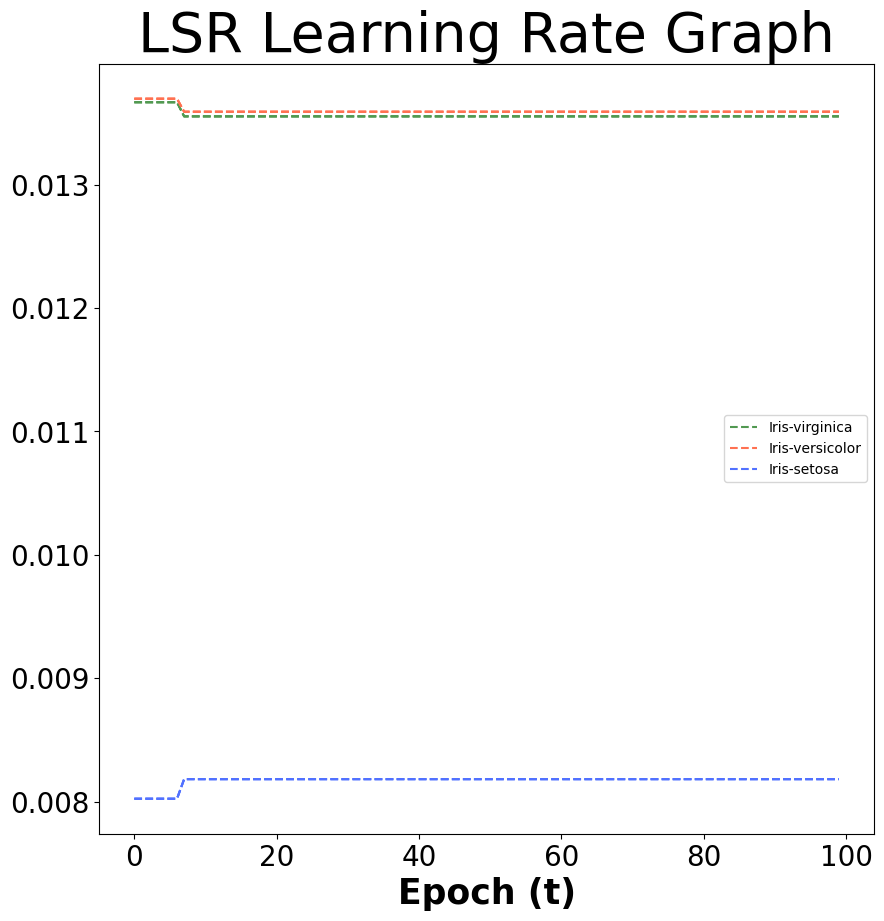

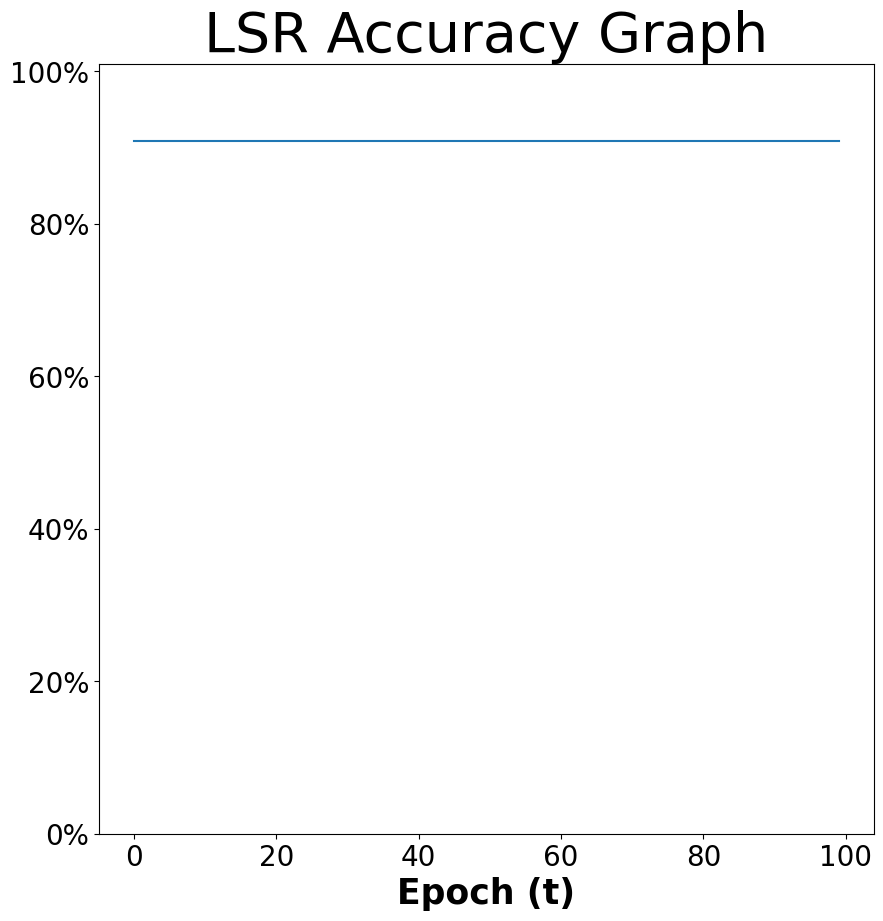

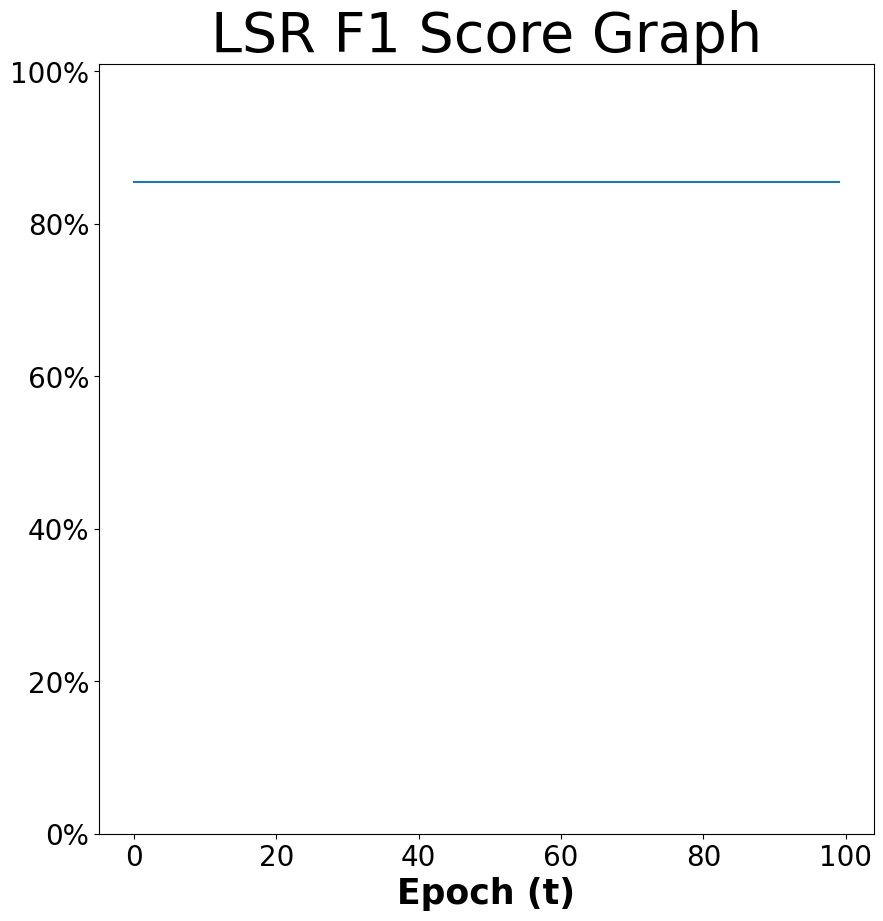

In [85]:
save_figs(lsr_glvq_fscore, experiment, "LSR", learning_rate)

##### 3-step lr = 0.01

In [86]:
learning_rate = 0.01
lsr_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = lsr_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.loose_symmetry_rarity,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.3246, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 11, Loss: 0.3087, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 21, Loss: 0.3063, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 31, Loss: 0.3053, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 41, Loss: 0.3048, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 51, Loss: 0.3045, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 61, Loss: 0.3044, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 71, Loss: 0.3044, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 81, Loss: 0.3043, Accuracy: 90.91 %, F_1_score: 85.45 %
Epoch: 91, Loss: 0.3044, Accuracy: 90.91 %, F_1_score: 85.45 %


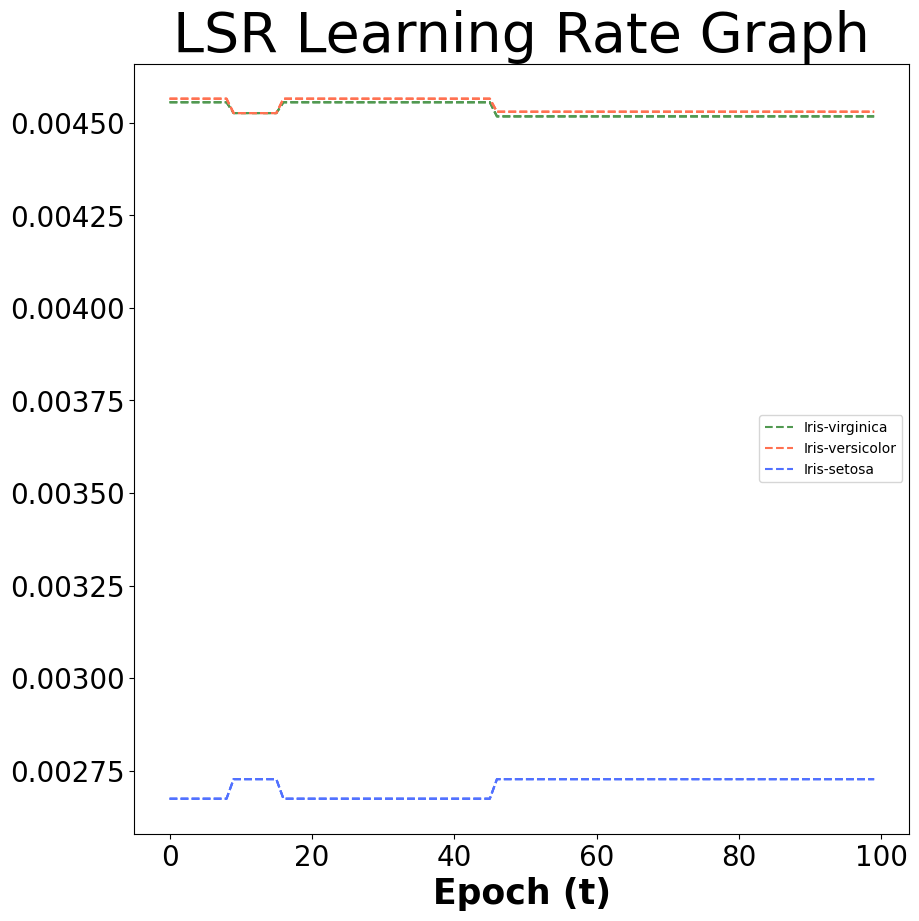

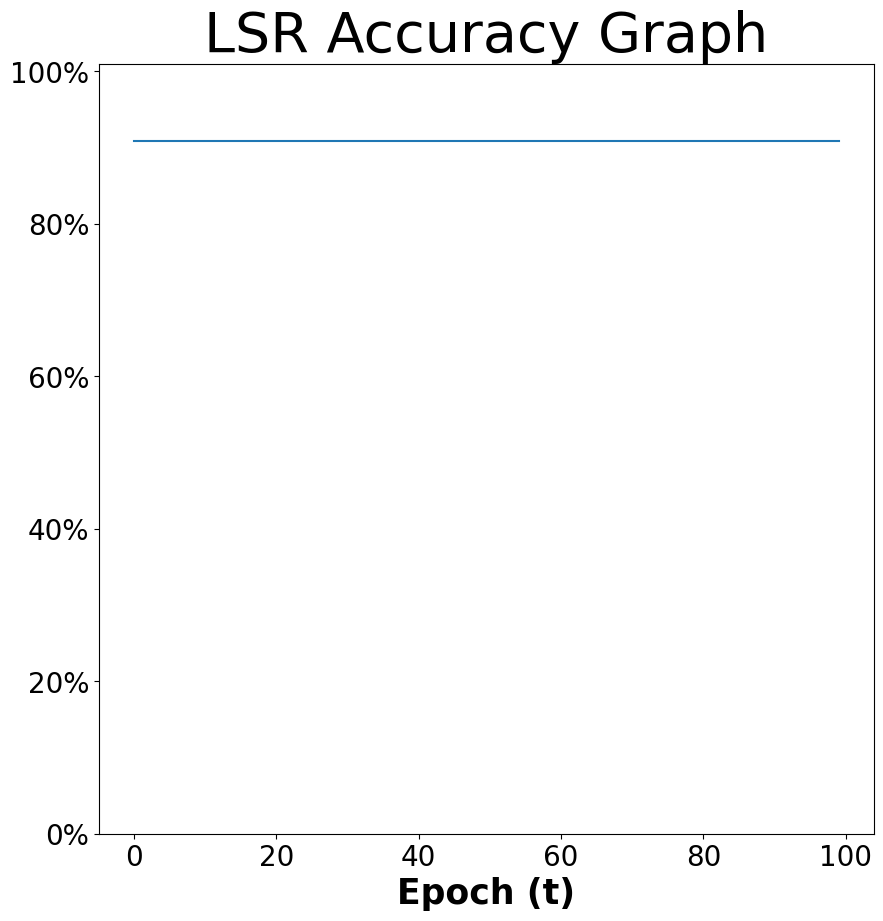

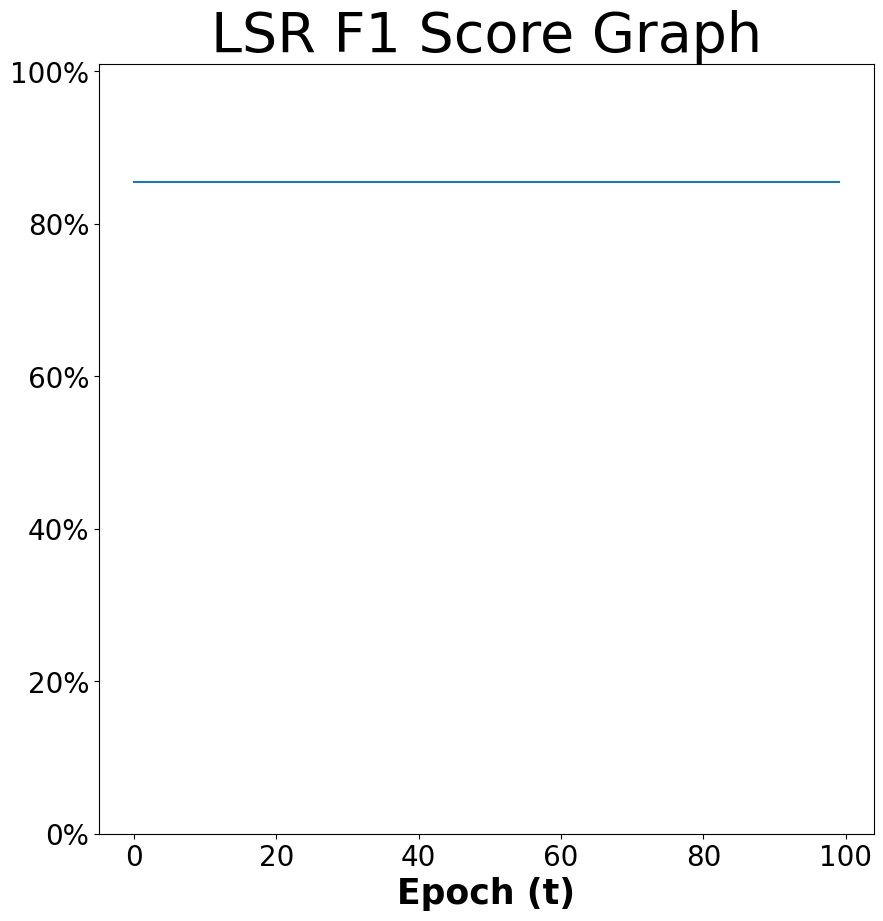

In [87]:
save_figs(lsr_glvq_fscore, experiment, "LSR", learning_rate)